Standard Unsupervised Anomoly Detection


KMeans Performance:
Accuracy: 0.0428
False Positives: 10000
False Negatives: 150
Percentage of Errors Correctly Identified: 75.17%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.04      0.75      0.08       604

    accuracy                           0.04     10604
   macro avg       0.02      0.38      0.04     10604
weighted avg       0.00      0.04      0.00     10604


DBSCAN Performance:
Accuracy: 0.6942
False Positives: 2715
False Negatives: 528
Percentage of Errors Correctly Identified: 12.58%
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     10000
           1       0.03      0.13      0.04       604

    accuracy                           0.69     10604
   macro avg       0.48      0.43      0.43     10604
weighted avg       0.88      0.69      0.77     10604


Isolation Forest Performance:
Accuracy: 0.8756
False Positives: 967
False Negative

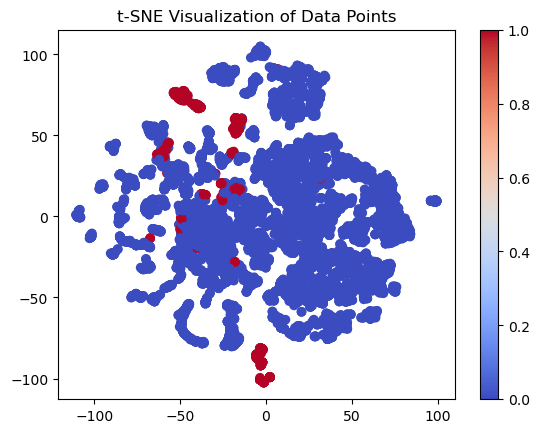

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE

# Preprocess Data
df = pd.read_csv(r"C:/Users/twool/Downloads/Feature_Extraction/6414_Test/GTAA_Errors_with_metrics.csv")  
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Identify feature and target columns
ignore_cols = ["id", "index"]
target_col = "Error"
features = df.drop(columns=ignore_cols + [target_col])
target = df[target_col]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Function to evaluate unsupervised models
def evaluate_unsupervised_model(model_name, model, features_scaled, true_labels):
    y_pred = model.fit_predict(features_scaled)
    # For clustering methods, -1 indicates outliers (errors).
    # Convert predictions to binary (1 for error, 0 for non-error).
    y_pred_binary = (y_pred == -1).astype(int) if model_name in ["DBSCAN", "Isolation Forest"] else (y_pred > 0).astype(int)

    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

# 1. KMeans
kmeans = KMeans(n_clusters=70, random_state=42)
evaluate_unsupervised_model("KMeans", kmeans, features_scaled, target)

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
evaluate_unsupervised_model("DBSCAN", dbscan, features_scaled, target)

# 3. Isolation Forest
iso_forest = IsolationForest(random_state=42)
evaluate_unsupervised_model("Isolation Forest", iso_forest, features_scaled, target)

# 4. PCA + Anomaly Detection
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
features_pca = pca.fit_transform(features_scaled)

# Use Local Outlier Factor (LOF) to detect anomalies in the reduced dimensional space
lof = LocalOutlierFactor(n_neighbors=5)
evaluate_unsupervised_model("PCA + LOF", lof, features_pca, target)

# 5. t-SNE visualization (optional, for visual inspection)
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_scaled)

# Visualize t-SNE plot
import matplotlib.pyplot as plt
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=target, cmap='coolwarm')
plt.colorbar()
plt.title("t-SNE Visualization of Data Points")
plt.show()


Clustering with silhouette score

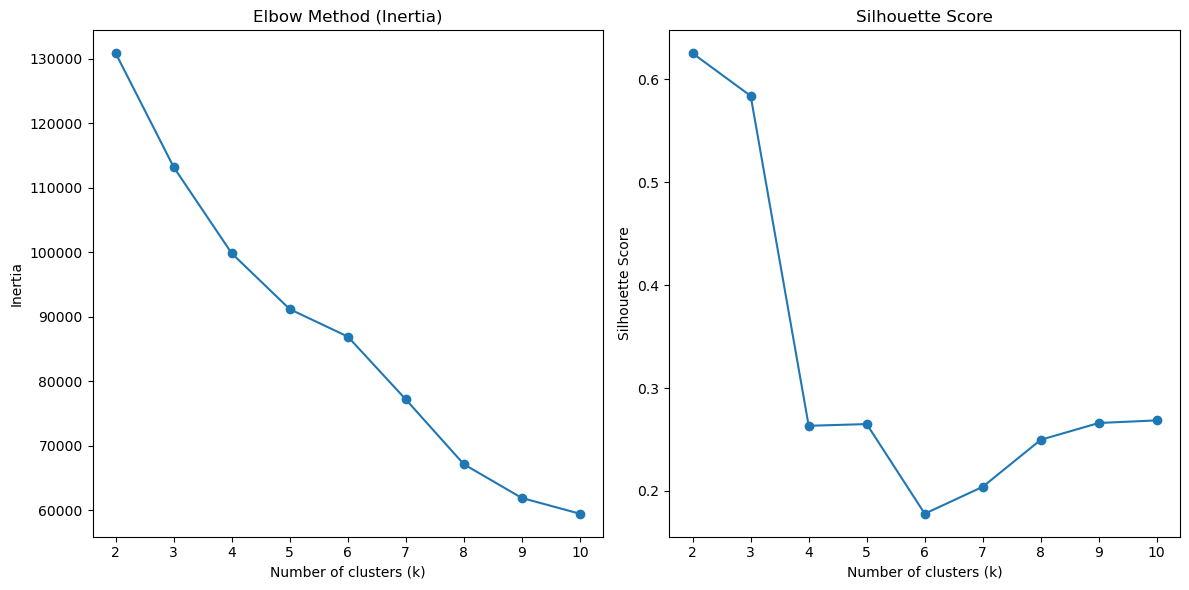

Optimal number of clusters based on Silhouette Score: 2
Best cluster as errors (Cluster 0):
Accuracy: 0.9052
F1 Score: 0.0079
False Positives: 405
False Negatives: 600
Percentage of Errors Correctly Identified: 0.66%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.01      0.01      0.01       604

    accuracy                           0.91     10604
   macro avg       0.48      0.48      0.48     10604
weighted avg       0.89      0.91      0.90     10604



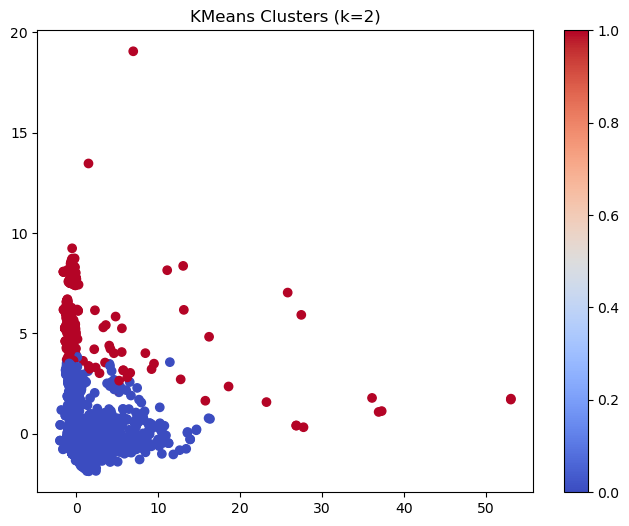

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Function to evaluate the clustering model by treating each cluster as errors
def evaluate_kmeans_clustering(kmeans, features_scaled, true_labels):
    y_pred = kmeans.labels_  # Get cluster assignments (0, 1, 2, ...)
    
    best_accuracy = 0
    best_cluster = -1
    best_metrics = None
    best_y_pred_binary = None

    # Try each cluster as the "error" cluster and the rest as "non-error"
    for cluster in np.unique(y_pred):
        # Mark the cluster as errors (1) and the rest as non-errors (0)
        y_pred_binary = (y_pred == cluster).astype(int)
        
        # Compute the confusion matrix and evaluation metrics
        tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
        accuracy = accuracy_score(true_labels, y_pred_binary)
        percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster = cluster
            best_metrics = {
                "accuracy": accuracy,
                "f1_score": f1_score(true_labels, y_pred_binary),
                "false_positives": fp,
                "false_negatives": fn,
                "percent_errors_identified": percent_errors_identified,
            }
            best_y_pred_binary = y_pred_binary
    
    print(f"Best cluster as errors (Cluster {best_cluster}):")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"F1 Score: {best_metrics['f1_score']:.4f}")
    print(f"False Positives: {best_metrics['false_positives']}")
    print(f"False Negatives: {best_metrics['false_negatives']}")
    print(f"Percentage of Errors Correctly Identified: {best_metrics['percent_errors_identified']:.2f}%")
    print(classification_report(true_labels, best_y_pred_binary))

    return best_y_pred_binary, best_metrics


# 1. Find the best number of clusters using Elbow Method and Silhouette Score
def find_optimal_k(features_scaled):
    inertia = []
    silhouette_scores = []
    
    for k in range(2, 11):  # Test with k = 2 to 10 clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        
        # Compute inertia (sum of squared distances to centroids)
        inertia.append(kmeans.inertia_)
        
        # Compute silhouette score
        silhouette = silhouette_score(features_scaled, kmeans.labels_)
        silhouette_scores.append(silhouette)
    
    # Plot Elbow Method (Inertia) and Silhouette Scores
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), inertia, marker='o')
    plt.title("Elbow Method (Inertia)")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title("Silhouette Score")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    
    plt.tight_layout()
    plt.show()

    # Return optimal k based on maximum silhouette score
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2  # adding 2 to account for range starting at 2
    print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
    
    return optimal_k


# Find the optimal k
optimal_k = find_optimal_k(features_scaled)

# 2. Train KMeans with optimal k and evaluate
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features_scaled)

# Evaluate the clustering results
best_y_pred_binary, best_metrics = evaluate_kmeans_clustering(kmeans, features_scaled, target)

# 3. Visualize the clusters in 2D space (if PCA for dimensionality reduction is desired)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=best_y_pred_binary, cmap='coolwarm')
plt.title(f"KMeans Clusters (k={optimal_k})")
plt.colorbar()
plt.show()


Clustering based on outliers from the centroid

Accuracy: 0.9058
False Positives: 410
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.04      0.02      0.03       604

    accuracy                           0.91     10604
   macro avg       0.49      0.49      0.49     10604
weighted avg       0.89      0.91      0.90     10604



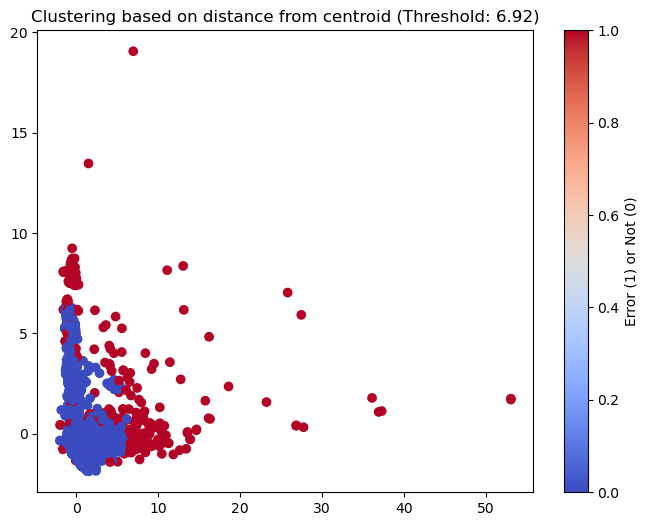

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Train KMeans with a single cluster (K=1)
def kmeans_single_cluster(features_scaled):
    kmeans = KMeans(n_clusters=1, random_state=42)
    kmeans.fit(features_scaled)
    
    # Get the centroid of the single cluster
    centroid = kmeans.cluster_centers_[0]
    
    # Calculate the distance of each point from the centroid
    distances = np.linalg.norm(features_scaled - centroid, axis=1)
    
    return distances, centroid

# 2. Determine errors based on distance from centroid (define "far" as being above a certain threshold)
def identify_errors_based_on_distance(distances, threshold_percentile=96):
    # Set the threshold as the 90th percentile of the distances
    threshold = np.percentile(distances, threshold_percentile)
    
    # Mark points that are far from the centroid as errors (1), and the rest as non-errors (0)
    y_pred_binary = (distances >= threshold).astype(int)
    
    return y_pred_binary, threshold

# 3. Evaluate the clustering results
def evaluate_kmeans_with_single_cluster(distances, y_pred_binary, true_labels):
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

# 4. Visualize the clusters (based on distance)
def visualize_clusters(features_scaled, distances, threshold, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Mark points that are errors (far from centroid)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(distances >= threshold), cmap='coolwarm')
    plt.title(f"Clustering based on distance from centroid (Threshold: {threshold:.2f})")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Train KMeans with a single cluster
distances, centroid = kmeans_single_cluster(features_scaled)

# Identify errors based on distance from centroid
y_pred_binary, threshold = identify_errors_based_on_distance(distances)

# Evaluate the clustering results
evaluate_kmeans_with_single_cluster(distances, y_pred_binary, target)

# Visualize the clustering result
visualize_clusters(features_scaled, distances, threshold)


Accuracy: 0.0948
False Positives: 9595
False Negatives: 4
Percentage of Errors Correctly Identified: 99.34%
              precision    recall  f1-score   support

           0       0.99      0.04      0.08     10000
           1       0.06      0.99      0.11       604

    accuracy                           0.09     10604
   macro avg       0.52      0.52      0.09     10604
weighted avg       0.94      0.09      0.08     10604



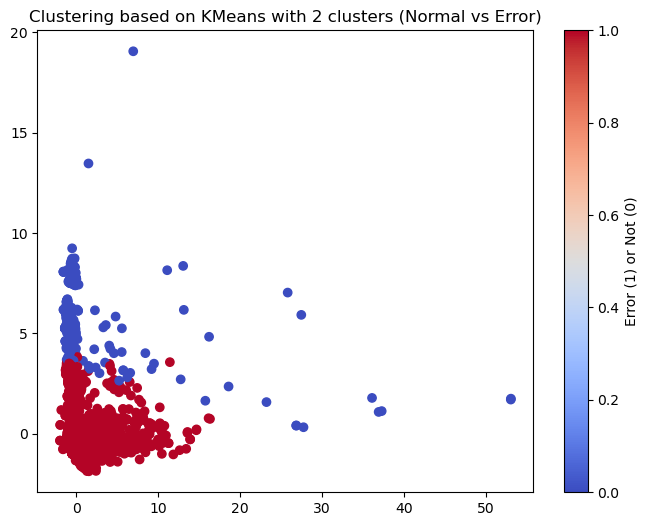

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Train KMeans with 2 clusters (normal and error)
def kmeans_two_clusters(features_scaled):
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(features_scaled)
    
    # Get the cluster labels (0 and 1)
    cluster_labels = kmeans.labels_
    
    # Count the number of points in each cluster
    cluster_sizes = np.bincount(cluster_labels)
    
    # Assuming the larger cluster is the "normal" cluster (0) and the smaller one is the "error" cluster (1)
    normal_cluster = np.argmin(cluster_sizes)  # smaller cluster is considered "error"
    
    return cluster_labels, normal_cluster

# 2. Evaluate the clustering results
def evaluate_kmeans_with_two_clusters(cluster_labels, normal_cluster, true_labels):
    # Mark points in the "error" cluster (not the "normal" cluster)
    y_pred_binary = (cluster_labels != normal_cluster).astype(int)  # Error cluster as 1, normal as 0
    
    # Confusion matrix and performance metrics
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

# 3. Visualize the clusters (based on cluster labels)
def visualize_clusters(features_scaled, cluster_labels, normal_cluster, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot the data points, color-coded by their cluster label (normal vs. error)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels != normal_cluster), cmap='coolwarm')
    plt.title("Clustering based on KMeans with 2 clusters (Normal vs Error)")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Train KMeans with 2 clusters (normal and error)
cluster_labels, normal_cluster = kmeans_two_clusters(features_scaled)

# Evaluate the clustering results
evaluate_kmeans_with_two_clusters(cluster_labels, normal_cluster, target)

# Visualize the clustering result
visualize_clusters(features_scaled, cluster_labels, normal_cluster)



KMeans (2 clusters)


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans (2 clusters) - Evaluation Metrics:
Accuracy: 0.0939
False Positives: 9608
False Negatives: 0
Percentage of Errors Correctly Identified: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.04      0.08     10000
           1       0.06      1.00      0.11       604

    accuracy                           0.09     10604
   macro avg       0.53      0.52      0.09     10604
weighted avg       0.95      0.09      0.08     10604



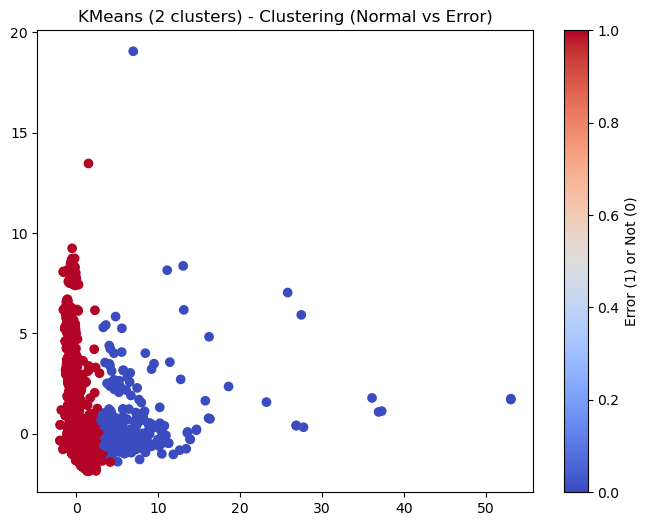


DBSCAN
DBSCAN - Evaluation Metrics:
Accuracy: 0.0570
False Positives: 10000
False Negatives: 0
Percentage of Errors Correctly Identified: 100.00%


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.06      1.00      0.11       604

    accuracy                           0.06     10604
   macro avg       0.03      0.50      0.05     10604
weighted avg       0.00      0.06      0.01     10604



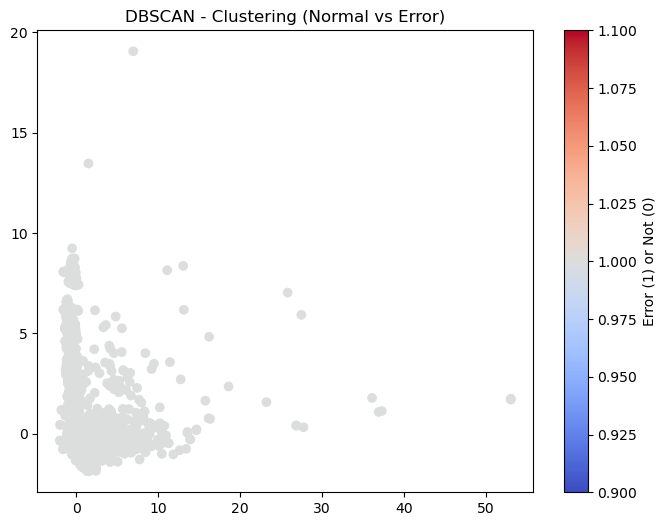


Agglomerative Clustering (2 clusters)
Agglomerative Clustering (2 clusters) - Evaluation Metrics:
Accuracy: 0.1560
False Positives: 8935
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       0.99      0.11      0.19     10000
           1       0.06      0.98      0.12       604

    accuracy                           0.16     10604
   macro avg       0.52      0.54      0.15     10604
weighted avg       0.93      0.16      0.19     10604



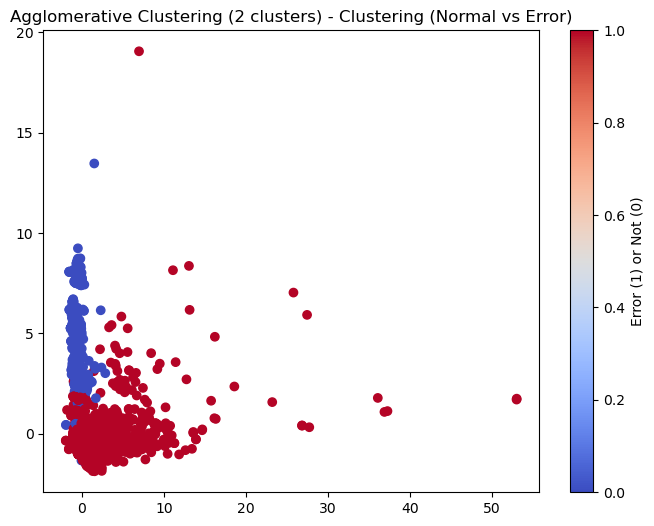


Gaussian Mixture Model (2 components)
Gaussian Mixture Model (2 components) - Evaluation Metrics:
Accuracy: 0.3958
False Positives: 6145
False Negatives: 262
Percentage of Errors Correctly Identified: 56.62%
              precision    recall  f1-score   support

           0       0.94      0.39      0.55     10000
           1       0.05      0.57      0.10       604

    accuracy                           0.40     10604
   macro avg       0.49      0.48      0.32     10604
weighted avg       0.89      0.40      0.52     10604



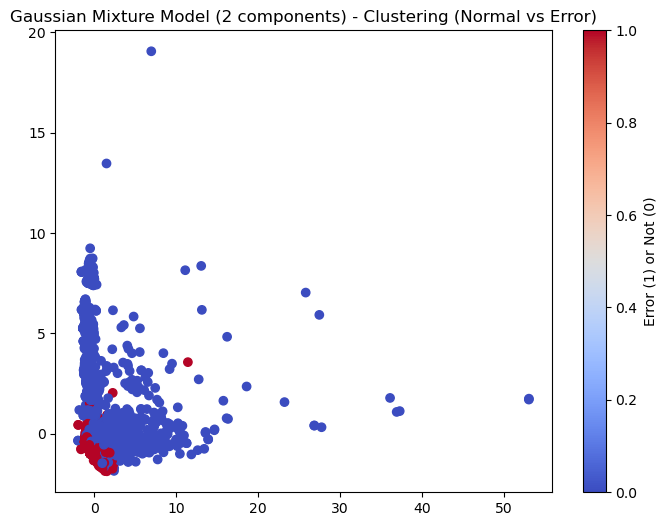


Mean Shift
Mean Shift - Evaluation Metrics:
Accuracy: 0.0571
False Positives: 9999
False Negatives: 0
Percentage of Errors Correctly Identified: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     10000
           1       0.06      1.00      0.11       604

    accuracy                           0.06     10604
   macro avg       0.53      0.50      0.05     10604
weighted avg       0.95      0.06      0.01     10604



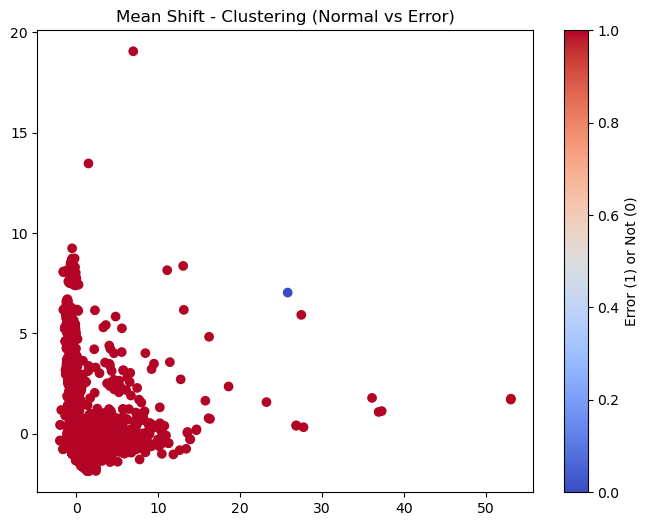

In [344]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define a function to evaluate and visualize each clustering method
def evaluate_and_visualize_clustering(clustering_model, name, features_scaled, true_labels):
    # Fit the model
    clustering_model.fit(features_scaled)
    
    # Get the cluster labels
    cluster_labels = clustering_model.labels_ if hasattr(clustering_model, 'labels_') else clustering_model.predict(features_scaled)
    
    # Handle DBSCAN noise (-1) and treat it as errors
    if np.any(cluster_labels == -1):
        cluster_labels = np.where(cluster_labels == -1, len(set(cluster_labels)), cluster_labels)  # Convert -1 (noise) to a new cluster
    
    # Assume the cluster with the fewer points is the error cluster (and the other is the normal cluster)
    cluster_sizes = np.bincount(cluster_labels)
    normal_cluster = np.argmin(cluster_sizes)  # Smaller cluster is assumed to be error
    
    # Mark errors (everything in the error cluster is marked as error)
    y_pred_binary = (cluster_labels != normal_cluster).astype(int)  # Error cluster as 1, normal as 0
    
    # Evaluation metrics
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"{name} - Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))
    
    # Visualize the clusters
    visualize_clusters(features_scaled, cluster_labels, normal_cluster, name)

# Define a function for visualizing the clustering results
def visualize_clusters(features_scaled, cluster_labels, normal_cluster, model_name, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot the data points, color-coded by their cluster label (normal vs. error)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels != normal_cluster), cmap='coolwarm')
    plt.title(f"{model_name} - Clustering (Normal vs Error)")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Try different clustering methods
clustering_models = [
    (KMeans(n_clusters=2, random_state=42), "KMeans (2 clusters)"),
    (DBSCAN(), "DBSCAN"),
    (AgglomerativeClustering(n_clusters=2), "Agglomerative Clustering (2 clusters)"),
    (GaussianMixture(n_components=2, random_state=42), "Gaussian Mixture Model (2 components)"),
    (MeanShift(), "Mean Shift")
]

# Iterate over clustering models and evaluate them
for model, name in clustering_models:
    print(f"\n{ '='*50 }\n{name}")
    evaluate_and_visualize_clustering(model, name, features_scaled, target)


Trying many clustering approaches and number of clusters


Evaluating with 2 clusters...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



KMeans - 2 clusters, Error Cluster: 0
Accuracy: 0.9061
False Positives: 392
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.91     10604
   macro avg       0.47      0.48      0.48     10604
weighted avg       0.89      0.91      0.90     10604



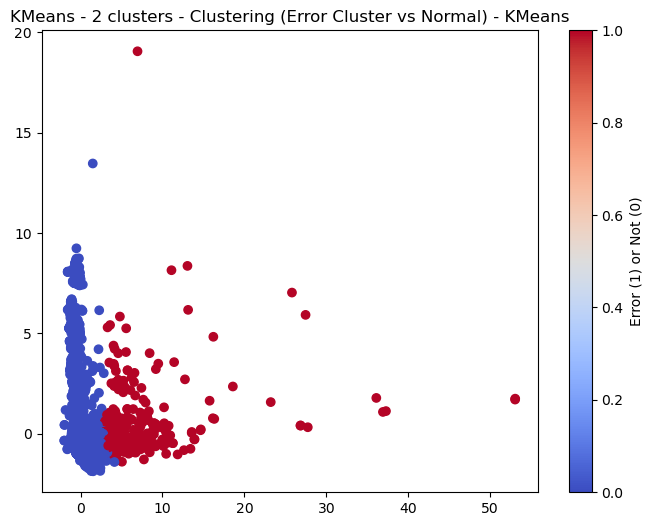


KMeans - 2 clusters, Error Cluster: 1
Accuracy: 0.0939
False Positives: 9608
False Negatives: 0
Percentage of Errors Correctly Identified: 100.00%
              precision    recall  f1-score   support

           0       1.00      0.04      0.08     10000
           1       0.06      1.00      0.11       604

    accuracy                           0.09     10604
   macro avg       0.53      0.52      0.09     10604
weighted avg       0.95      0.09      0.08     10604



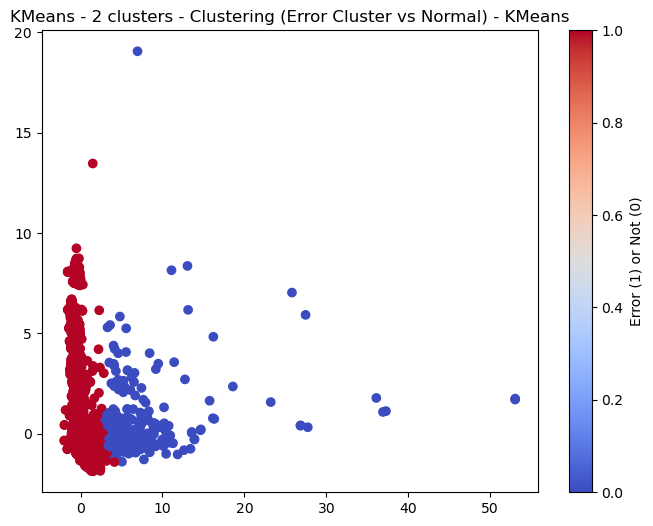


Evaluating with 3 clusters...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



KMeans - 3 clusters, Error Cluster: 0
Accuracy: 0.8452
False Positives: 1059
False Negatives: 582
Percentage of Errors Correctly Identified: 3.64%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.02      0.04      0.03       604

    accuracy                           0.85     10604
   macro avg       0.48      0.47      0.47     10604
weighted avg       0.89      0.85      0.87     10604



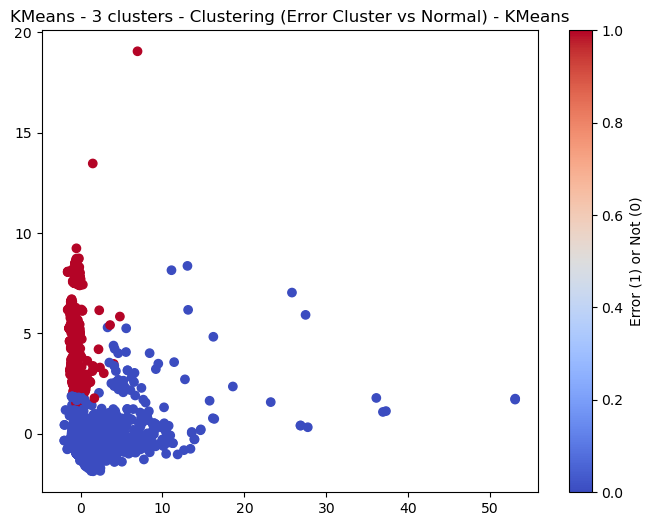


KMeans - 3 clusters, Error Cluster: 1
Accuracy: 0.9080
False Positives: 372
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.91     10604
   macro avg       0.47      0.48      0.48     10604
weighted avg       0.89      0.91      0.90     10604



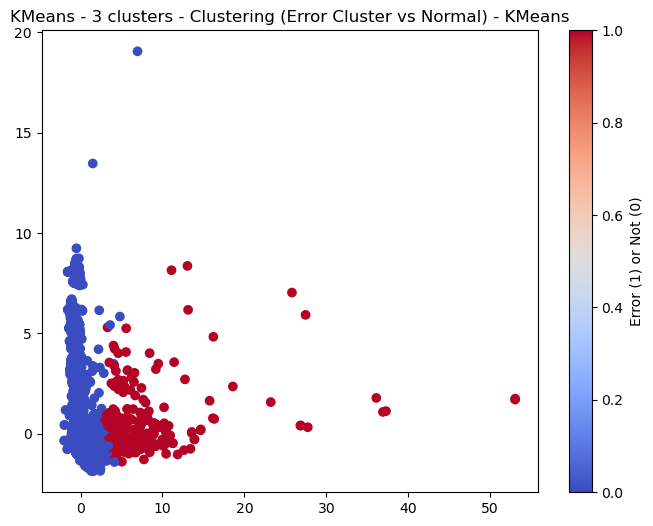


KMeans - 3 clusters, Error Cluster: 2
Accuracy: 0.1898
False Positives: 8569
False Negatives: 22
Percentage of Errors Correctly Identified: 96.36%
              precision    recall  f1-score   support

           0       0.98      0.14      0.25     10000
           1       0.06      0.96      0.12       604

    accuracy                           0.19     10604
   macro avg       0.52      0.55      0.18     10604
weighted avg       0.93      0.19      0.24     10604



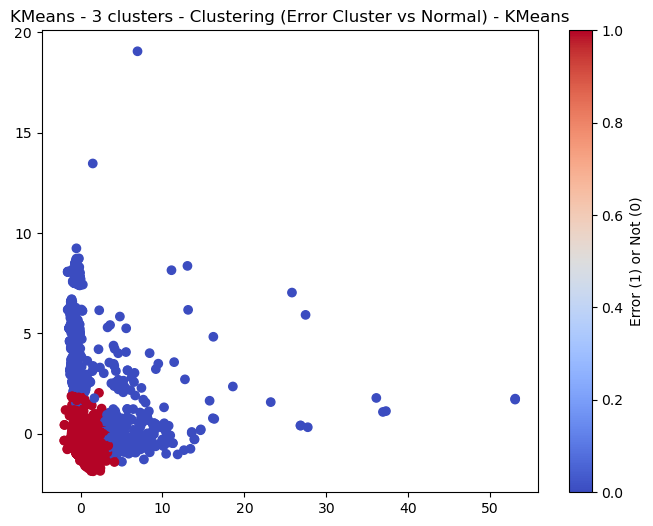


Evaluating with 4 clusters...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



KMeans - 4 clusters, Error Cluster: 0
Accuracy: 0.9239
False Positives: 203
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.92     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.92      0.91     10604



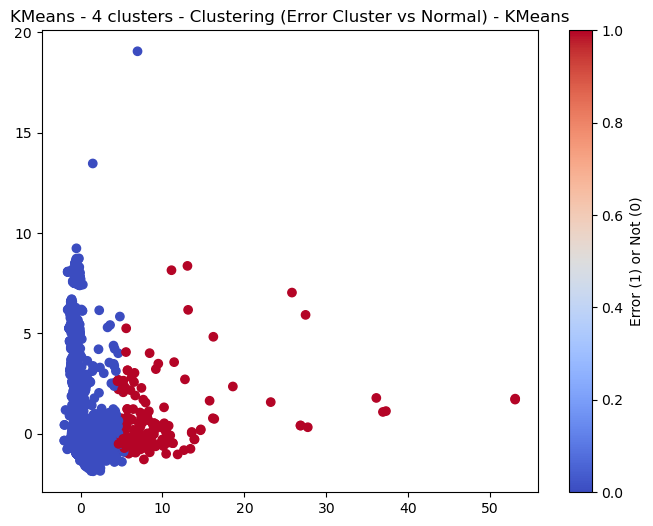


KMeans - 4 clusters, Error Cluster: 1
Accuracy: 0.5842
False Positives: 3815
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.91      0.62      0.74     10000
           1       0.00      0.02      0.00       604

    accuracy                           0.58     10604
   macro avg       0.46      0.32      0.37     10604
weighted avg       0.86      0.58      0.70     10604



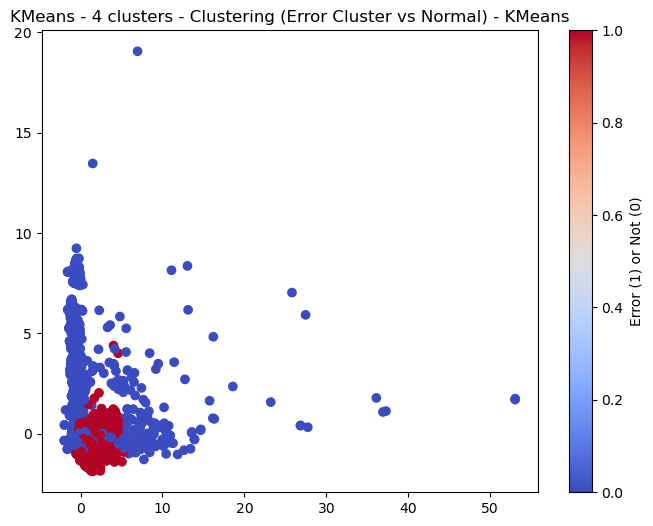


KMeans - 4 clusters, Error Cluster: 2
Accuracy: 0.5339
False Positives: 4915
False Negatives: 28
Percentage of Errors Correctly Identified: 95.36%
              precision    recall  f1-score   support

           0       0.99      0.51      0.67     10000
           1       0.10      0.95      0.19       604

    accuracy                           0.53     10604
   macro avg       0.55      0.73      0.43     10604
weighted avg       0.94      0.53      0.65     10604



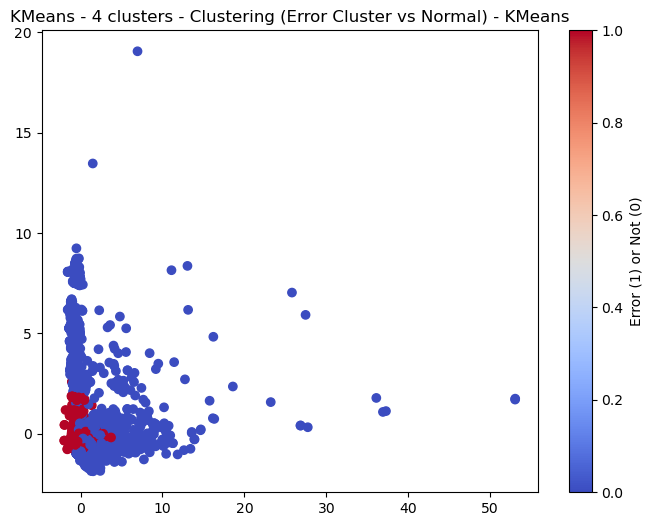


KMeans - 4 clusters, Error Cluster: 3
Accuracy: 0.8441
False Positives: 1067
False Negatives: 586
Percentage of Errors Correctly Identified: 2.98%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.02      0.03      0.02       604

    accuracy                           0.84     10604
   macro avg       0.48      0.46      0.47     10604
weighted avg       0.89      0.84      0.86     10604



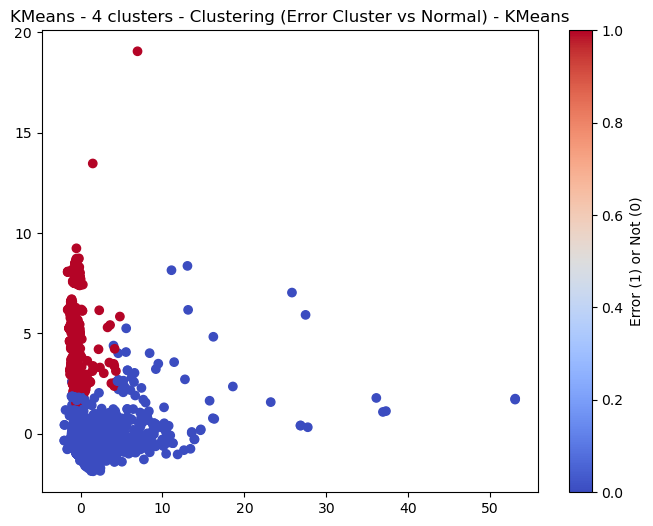


Evaluating with 5 clusters...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



KMeans - 5 clusters, Error Cluster: 0
Accuracy: 0.5453
False Positives: 4781
False Negatives: 41
Percentage of Errors Correctly Identified: 93.21%
              precision    recall  f1-score   support

           0       0.99      0.52      0.68     10000
           1       0.11      0.93      0.19       604

    accuracy                           0.55     10604
   macro avg       0.55      0.73      0.44     10604
weighted avg       0.94      0.55      0.66     10604



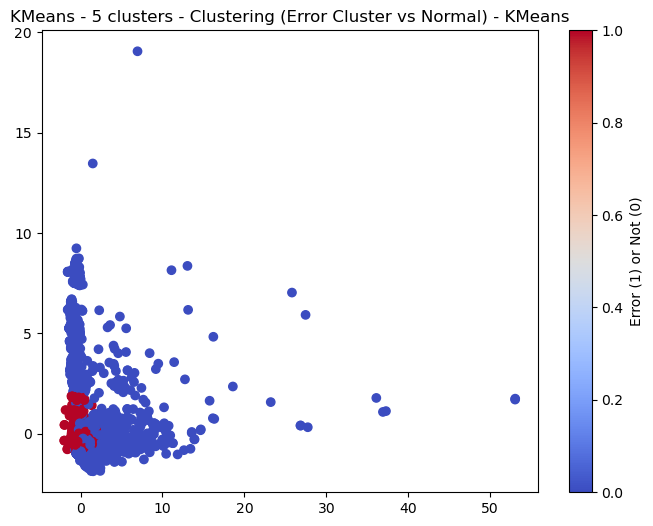


KMeans - 5 clusters, Error Cluster: 1
Accuracy: 0.9009
False Positives: 447
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.90     10604
   macro avg       0.47      0.48      0.47     10604
weighted avg       0.89      0.90      0.89     10604



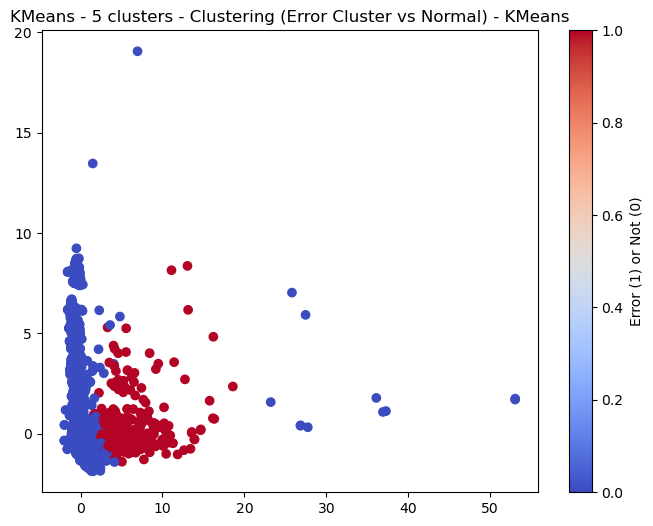


KMeans - 5 clusters, Error Cluster: 2
Accuracy: 0.5956
False Positives: 3703
False Negatives: 585
Percentage of Errors Correctly Identified: 3.15%
              precision    recall  f1-score   support

           0       0.91      0.63      0.75     10000
           1       0.01      0.03      0.01       604

    accuracy                           0.60     10604
   macro avg       0.46      0.33      0.38     10604
weighted avg       0.86      0.60      0.70     10604



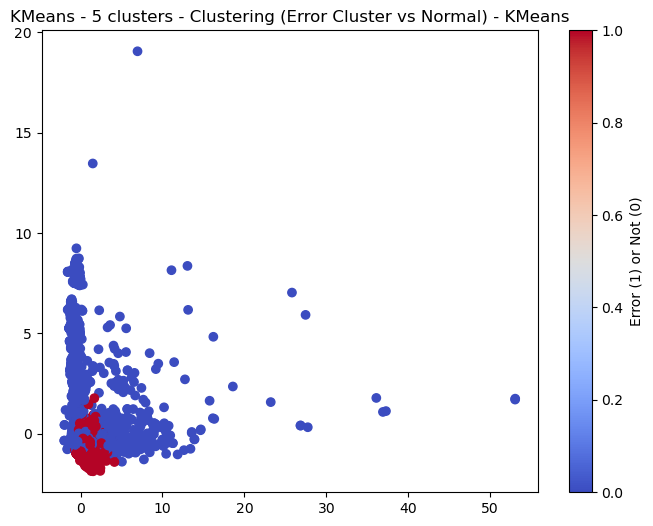


KMeans - 5 clusters, Error Cluster: 3
Accuracy: 0.8453
False Positives: 1058
False Negatives: 582
Percentage of Errors Correctly Identified: 3.64%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.02      0.04      0.03       604

    accuracy                           0.85     10604
   macro avg       0.48      0.47      0.47     10604
weighted avg       0.89      0.85      0.87     10604



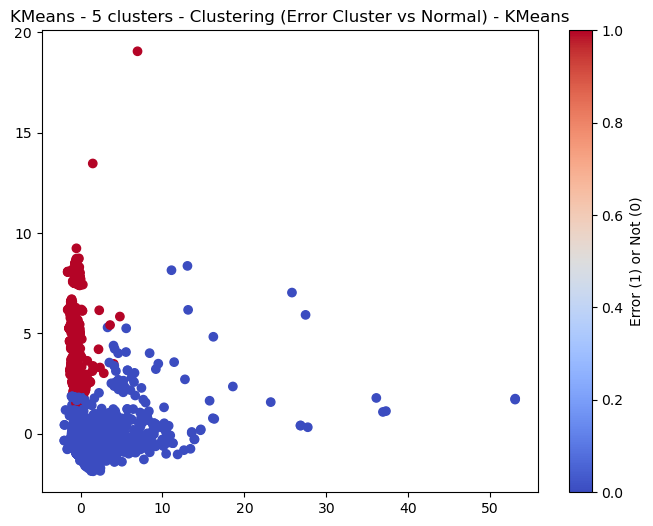


KMeans - 5 clusters, Error Cluster: 4
Accuracy: 0.9420
False Positives: 11
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



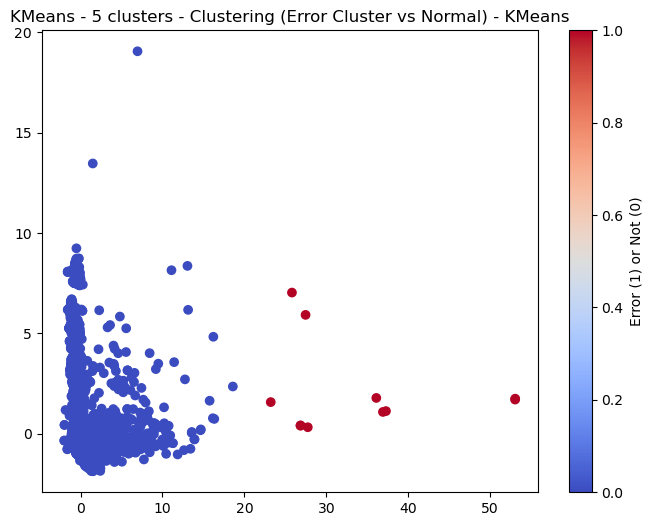


Evaluating with 6 clusters...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



KMeans - 6 clusters, Error Cluster: 0
Accuracy: 0.5960
False Positives: 3698
False Negatives: 586
Percentage of Errors Correctly Identified: 2.98%
              precision    recall  f1-score   support

           0       0.91      0.63      0.75     10000
           1       0.00      0.03      0.01       604

    accuracy                           0.60     10604
   macro avg       0.46      0.33      0.38     10604
weighted avg       0.86      0.60      0.70     10604



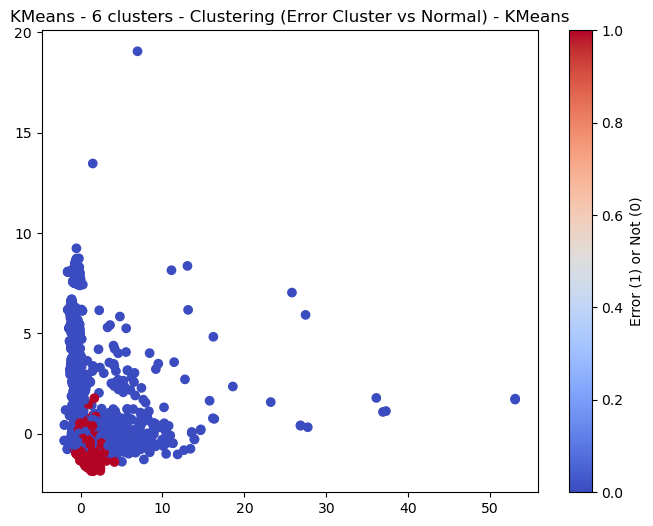


KMeans - 6 clusters, Error Cluster: 1
Accuracy: 0.9172
False Positives: 275
False Negatives: 603
Percentage of Errors Correctly Identified: 0.17%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.92     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.92      0.90     10604



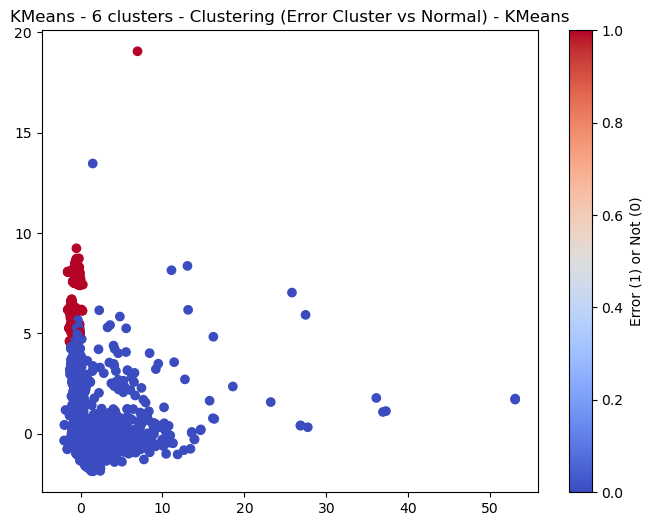


KMeans - 6 clusters, Error Cluster: 2
Accuracy: 0.8976
False Positives: 482
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.90     10604
   macro avg       0.47      0.48      0.47     10604
weighted avg       0.89      0.90      0.89     10604



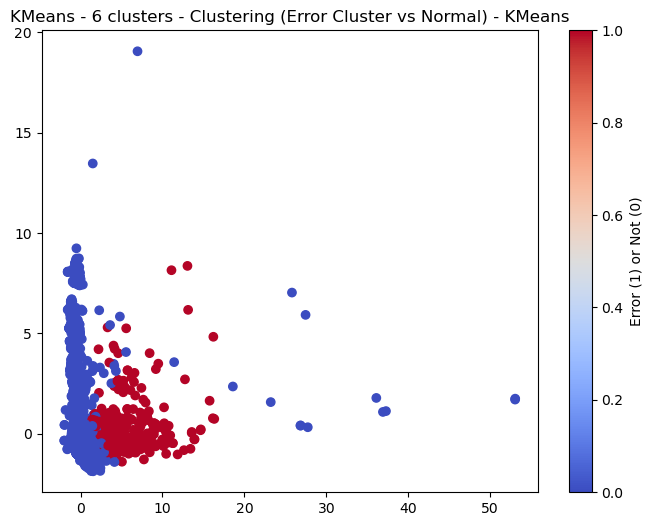


KMeans - 6 clusters, Error Cluster: 3
Accuracy: 0.5496
False Positives: 4742
False Negatives: 34
Percentage of Errors Correctly Identified: 94.37%
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     10000
           1       0.11      0.94      0.19       604

    accuracy                           0.55     10604
   macro avg       0.55      0.73      0.44     10604
weighted avg       0.94      0.55      0.66     10604



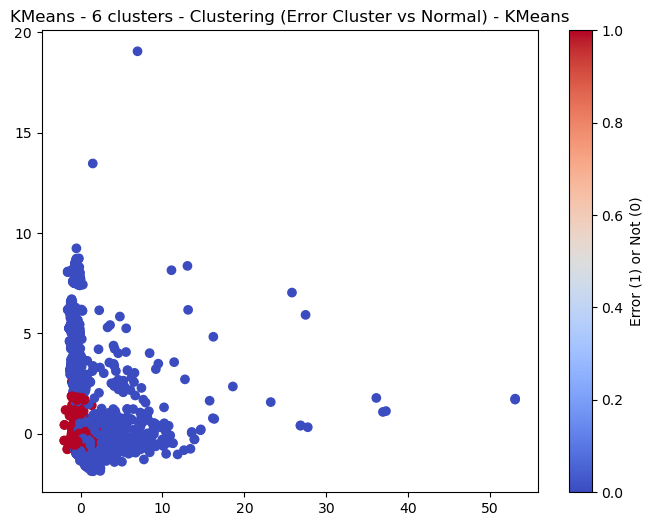


KMeans - 6 clusters, Error Cluster: 4
Accuracy: 0.8700
False Positives: 790
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10000
           1       0.02      0.02      0.02       604

    accuracy                           0.87     10604
   macro avg       0.48      0.47      0.48     10604
weighted avg       0.89      0.87      0.88     10604



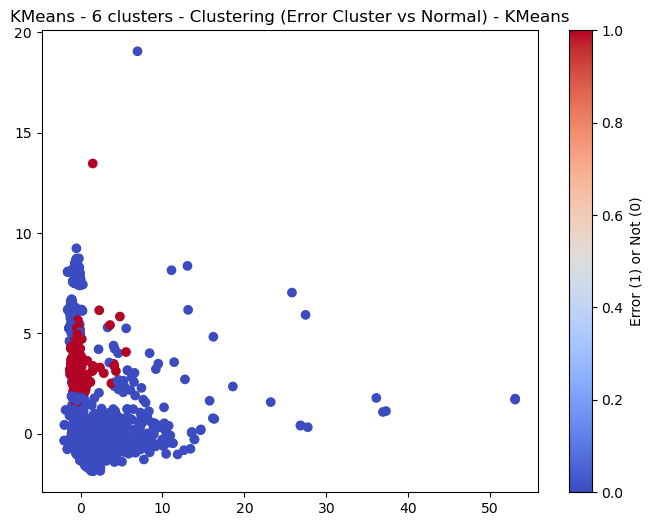


KMeans - 6 clusters, Error Cluster: 5
Accuracy: 0.9418
False Positives: 13
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



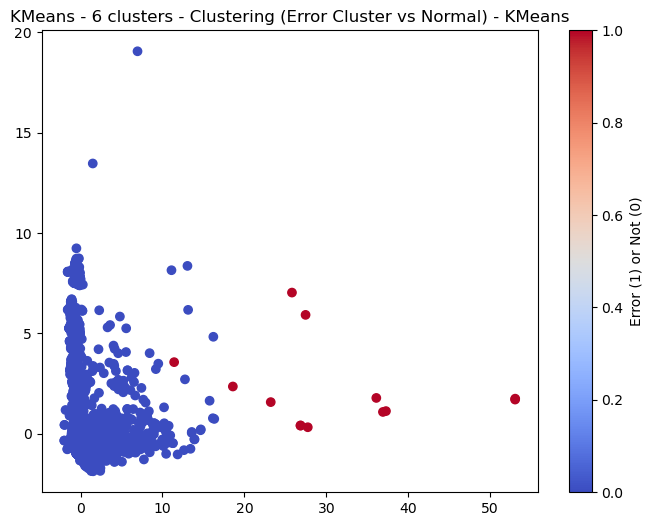


Evaluating with 7 clusters...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



KMeans - 7 clusters, Error Cluster: 0
Accuracy: 0.5962
False Positives: 3696
False Negatives: 586
Percentage of Errors Correctly Identified: 2.98%
              precision    recall  f1-score   support

           0       0.91      0.63      0.75     10000
           1       0.00      0.03      0.01       604

    accuracy                           0.60     10604
   macro avg       0.46      0.33      0.38     10604
weighted avg       0.86      0.60      0.70     10604



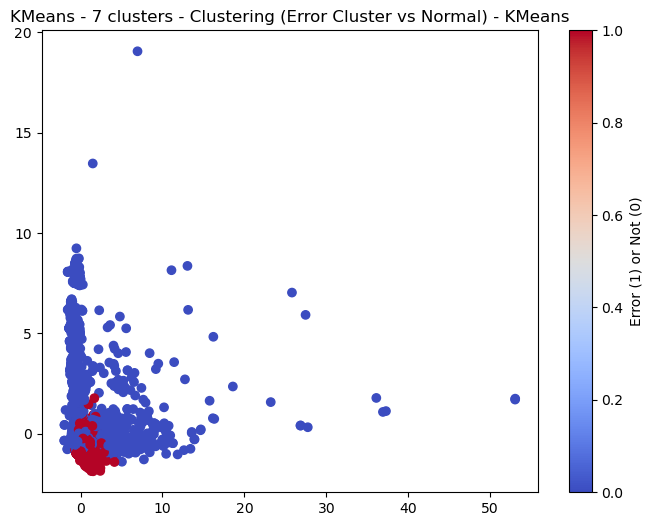


KMeans - 7 clusters, Error Cluster: 1
Accuracy: 0.8700
False Positives: 790
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10000
           1       0.02      0.02      0.02       604

    accuracy                           0.87     10604
   macro avg       0.48      0.47      0.48     10604
weighted avg       0.89      0.87      0.88     10604



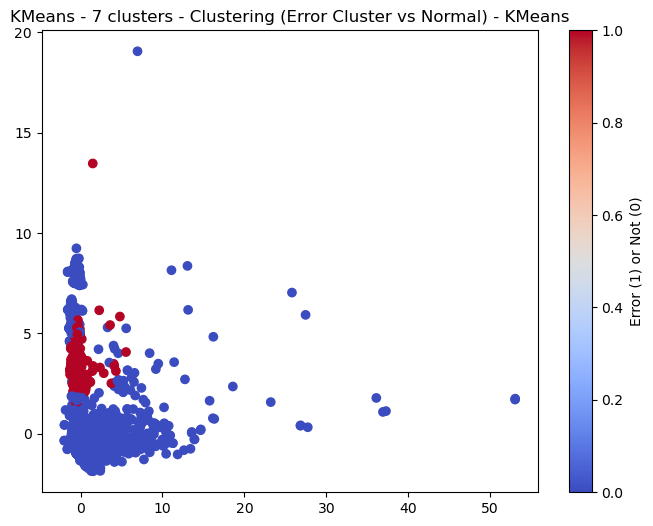


KMeans - 7 clusters, Error Cluster: 2
Accuracy: 0.8976
False Positives: 482
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.90     10604
   macro avg       0.47      0.48      0.47     10604
weighted avg       0.89      0.90      0.89     10604



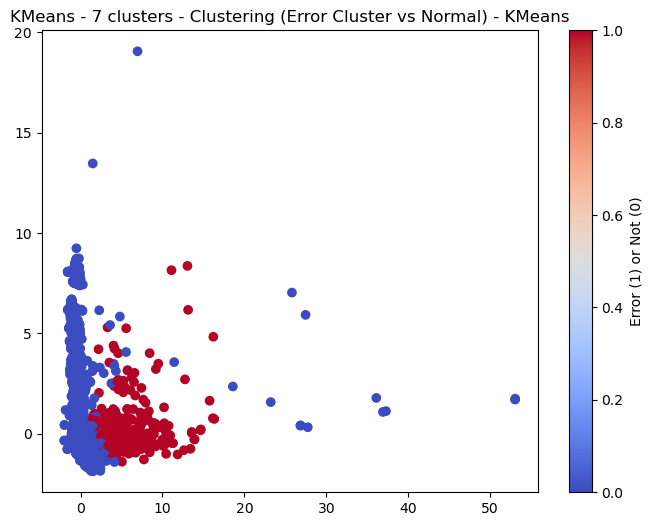


KMeans - 7 clusters, Error Cluster: 3
Accuracy: 0.5496
False Positives: 4742
False Negatives: 34
Percentage of Errors Correctly Identified: 94.37%
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     10000
           1       0.11      0.94      0.19       604

    accuracy                           0.55     10604
   macro avg       0.55      0.73      0.44     10604
weighted avg       0.94      0.55      0.66     10604



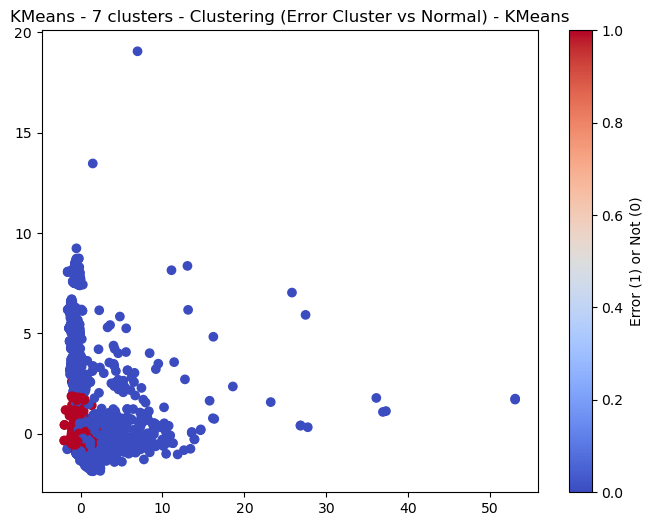


KMeans - 7 clusters, Error Cluster: 4
Accuracy: 0.9429
False Positives: 2
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



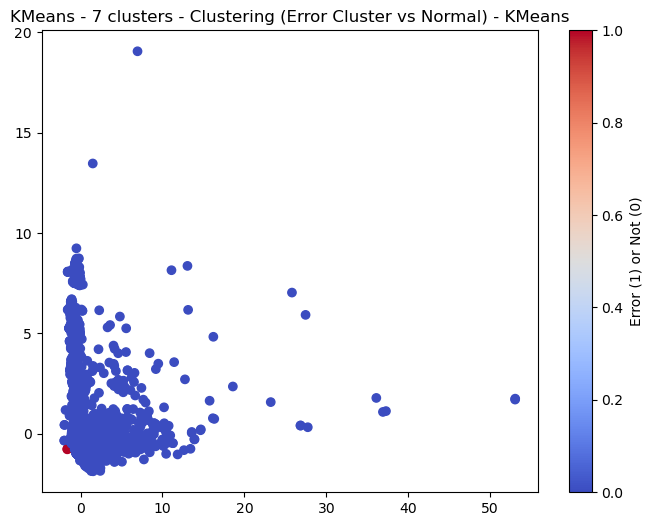


KMeans - 7 clusters, Error Cluster: 5
Accuracy: 0.9172
False Positives: 275
False Negatives: 603
Percentage of Errors Correctly Identified: 0.17%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.92     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.92      0.90     10604



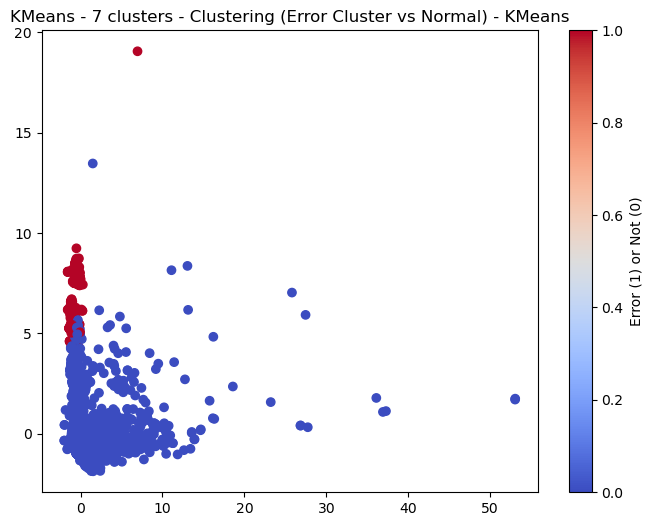


KMeans - 7 clusters, Error Cluster: 6
Accuracy: 0.9418
False Positives: 13
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



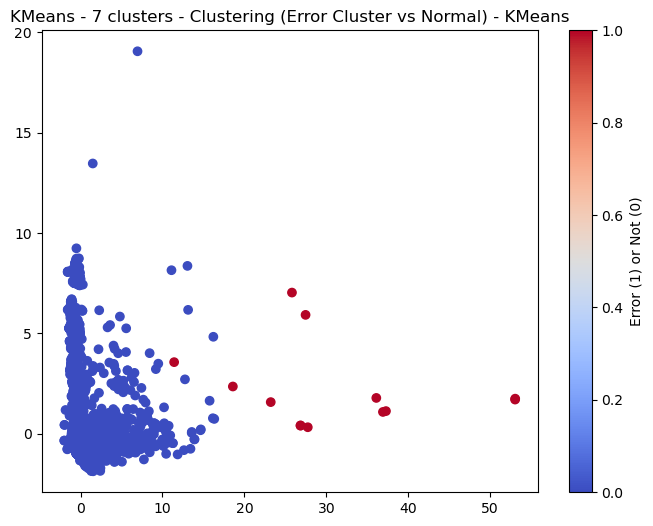


Evaluating with 2 clusters...

DBSCAN - 2 clusters, Error Cluster: 0
Accuracy: 0.9437
False Positives: 0
False Negatives: 597
Percentage of Errors Correctly Identified: 1.16%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       1.00      0.01      0.02       604

    accuracy                           0.94     10604
   macro avg       0.97      0.51      0.50     10604
weighted avg       0.95      0.94      0.92     10604



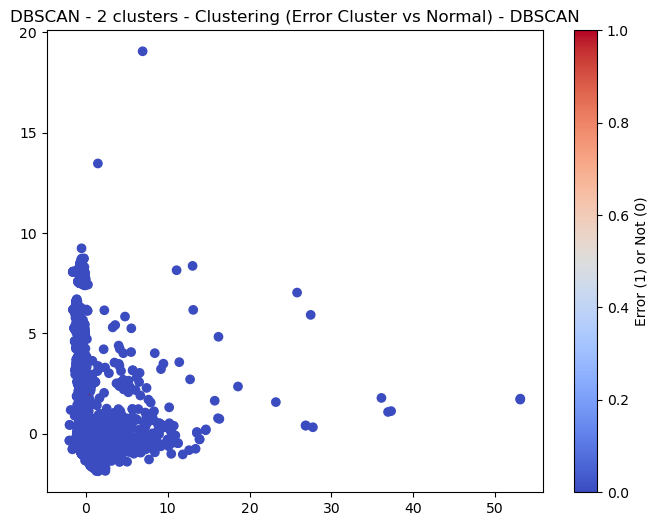


DBSCAN - 2 clusters, Error Cluster: 1
Accuracy: 0.9401
False Positives: 31
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



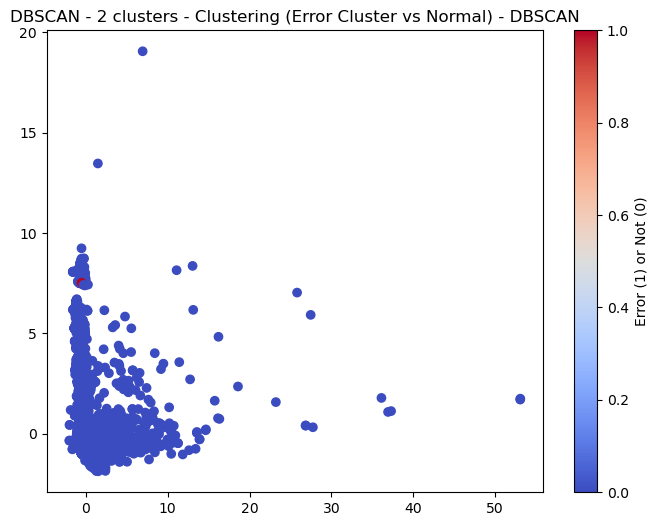


Evaluating with 3 clusters...

DBSCAN - 3 clusters, Error Cluster: 0
Accuracy: 0.9437
False Positives: 0
False Negatives: 597
Percentage of Errors Correctly Identified: 1.16%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       1.00      0.01      0.02       604

    accuracy                           0.94     10604
   macro avg       0.97      0.51      0.50     10604
weighted avg       0.95      0.94      0.92     10604



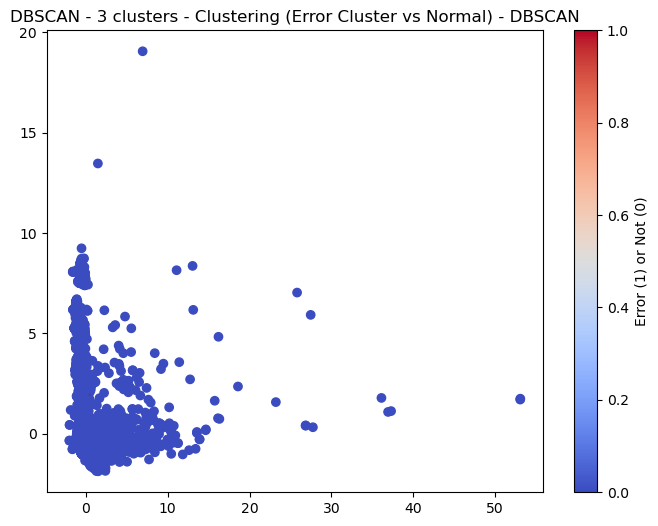


DBSCAN - 3 clusters, Error Cluster: 1
Accuracy: 0.9401
False Positives: 31
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



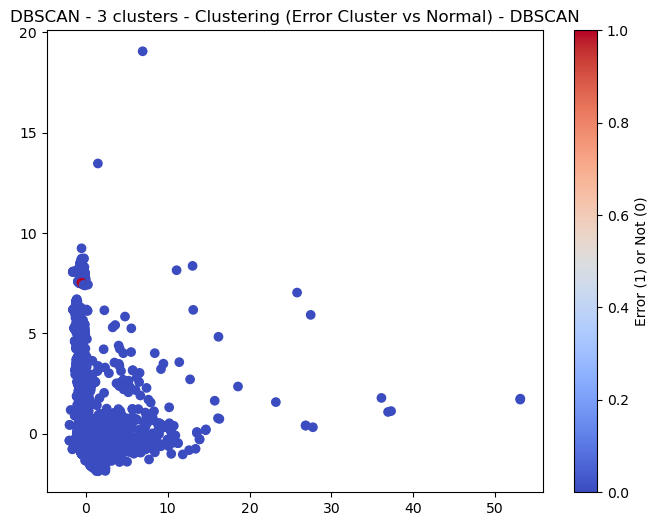


DBSCAN - 3 clusters, Error Cluster: 2
Accuracy: 0.9423
False Positives: 8
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



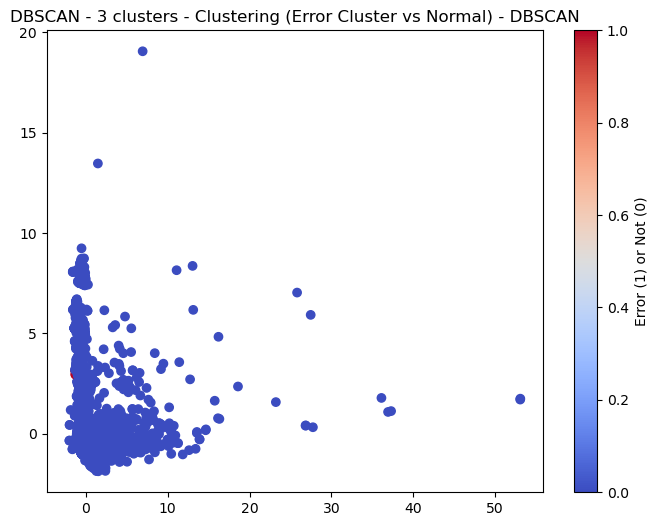


Evaluating with 4 clusters...

DBSCAN - 4 clusters, Error Cluster: 0
Accuracy: 0.9437
False Positives: 0
False Negatives: 597
Percentage of Errors Correctly Identified: 1.16%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       1.00      0.01      0.02       604

    accuracy                           0.94     10604
   macro avg       0.97      0.51      0.50     10604
weighted avg       0.95      0.94      0.92     10604



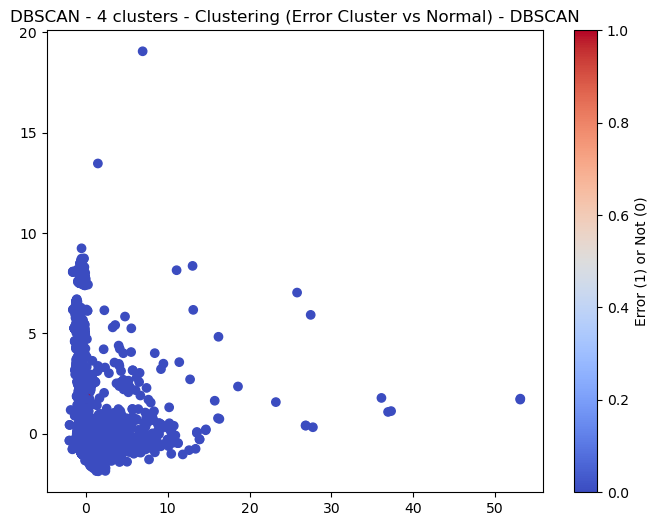


DBSCAN - 4 clusters, Error Cluster: 1
Accuracy: 0.9401
False Positives: 31
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



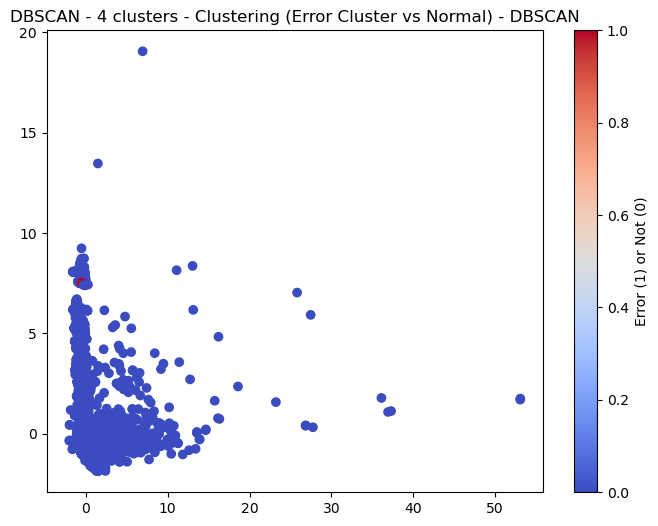


DBSCAN - 4 clusters, Error Cluster: 2
Accuracy: 0.9423
False Positives: 8
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



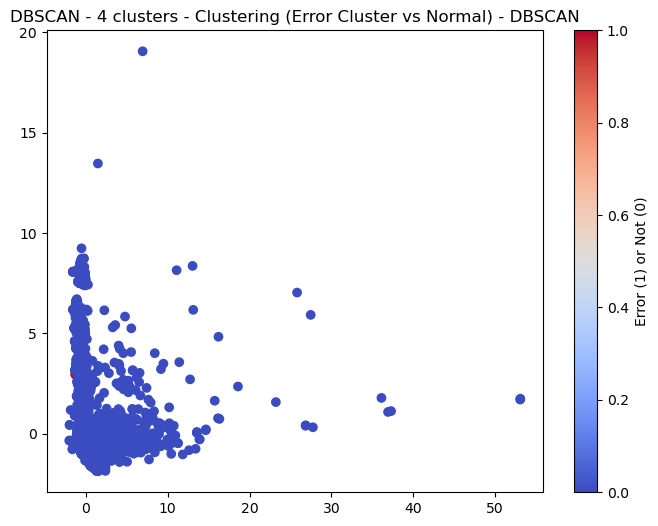


DBSCAN - 4 clusters, Error Cluster: 3
Accuracy: 0.6635
False Positives: 3068
False Negatives: 500
Percentage of Errors Correctly Identified: 17.22%
              precision    recall  f1-score   support

           0       0.93      0.69      0.80     10000
           1       0.03      0.17      0.06       604

    accuracy                           0.66     10604
   macro avg       0.48      0.43      0.43     10604
weighted avg       0.88      0.66      0.75     10604



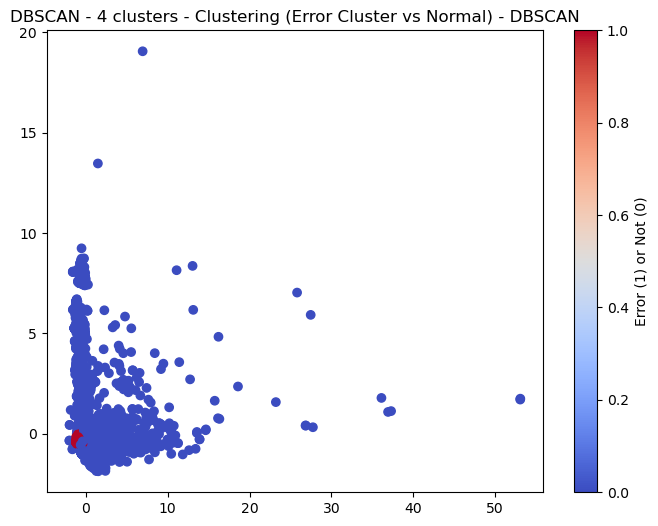


Evaluating with 5 clusters...

DBSCAN - 5 clusters, Error Cluster: 0
Accuracy: 0.9437
False Positives: 0
False Negatives: 597
Percentage of Errors Correctly Identified: 1.16%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       1.00      0.01      0.02       604

    accuracy                           0.94     10604
   macro avg       0.97      0.51      0.50     10604
weighted avg       0.95      0.94      0.92     10604



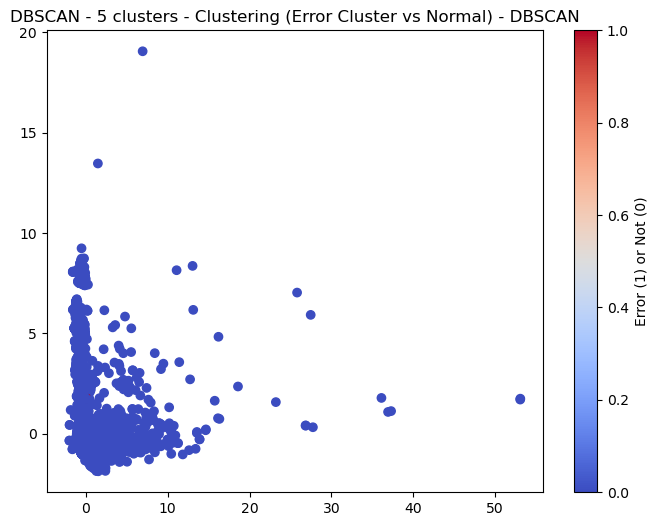


DBSCAN - 5 clusters, Error Cluster: 1
Accuracy: 0.9401
False Positives: 31
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



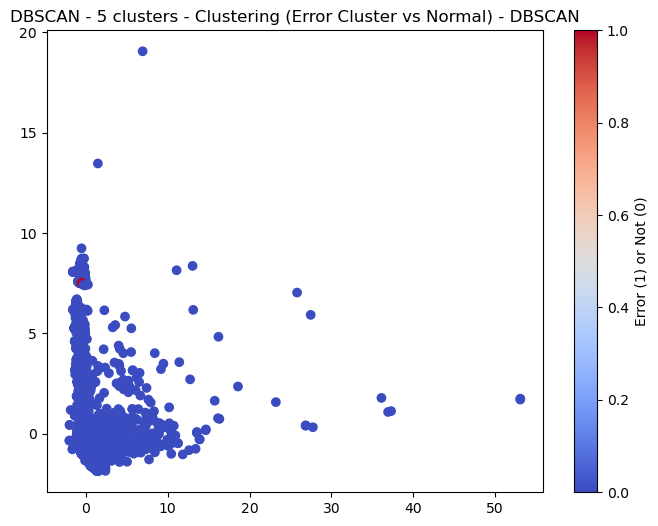


DBSCAN - 5 clusters, Error Cluster: 2
Accuracy: 0.9423
False Positives: 8
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



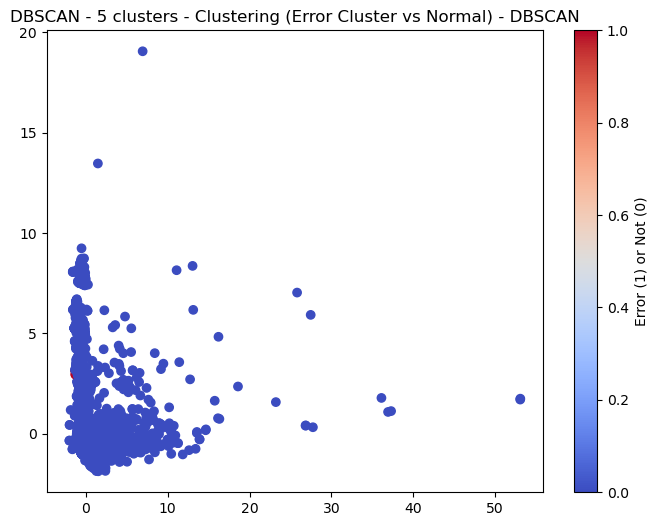


DBSCAN - 5 clusters, Error Cluster: 3
Accuracy: 0.6635
False Positives: 3068
False Negatives: 500
Percentage of Errors Correctly Identified: 17.22%
              precision    recall  f1-score   support

           0       0.93      0.69      0.80     10000
           1       0.03      0.17      0.06       604

    accuracy                           0.66     10604
   macro avg       0.48      0.43      0.43     10604
weighted avg       0.88      0.66      0.75     10604



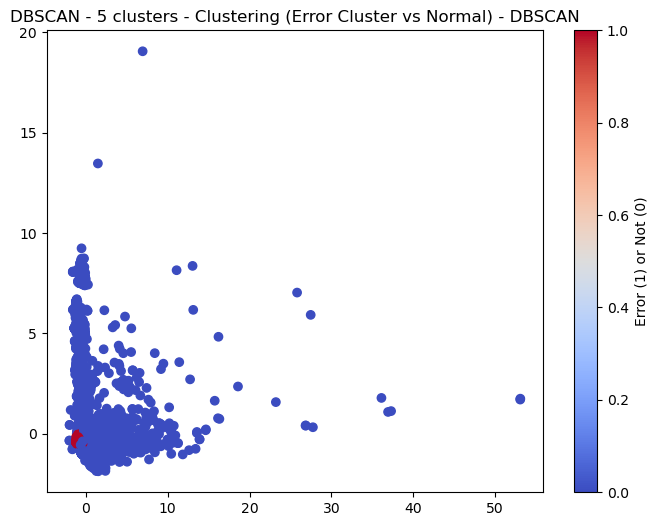


DBSCAN - 5 clusters, Error Cluster: 4
Accuracy: 0.8763
False Positives: 718
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.88     10604
   macro avg       0.48      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



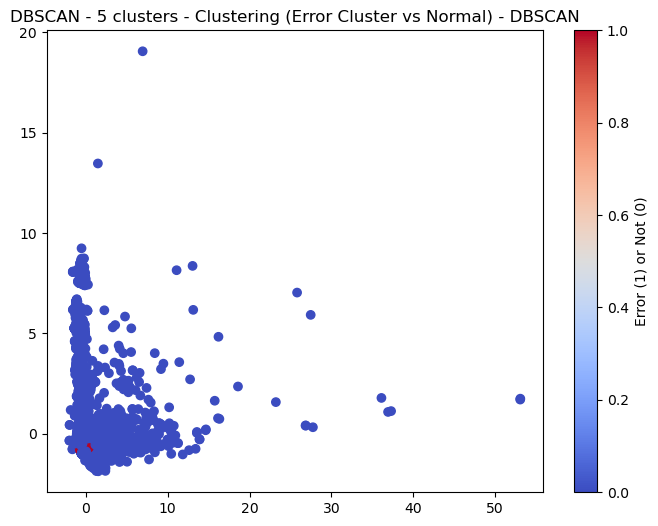


Evaluating with 6 clusters...

DBSCAN - 6 clusters, Error Cluster: 0
Accuracy: 0.9437
False Positives: 0
False Negatives: 597
Percentage of Errors Correctly Identified: 1.16%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       1.00      0.01      0.02       604

    accuracy                           0.94     10604
   macro avg       0.97      0.51      0.50     10604
weighted avg       0.95      0.94      0.92     10604



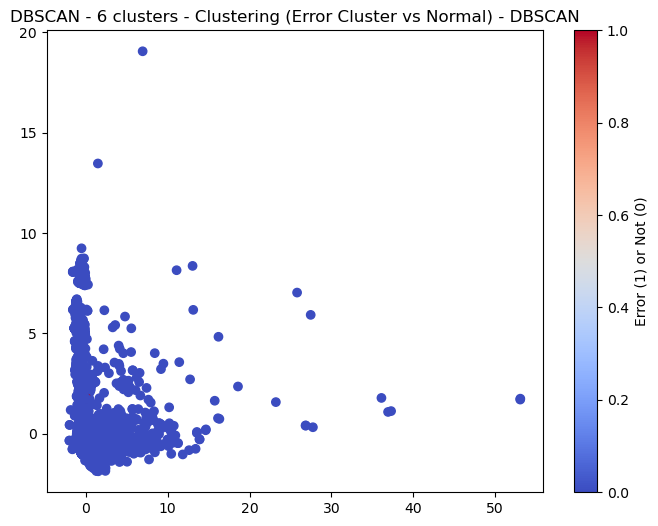


DBSCAN - 6 clusters, Error Cluster: 1
Accuracy: 0.9401
False Positives: 31
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



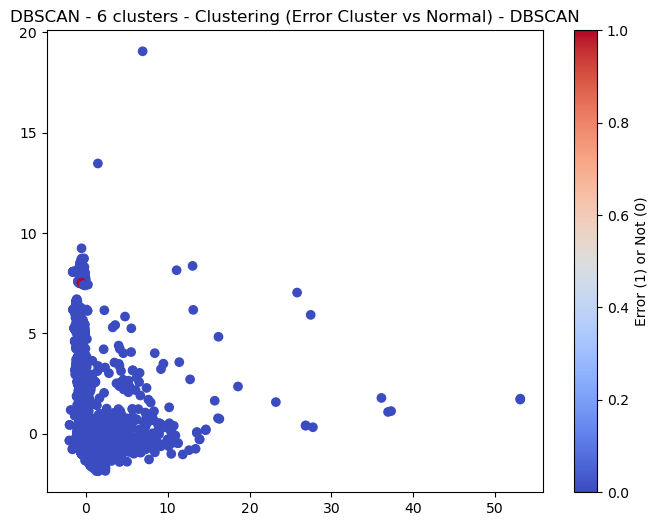


DBSCAN - 6 clusters, Error Cluster: 2
Accuracy: 0.9423
False Positives: 8
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



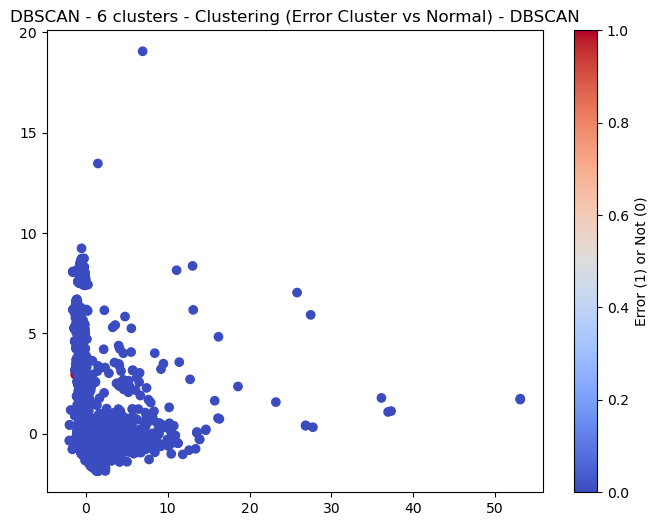


DBSCAN - 6 clusters, Error Cluster: 3
Accuracy: 0.6635
False Positives: 3068
False Negatives: 500
Percentage of Errors Correctly Identified: 17.22%
              precision    recall  f1-score   support

           0       0.93      0.69      0.80     10000
           1       0.03      0.17      0.06       604

    accuracy                           0.66     10604
   macro avg       0.48      0.43      0.43     10604
weighted avg       0.88      0.66      0.75     10604



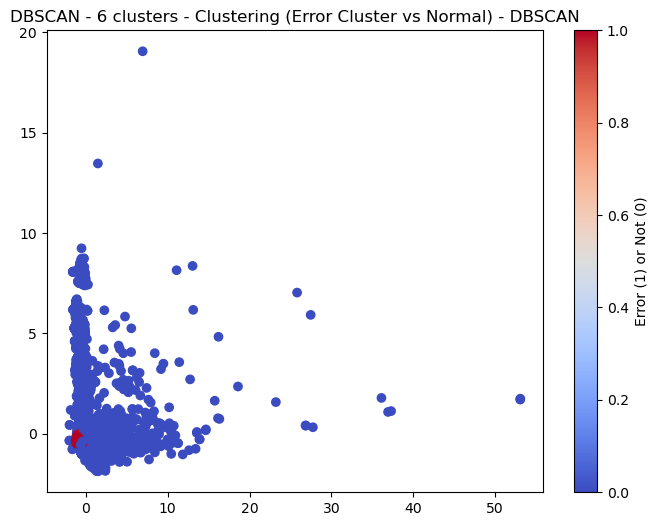


DBSCAN - 6 clusters, Error Cluster: 4
Accuracy: 0.8763
False Positives: 718
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.88     10604
   macro avg       0.48      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



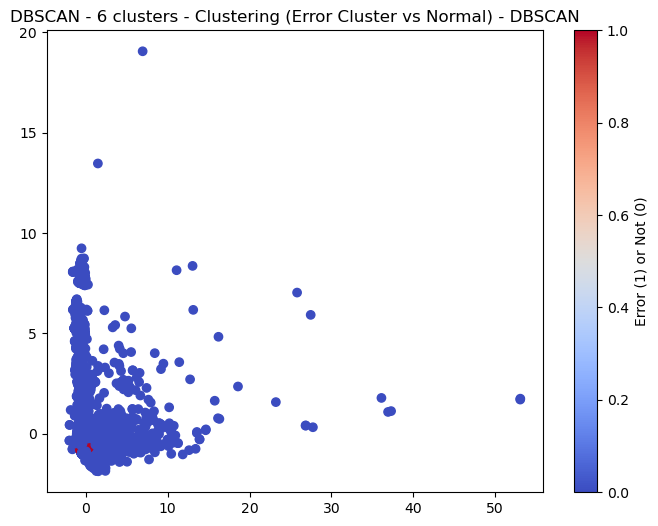


DBSCAN - 6 clusters, Error Cluster: 5
Accuracy: 0.9057
False Positives: 467
False Negatives: 533
Percentage of Errors Correctly Identified: 11.75%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.13      0.12      0.12       604

    accuracy                           0.91     10604
   macro avg       0.54      0.54      0.54     10604
weighted avg       0.90      0.91      0.90     10604



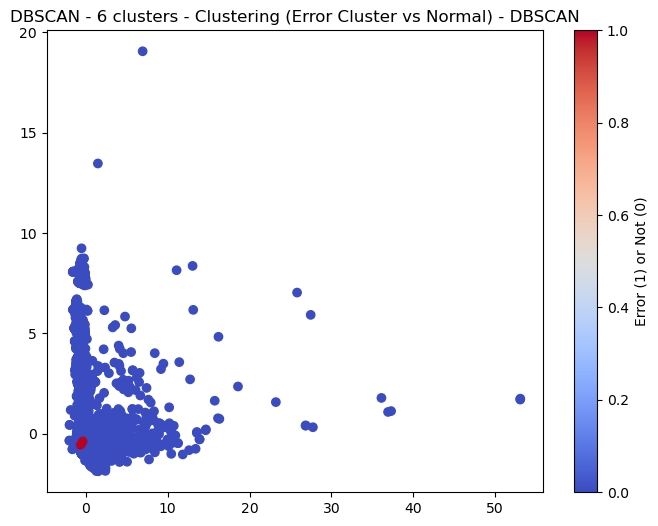


Evaluating with 7 clusters...

DBSCAN - 7 clusters, Error Cluster: 0
Accuracy: 0.9437
False Positives: 0
False Negatives: 597
Percentage of Errors Correctly Identified: 1.16%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       1.00      0.01      0.02       604

    accuracy                           0.94     10604
   macro avg       0.97      0.51      0.50     10604
weighted avg       0.95      0.94      0.92     10604



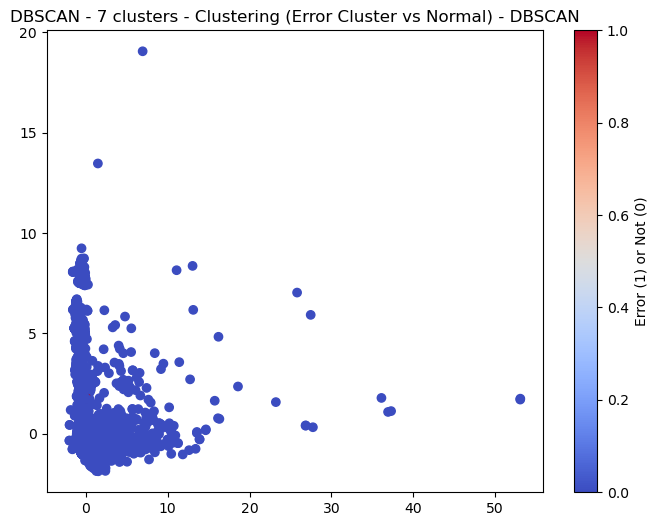


DBSCAN - 7 clusters, Error Cluster: 1
Accuracy: 0.9401
False Positives: 31
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



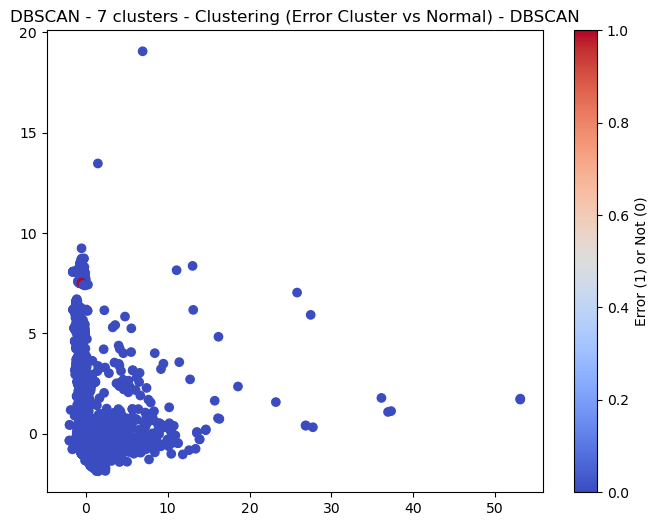


DBSCAN - 7 clusters, Error Cluster: 2
Accuracy: 0.9423
False Positives: 8
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



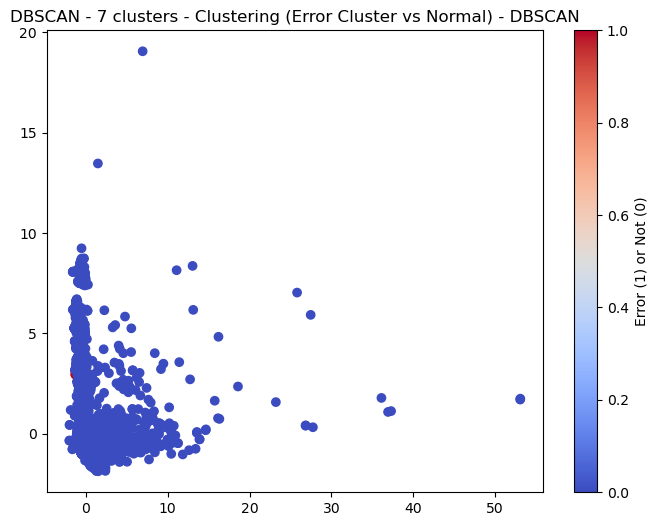


DBSCAN - 7 clusters, Error Cluster: 3
Accuracy: 0.6635
False Positives: 3068
False Negatives: 500
Percentage of Errors Correctly Identified: 17.22%
              precision    recall  f1-score   support

           0       0.93      0.69      0.80     10000
           1       0.03      0.17      0.06       604

    accuracy                           0.66     10604
   macro avg       0.48      0.43      0.43     10604
weighted avg       0.88      0.66      0.75     10604



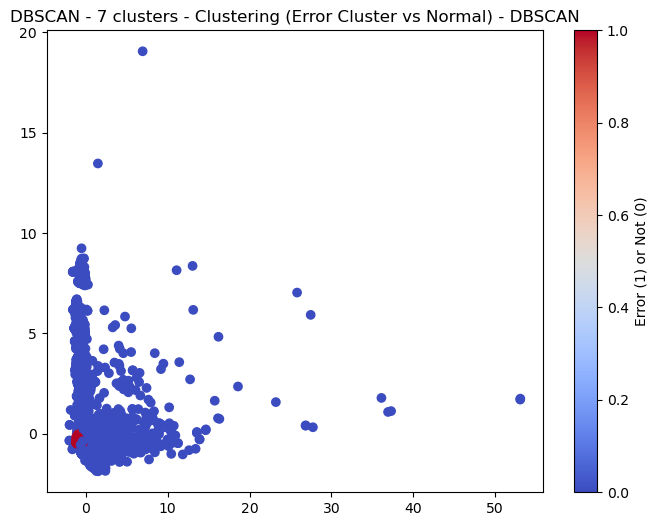


DBSCAN - 7 clusters, Error Cluster: 4
Accuracy: 0.8763
False Positives: 718
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.88     10604
   macro avg       0.48      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



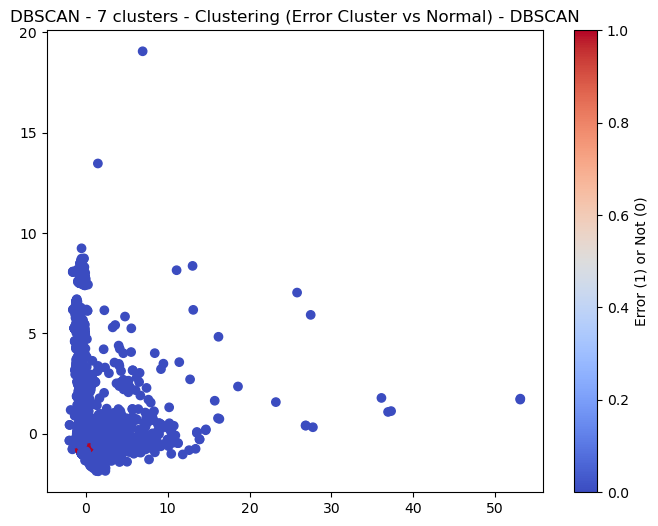


DBSCAN - 7 clusters, Error Cluster: 5
Accuracy: 0.9057
False Positives: 467
False Negatives: 533
Percentage of Errors Correctly Identified: 11.75%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.13      0.12      0.12       604

    accuracy                           0.91     10604
   macro avg       0.54      0.54      0.54     10604
weighted avg       0.90      0.91      0.90     10604



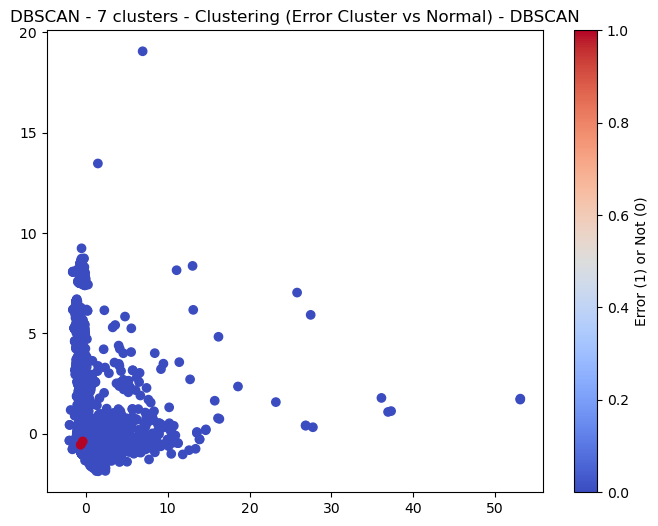


DBSCAN - 7 clusters, Error Cluster: 6
Accuracy: 0.7721
False Positives: 1813
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.77     10604
   macro avg       0.47      0.41      0.44     10604
weighted avg       0.88      0.77      0.82     10604



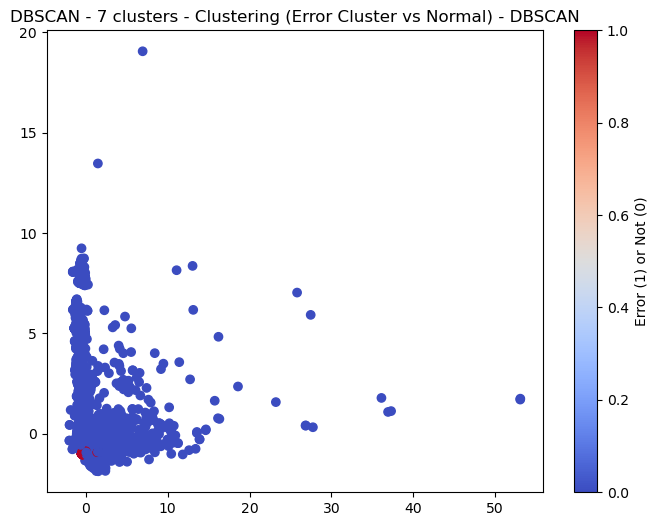


Evaluating with 2 clusters...

Agglomerative Clustering - 2 clusters, Error Cluster: 0
Accuracy: 0.1560
False Positives: 8935
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       0.99      0.11      0.19     10000
           1       0.06      0.98      0.12       604

    accuracy                           0.16     10604
   macro avg       0.52      0.54      0.15     10604
weighted avg       0.93      0.16      0.19     10604



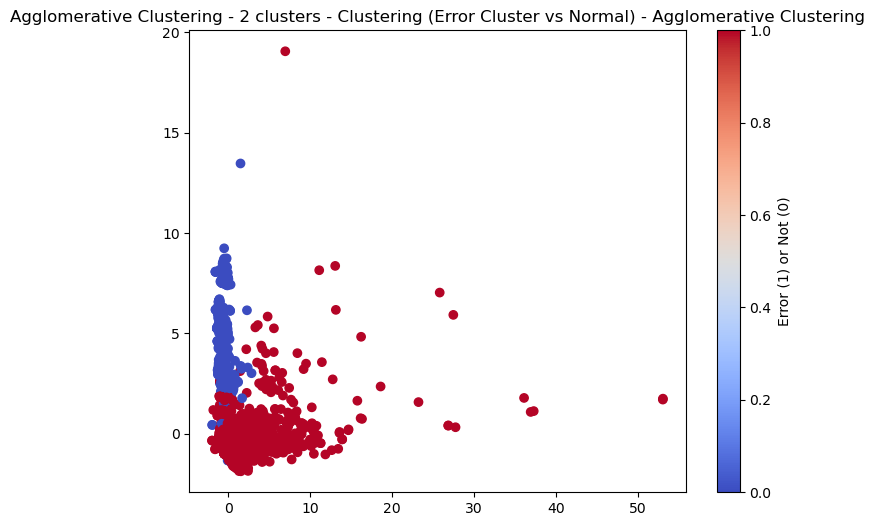


Agglomerative Clustering - 2 clusters, Error Cluster: 1
Accuracy: 0.8440
False Positives: 1065
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.84     10604
   macro avg       0.48      0.46      0.47     10604
weighted avg       0.89      0.84      0.86     10604



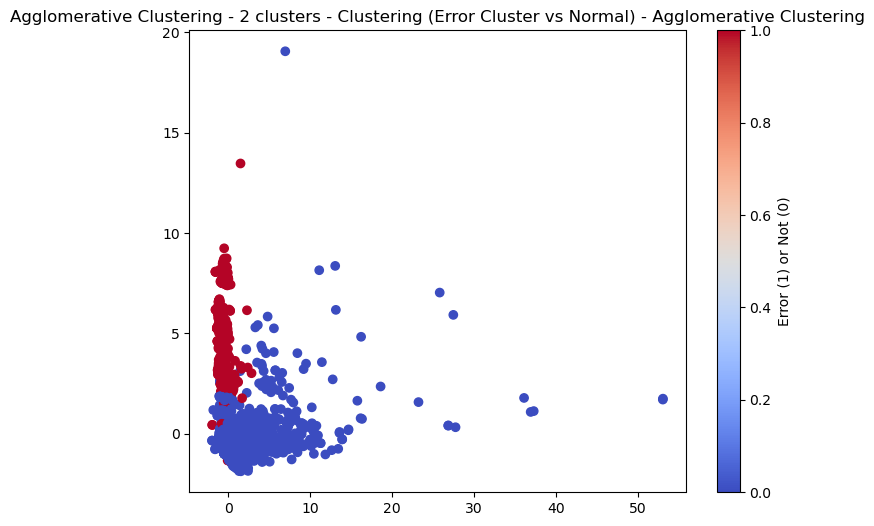


Evaluating with 3 clusters...

Agglomerative Clustering - 3 clusters, Error Cluster: 0
Accuracy: 0.1571
False Positives: 8923
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       0.99      0.11      0.19     10000
           1       0.06      0.98      0.12       604

    accuracy                           0.16     10604
   macro avg       0.52      0.54      0.16     10604
weighted avg       0.93      0.16      0.19     10604



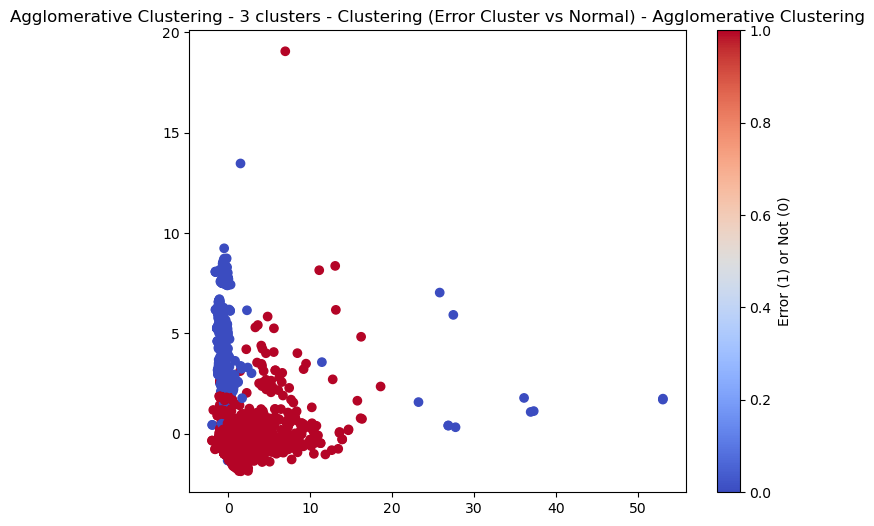


Agglomerative Clustering - 3 clusters, Error Cluster: 1
Accuracy: 0.8440
False Positives: 1065
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.84     10604
   macro avg       0.48      0.46      0.47     10604
weighted avg       0.89      0.84      0.86     10604



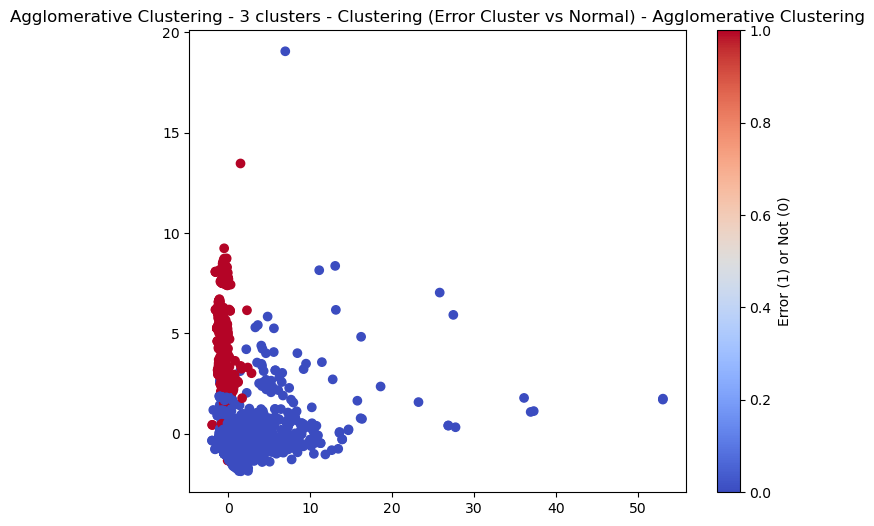


Agglomerative Clustering - 3 clusters, Error Cluster: 2
Accuracy: 0.9419
False Positives: 12
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



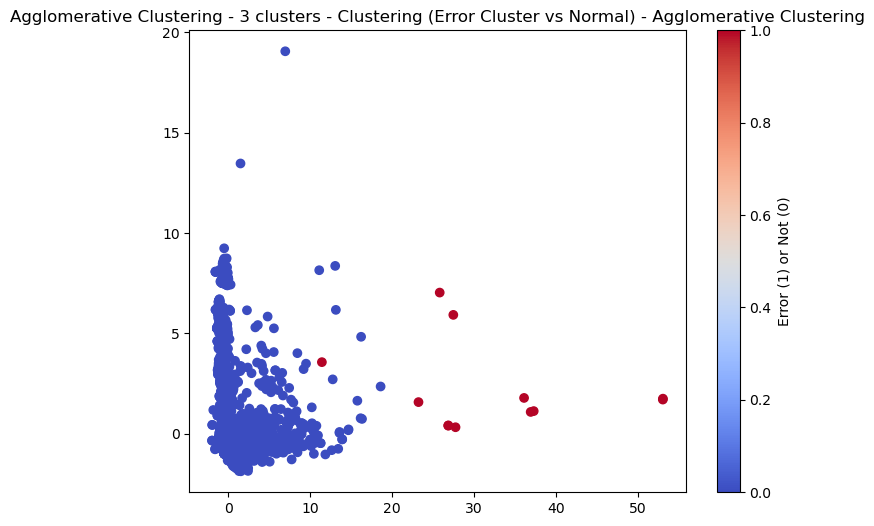


Evaluating with 4 clusters...

Agglomerative Clustering - 4 clusters, Error Cluster: 0
Accuracy: 0.9419
False Positives: 12
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



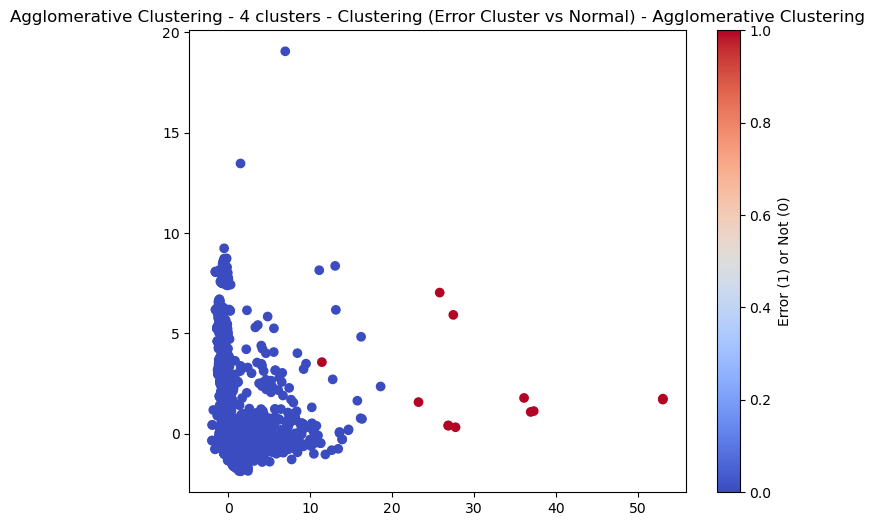


Agglomerative Clustering - 4 clusters, Error Cluster: 1
Accuracy: 0.4808
False Positives: 5491
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       1.00      0.45      0.62     10000
           1       0.10      0.98      0.18       604

    accuracy                           0.48     10604
   macro avg       0.55      0.71      0.40     10604
weighted avg       0.95      0.48      0.60     10604



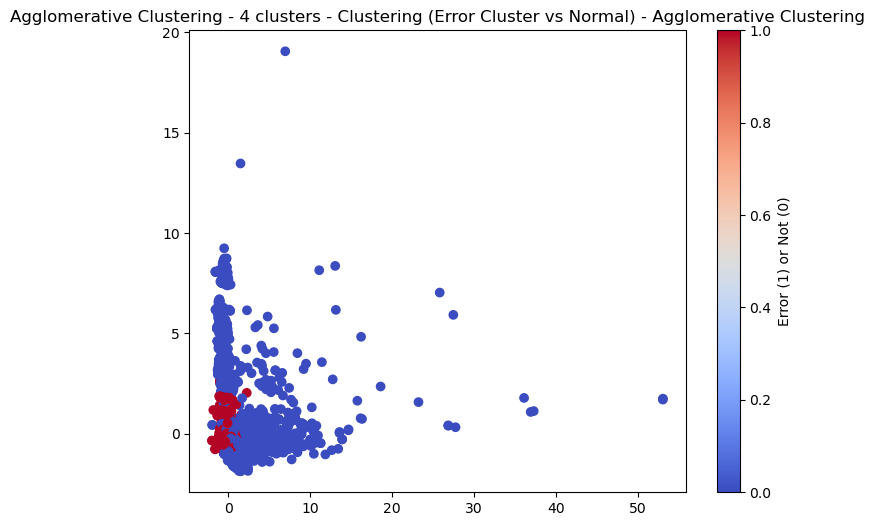


Agglomerative Clustering - 4 clusters, Error Cluster: 2
Accuracy: 0.6194
False Positives: 3432
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.92      0.66      0.76     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.62     10604
   macro avg       0.46      0.33      0.38     10604
weighted avg       0.86      0.62      0.72     10604



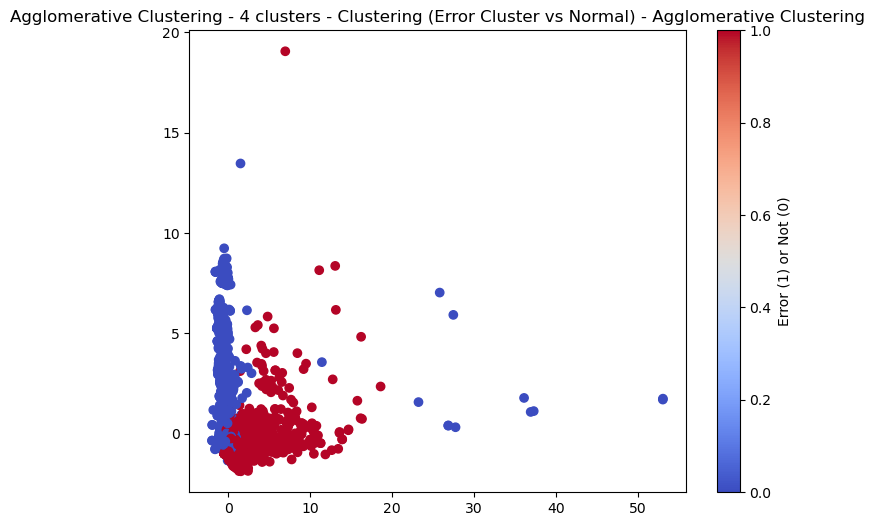


Agglomerative Clustering - 4 clusters, Error Cluster: 3
Accuracy: 0.8440
False Positives: 1065
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.84     10604
   macro avg       0.48      0.46      0.47     10604
weighted avg       0.89      0.84      0.86     10604



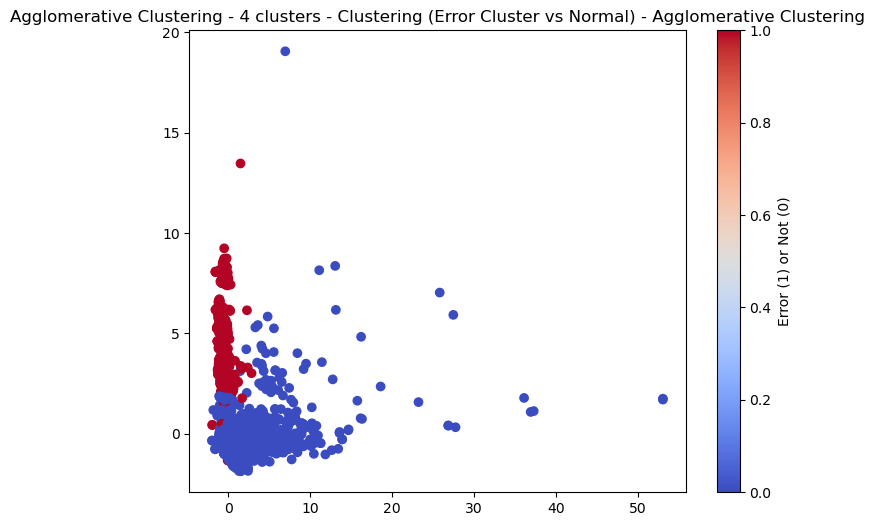


Evaluating with 5 clusters...

Agglomerative Clustering - 5 clusters, Error Cluster: 0
Accuracy: 0.6194
False Positives: 3432
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.92      0.66      0.76     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.62     10604
   macro avg       0.46      0.33      0.38     10604
weighted avg       0.86      0.62      0.72     10604



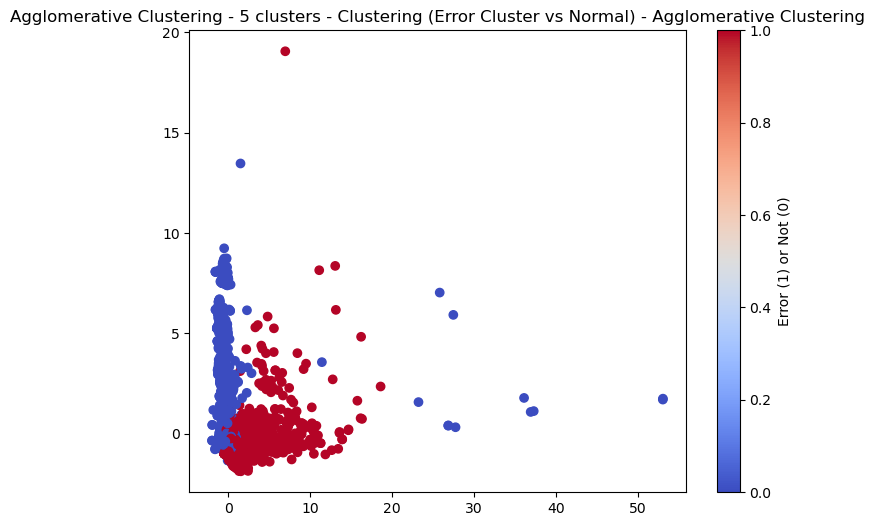


Agglomerative Clustering - 5 clusters, Error Cluster: 1
Accuracy: 0.4808
False Positives: 5491
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       1.00      0.45      0.62     10000
           1       0.10      0.98      0.18       604

    accuracy                           0.48     10604
   macro avg       0.55      0.71      0.40     10604
weighted avg       0.95      0.48      0.60     10604



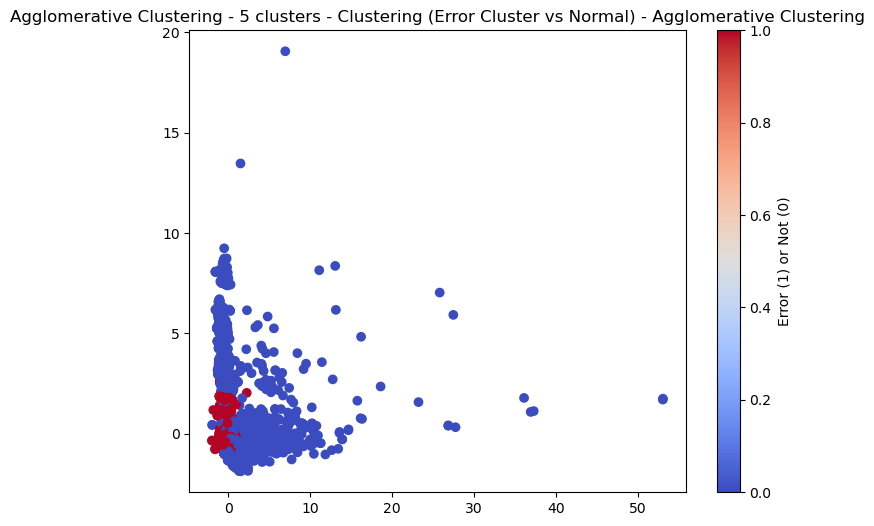


Agglomerative Clustering - 5 clusters, Error Cluster: 2
Accuracy: 0.9420
False Positives: 11
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



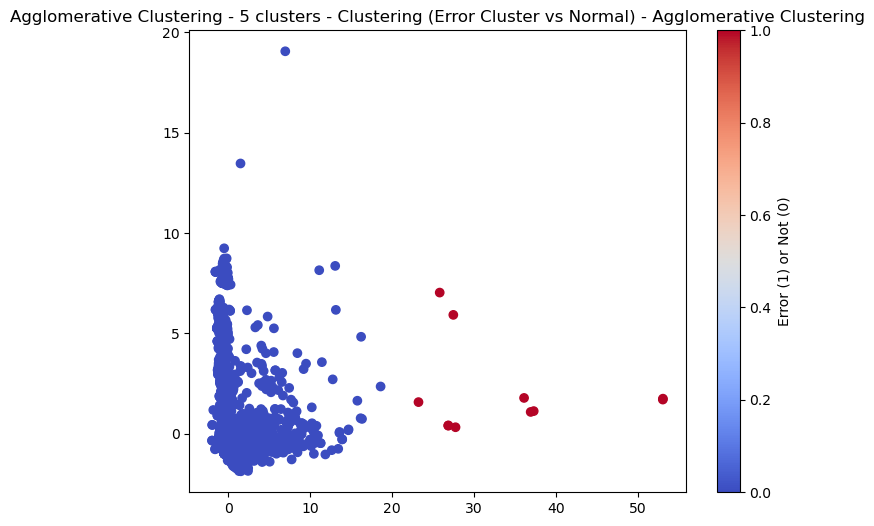


Agglomerative Clustering - 5 clusters, Error Cluster: 3
Accuracy: 0.8440
False Positives: 1065
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.84     10604
   macro avg       0.48      0.46      0.47     10604
weighted avg       0.89      0.84      0.86     10604



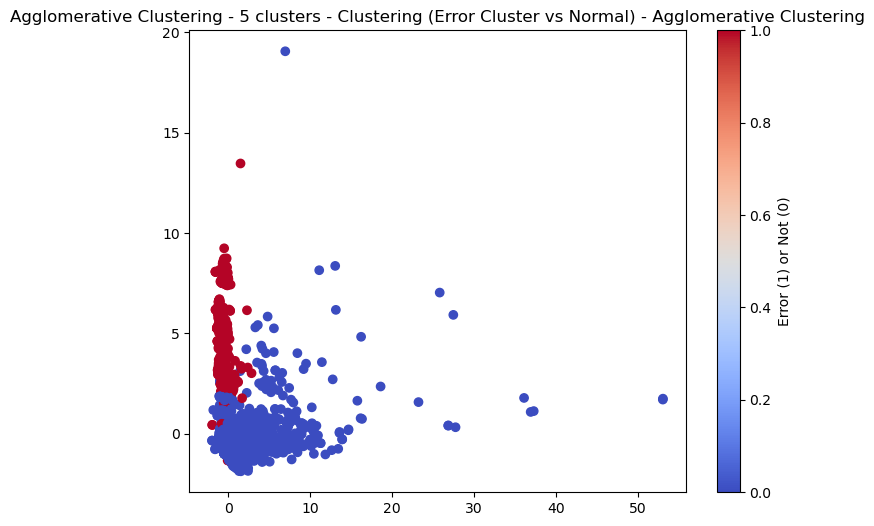


Agglomerative Clustering - 5 clusters, Error Cluster: 4
Accuracy: 0.9429
False Positives: 1
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



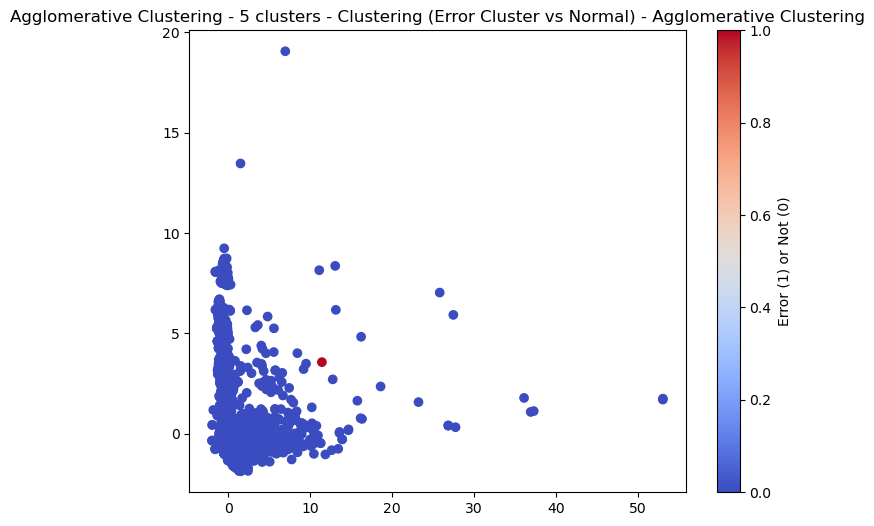


Evaluating with 6 clusters...

Agglomerative Clustering - 6 clusters, Error Cluster: 0
Accuracy: 0.4808
False Positives: 5491
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       1.00      0.45      0.62     10000
           1       0.10      0.98      0.18       604

    accuracy                           0.48     10604
   macro avg       0.55      0.71      0.40     10604
weighted avg       0.95      0.48      0.60     10604



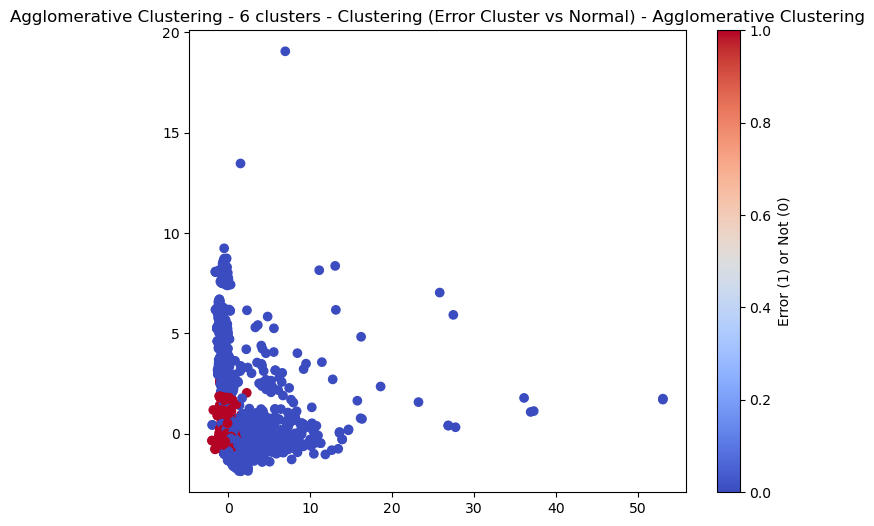


Agglomerative Clustering - 6 clusters, Error Cluster: 1
Accuracy: 0.8440
False Positives: 1065
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.84     10604
   macro avg       0.48      0.46      0.47     10604
weighted avg       0.89      0.84      0.86     10604



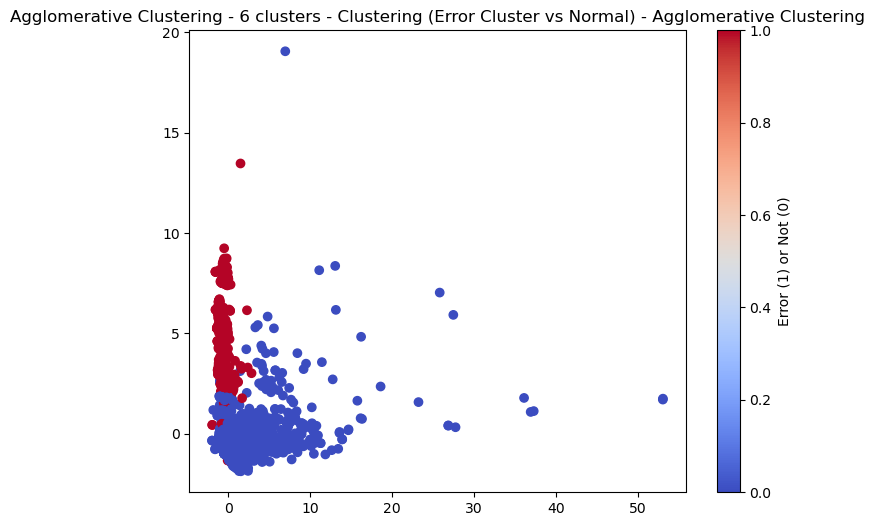


Agglomerative Clustering - 6 clusters, Error Cluster: 2
Accuracy: 0.8859
False Positives: 606
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.89     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.89      0.89     10604



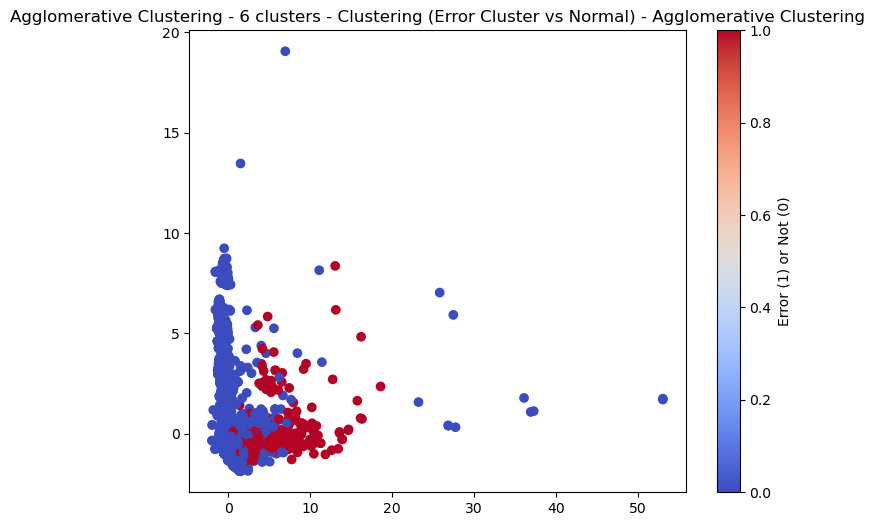


Agglomerative Clustering - 6 clusters, Error Cluster: 3
Accuracy: 0.6765
False Positives: 2826
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.68     10604
   macro avg       0.46      0.36      0.40     10604
weighted avg       0.87      0.68      0.76     10604



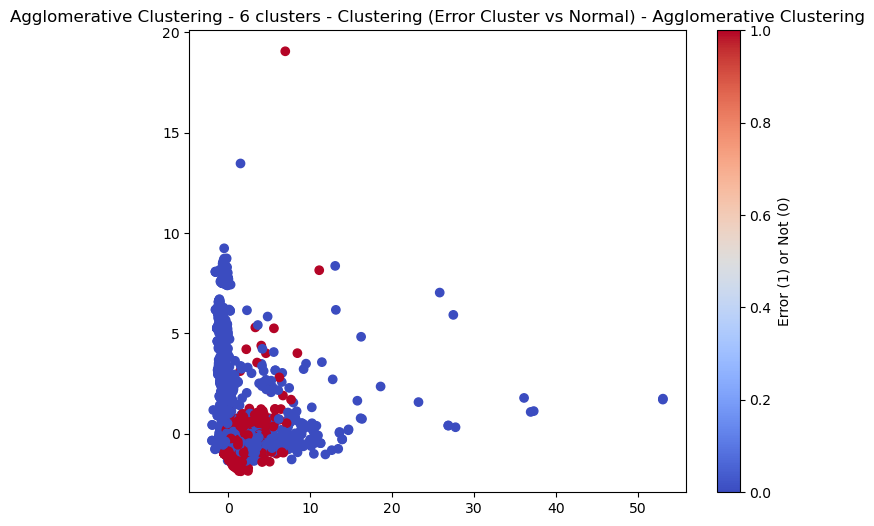


Agglomerative Clustering - 6 clusters, Error Cluster: 4
Accuracy: 0.9429
False Positives: 1
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



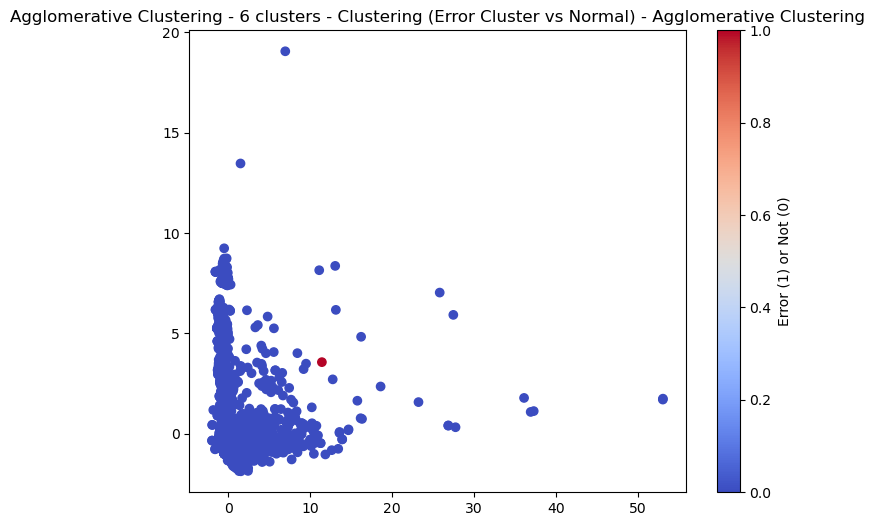


Agglomerative Clustering - 6 clusters, Error Cluster: 5
Accuracy: 0.9420
False Positives: 11
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



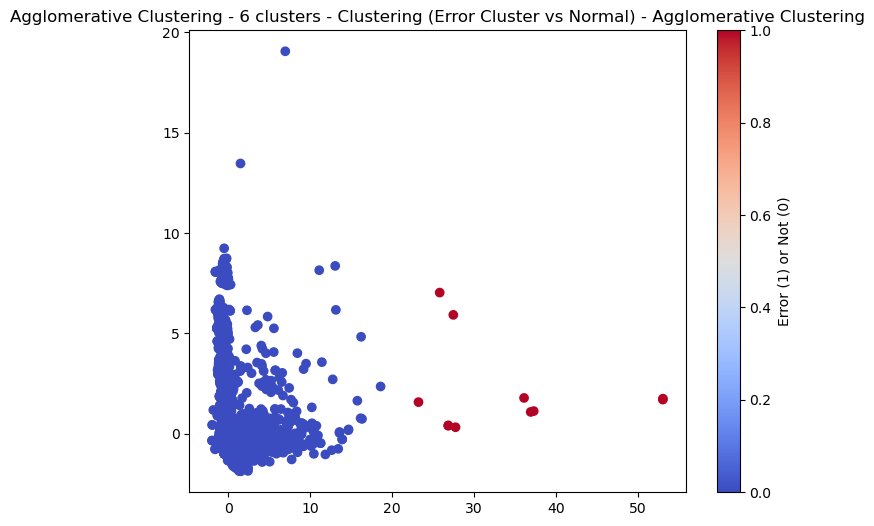


Evaluating with 7 clusters...

Agglomerative Clustering - 7 clusters, Error Cluster: 0
Accuracy: 0.8440
False Positives: 1065
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.84     10604
   macro avg       0.48      0.46      0.47     10604
weighted avg       0.89      0.84      0.86     10604



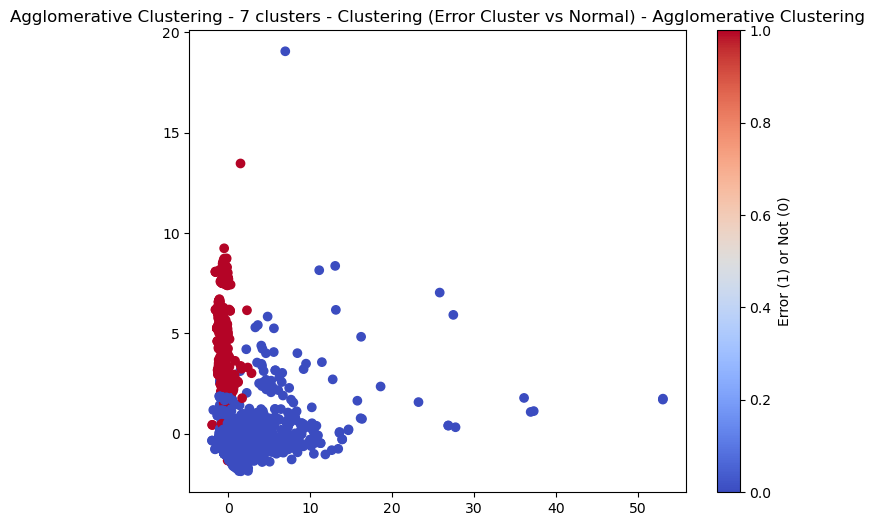


Agglomerative Clustering - 7 clusters, Error Cluster: 1
Accuracy: 0.6765
False Positives: 2826
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.68     10604
   macro avg       0.46      0.36      0.40     10604
weighted avg       0.87      0.68      0.76     10604



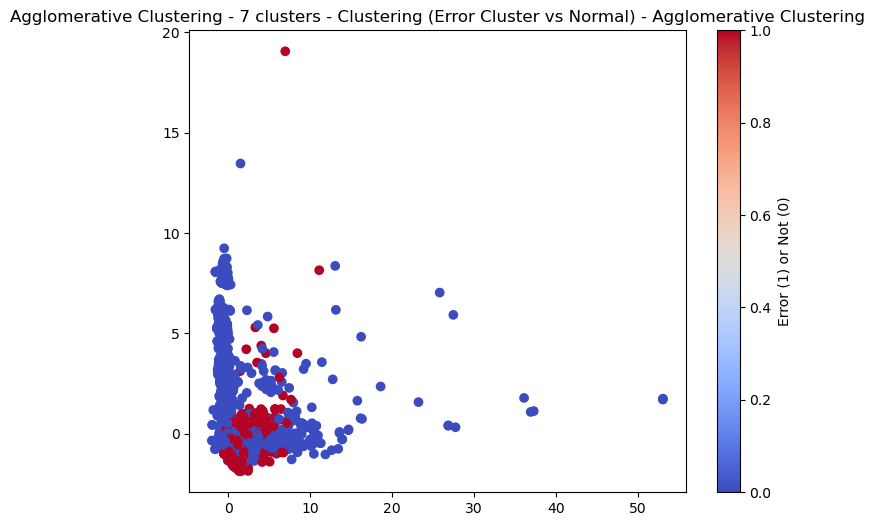


Agglomerative Clustering - 7 clusters, Error Cluster: 2
Accuracy: 0.8859
False Positives: 606
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.89     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.89      0.89     10604



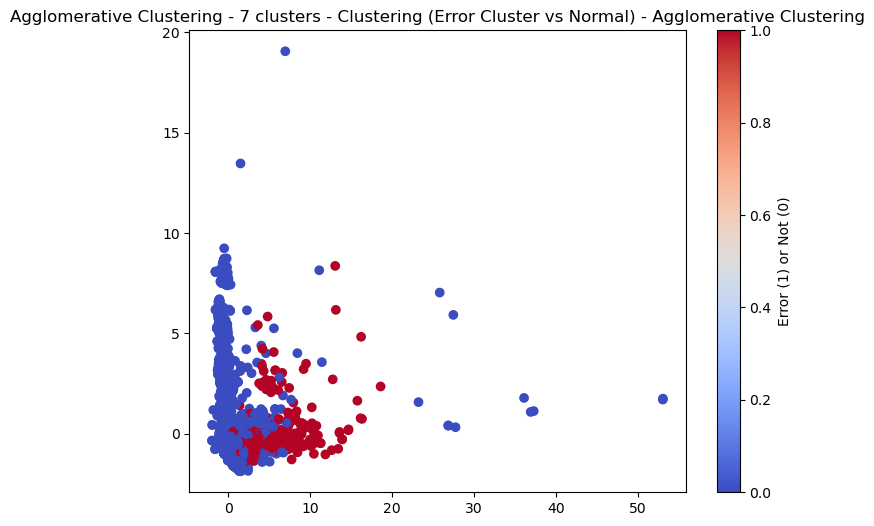


Agglomerative Clustering - 7 clusters, Error Cluster: 3
Accuracy: 0.4810
False Positives: 5489
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       1.00      0.45      0.62     10000
           1       0.10      0.98      0.18       604

    accuracy                           0.48     10604
   macro avg       0.55      0.71      0.40     10604
weighted avg       0.95      0.48      0.60     10604



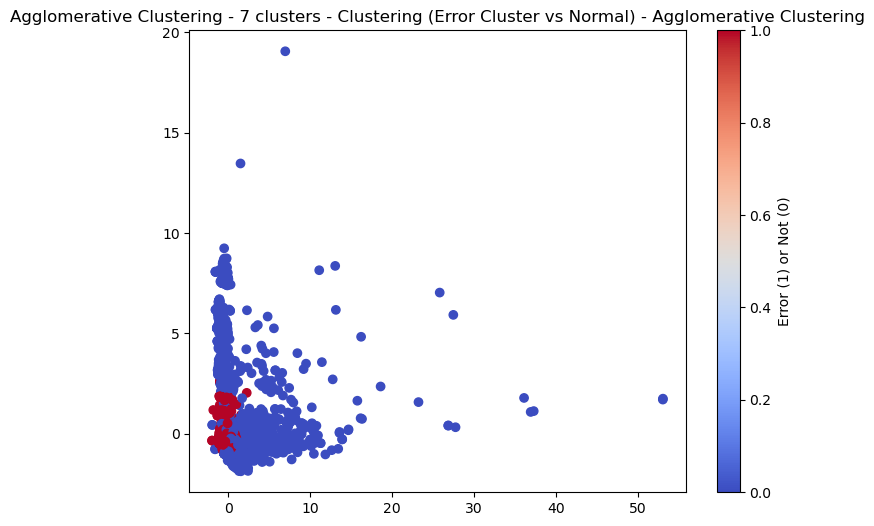


Agglomerative Clustering - 7 clusters, Error Cluster: 4
Accuracy: 0.9429
False Positives: 1
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



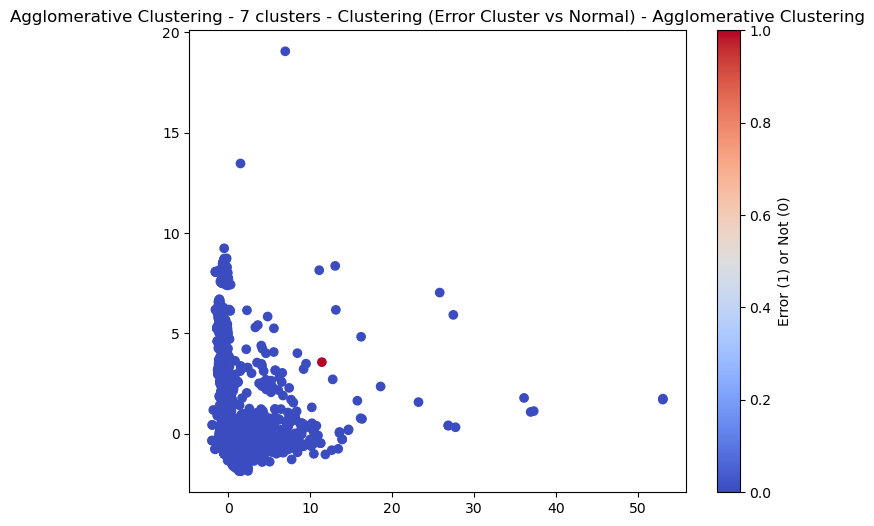


Agglomerative Clustering - 7 clusters, Error Cluster: 5
Accuracy: 0.9420
False Positives: 11
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



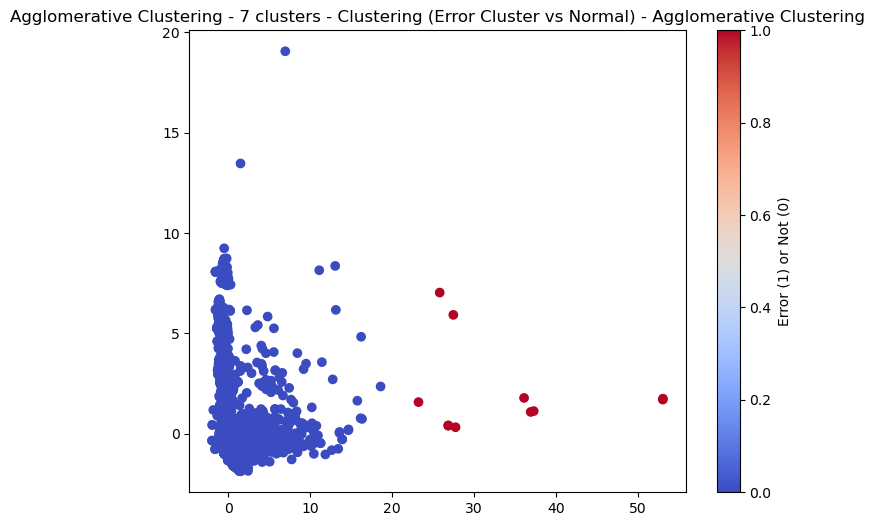


Agglomerative Clustering - 7 clusters, Error Cluster: 6
Accuracy: 0.9429
False Positives: 2
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



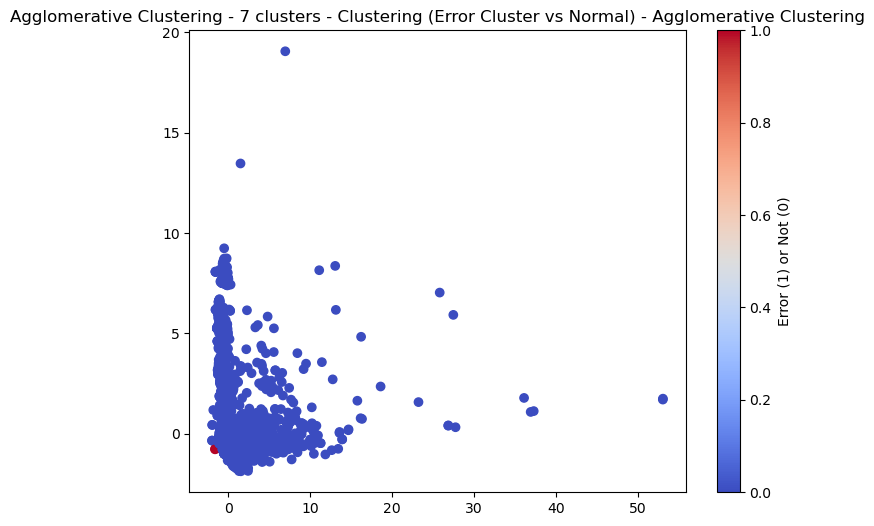


Evaluating with 2 clusters...

Gaussian Mixture Model - 2 clusters, Error Cluster: 0
Accuracy: 0.6042
False Positives: 3855
False Negatives: 342
Percentage of Errors Correctly Identified: 43.38%
              precision    recall  f1-score   support

           0       0.95      0.61      0.75     10000
           1       0.06      0.43      0.11       604

    accuracy                           0.60     10604
   macro avg       0.51      0.52      0.43     10604
weighted avg       0.90      0.60      0.71     10604



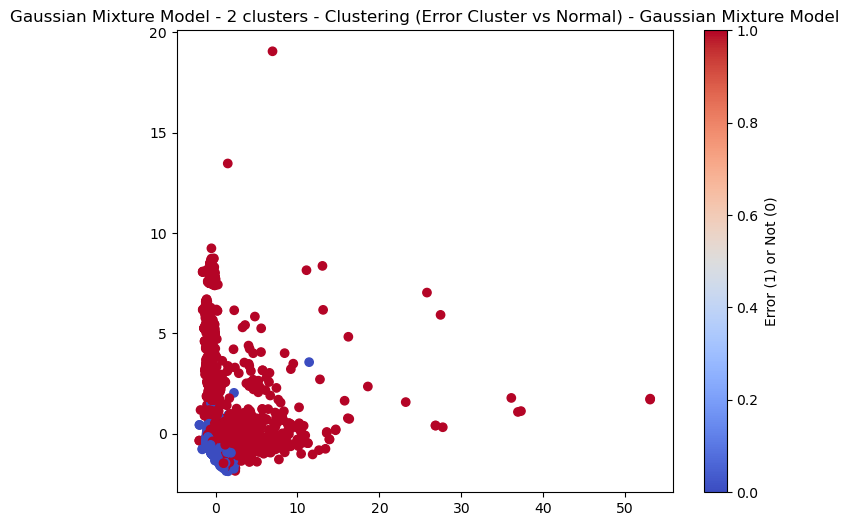


Gaussian Mixture Model - 2 clusters, Error Cluster: 1
Accuracy: 0.3958
False Positives: 6145
False Negatives: 262
Percentage of Errors Correctly Identified: 56.62%
              precision    recall  f1-score   support

           0       0.94      0.39      0.55     10000
           1       0.05      0.57      0.10       604

    accuracy                           0.40     10604
   macro avg       0.49      0.48      0.32     10604
weighted avg       0.89      0.40      0.52     10604



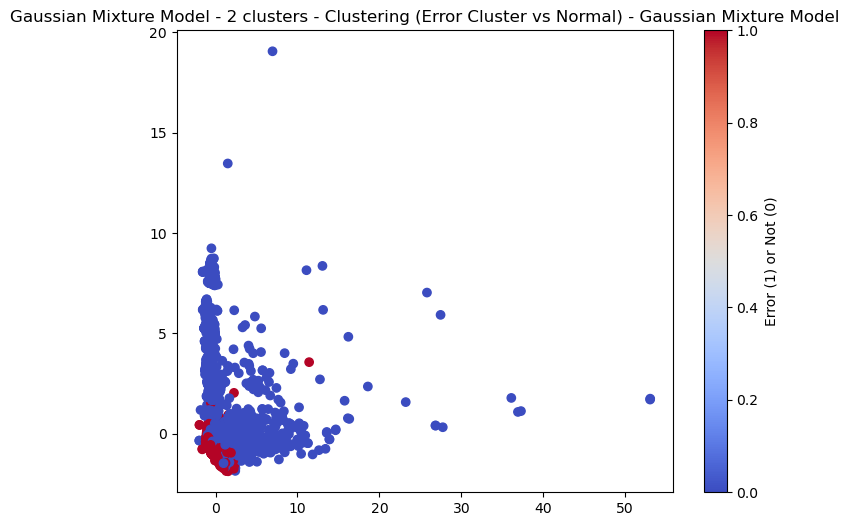


Evaluating with 3 clusters...

Gaussian Mixture Model - 3 clusters, Error Cluster: 0
Accuracy: 0.7889
False Positives: 1635
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.79     10604
   macro avg       0.47      0.42      0.44     10604
weighted avg       0.88      0.79      0.83     10604



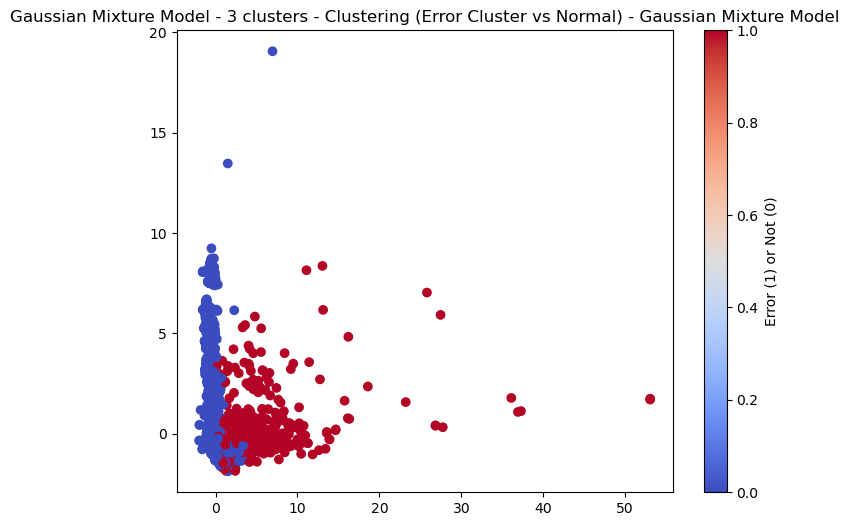


Gaussian Mixture Model - 3 clusters, Error Cluster: 1
Accuracy: 0.5197
False Positives: 4833
False Negatives: 260
Percentage of Errors Correctly Identified: 56.95%
              precision    recall  f1-score   support

           0       0.95      0.52      0.67     10000
           1       0.07      0.57      0.12       604

    accuracy                           0.52     10604
   macro avg       0.51      0.54      0.39     10604
weighted avg       0.90      0.52      0.64     10604



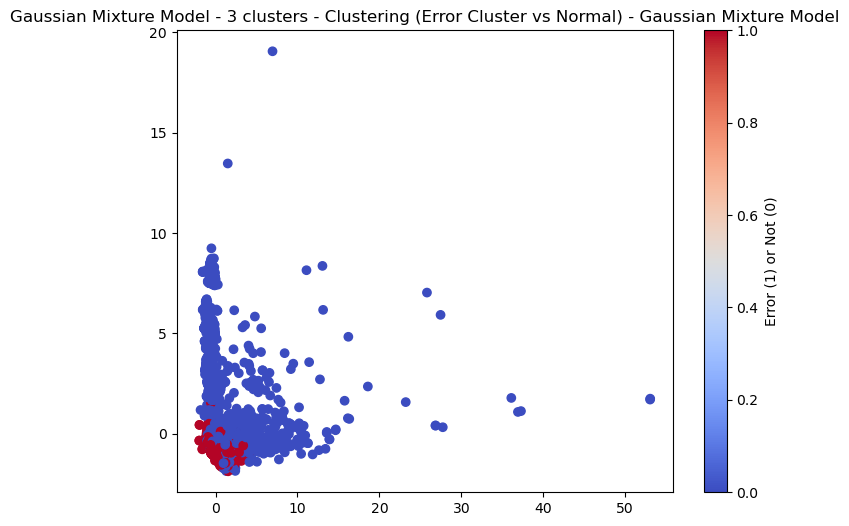


Gaussian Mixture Model - 3 clusters, Error Cluster: 2
Accuracy: 0.6345
False Positives: 3532
False Negatives: 344
Percentage of Errors Correctly Identified: 43.05%
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     10000
           1       0.07      0.43      0.12       604

    accuracy                           0.63     10604
   macro avg       0.51      0.54      0.44     10604
weighted avg       0.90      0.63      0.73     10604



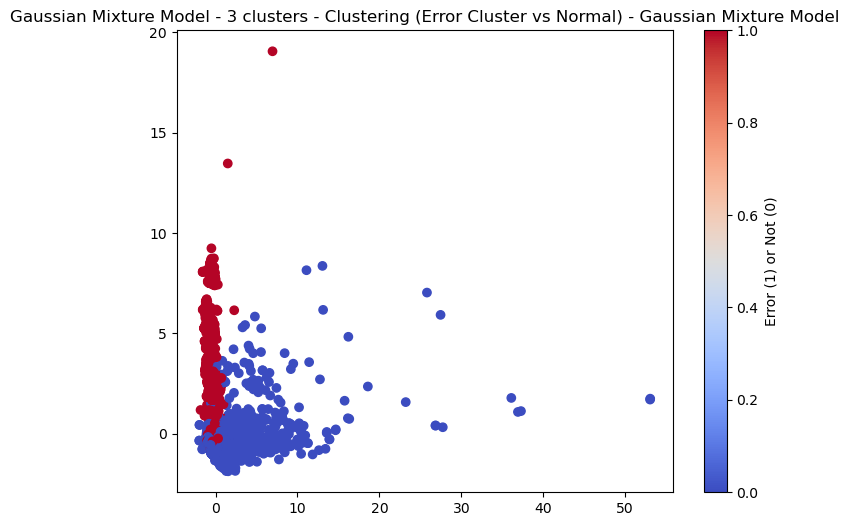


Evaluating with 4 clusters...

Gaussian Mixture Model - 4 clusters, Error Cluster: 0
Accuracy: 0.8612
False Positives: 868
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.86     10604
   macro avg       0.47      0.46      0.46     10604
weighted avg       0.88      0.86      0.87     10604



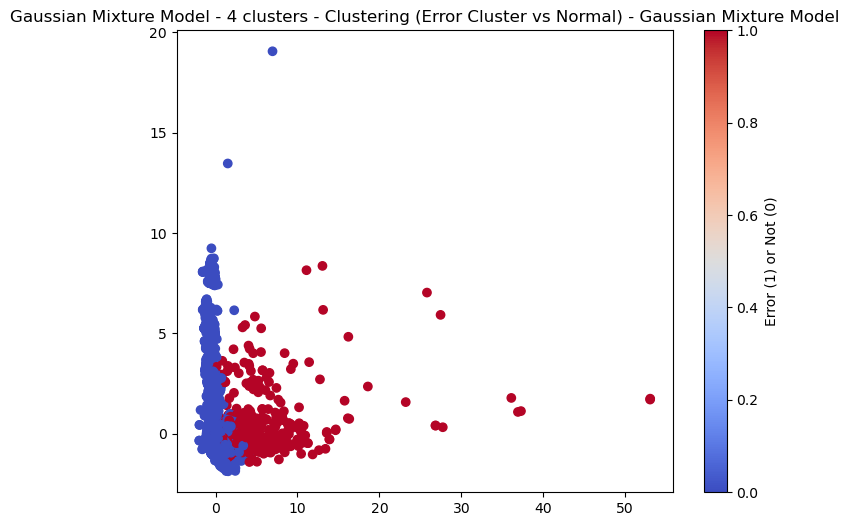


Gaussian Mixture Model - 4 clusters, Error Cluster: 1
Accuracy: 0.6864
False Positives: 2978
False Negatives: 347
Percentage of Errors Correctly Identified: 42.55%
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     10000
           1       0.08      0.43      0.13       604

    accuracy                           0.69     10604
   macro avg       0.52      0.56      0.47     10604
weighted avg       0.90      0.69      0.77     10604



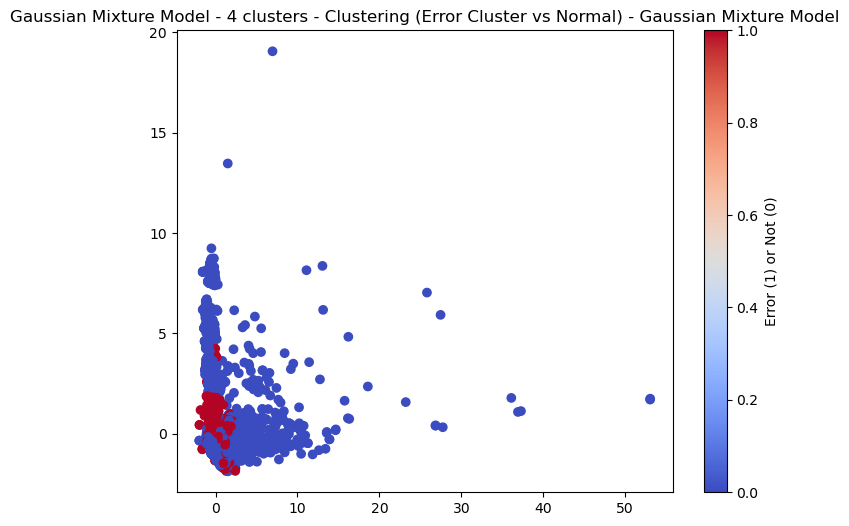


Gaussian Mixture Model - 4 clusters, Error Cluster: 2
Accuracy: 0.8464
False Positives: 1028
False Negatives: 601
Percentage of Errors Correctly Identified: 0.50%
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.85     10604
   macro avg       0.47      0.45      0.46     10604
weighted avg       0.88      0.85      0.86     10604



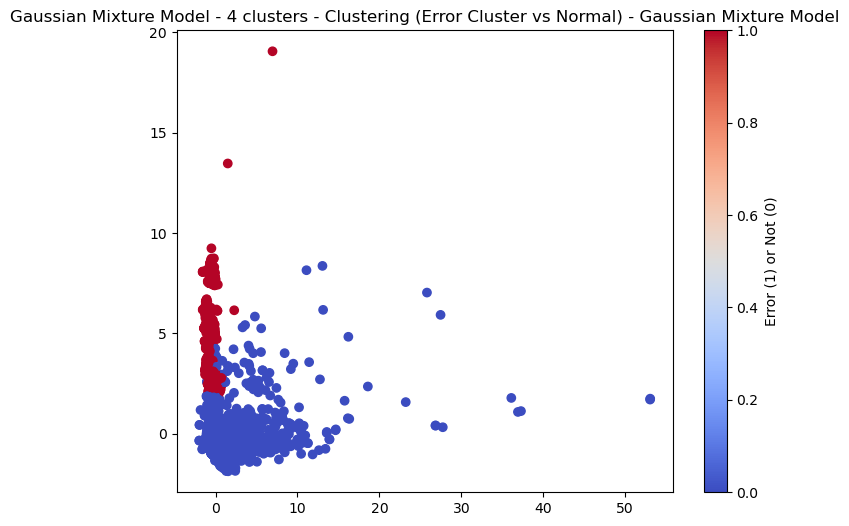


Gaussian Mixture Model - 4 clusters, Error Cluster: 3
Accuracy: 0.4921
False Positives: 5126
False Negatives: 260
Percentage of Errors Correctly Identified: 56.95%
              precision    recall  f1-score   support

           0       0.95      0.49      0.64     10000
           1       0.06      0.57      0.11       604

    accuracy                           0.49     10604
   macro avg       0.51      0.53      0.38     10604
weighted avg       0.90      0.49      0.61     10604



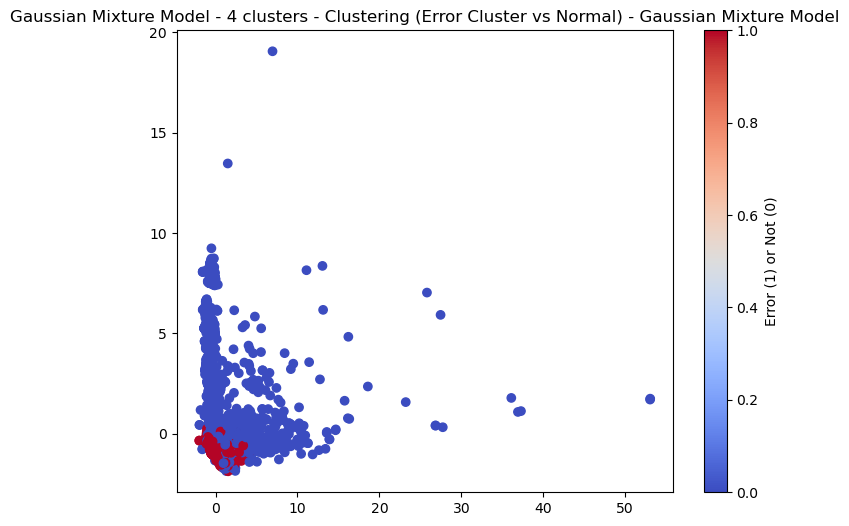


Evaluating with 5 clusters...

Gaussian Mixture Model - 5 clusters, Error Cluster: 0
Accuracy: 0.8946
False Positives: 514
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.89     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.89      0.89     10604



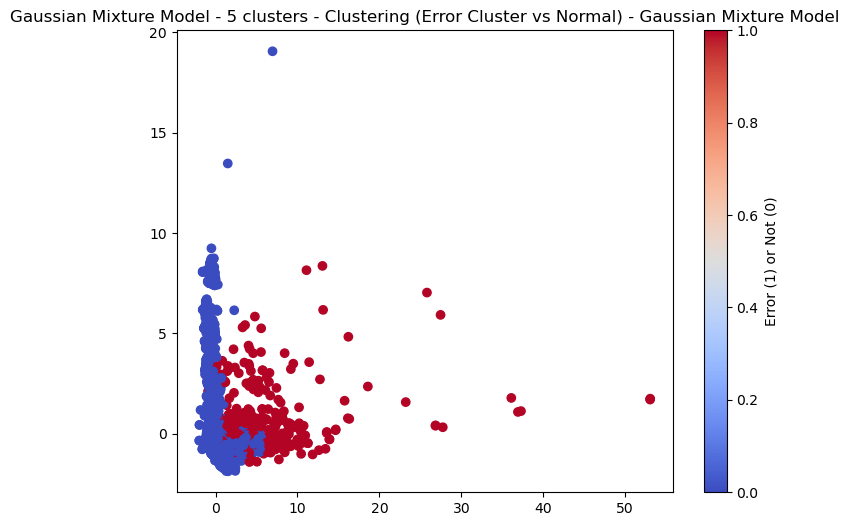


Gaussian Mixture Model - 5 clusters, Error Cluster: 1
Accuracy: 0.7257
False Positives: 2634
False Negatives: 275
Percentage of Errors Correctly Identified: 54.47%
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     10000
           1       0.11      0.54      0.18       604

    accuracy                           0.73     10604
   macro avg       0.54      0.64      0.51     10604
weighted avg       0.92      0.73      0.80     10604



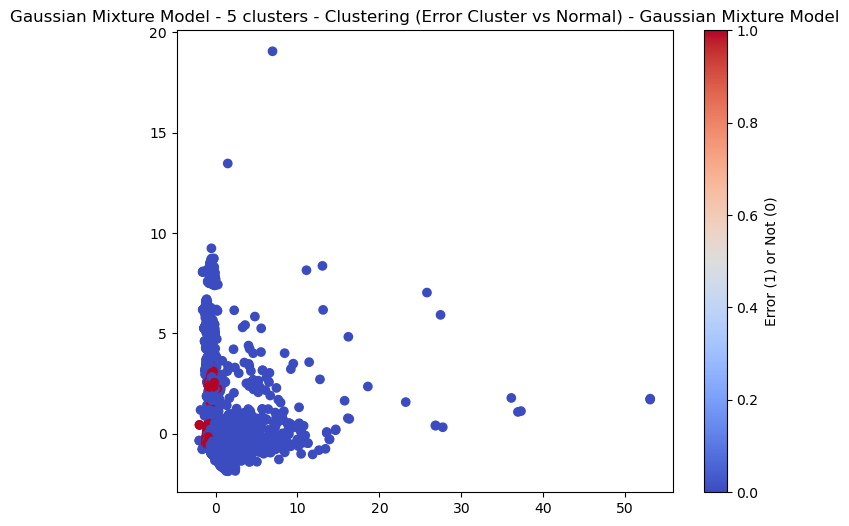


Gaussian Mixture Model - 5 clusters, Error Cluster: 2
Accuracy: 0.8992
False Positives: 725
False Negatives: 344
Percentage of Errors Correctly Identified: 43.05%
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     10000
           1       0.26      0.43      0.33       604

    accuracy                           0.90     10604
   macro avg       0.61      0.68      0.64     10604
weighted avg       0.92      0.90      0.91     10604



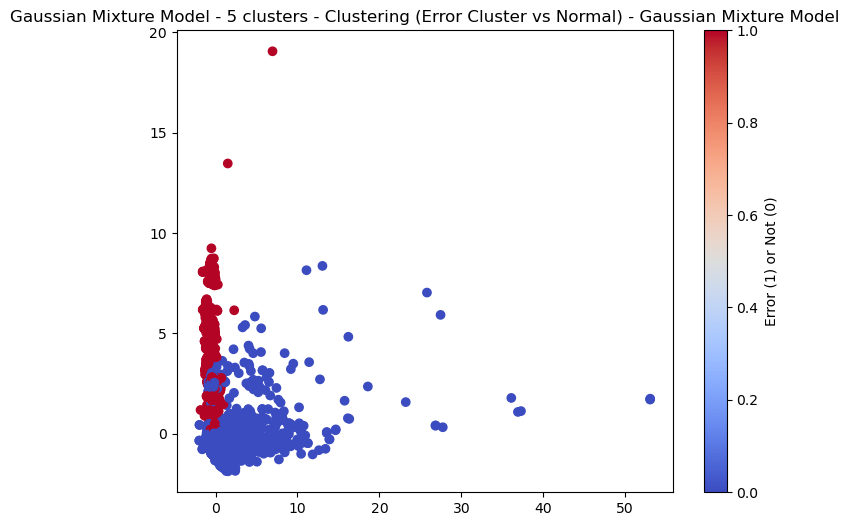


Gaussian Mixture Model - 5 clusters, Error Cluster: 3
Accuracy: 0.3669
False Positives: 6124
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.87      0.39      0.54     10000
           1       0.00      0.02      0.00       604

    accuracy                           0.37     10604
   macro avg       0.44      0.21      0.27     10604
weighted avg       0.82      0.37      0.51     10604



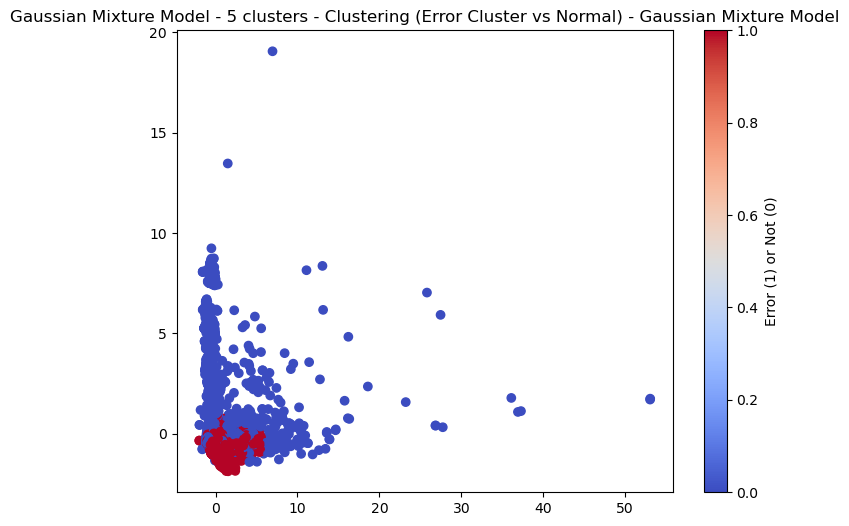


Gaussian Mixture Model - 5 clusters, Error Cluster: 4
Accuracy: 0.9428
False Positives: 3
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



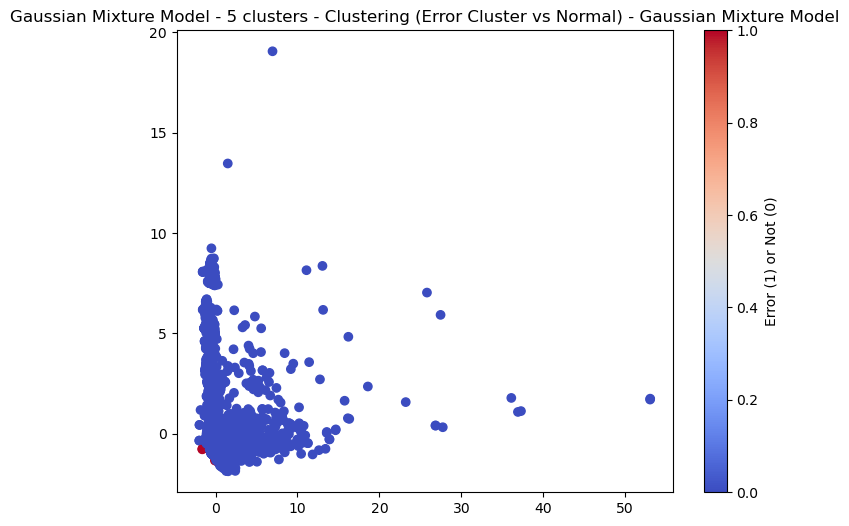


Evaluating with 6 clusters...

Gaussian Mixture Model - 6 clusters, Error Cluster: 0
Accuracy: 0.5846
False Positives: 4145
False Negatives: 260
Percentage of Errors Correctly Identified: 56.95%
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     10000
           1       0.08      0.57      0.14       604

    accuracy                           0.58     10604
   macro avg       0.52      0.58      0.43     10604
weighted avg       0.91      0.58      0.69     10604



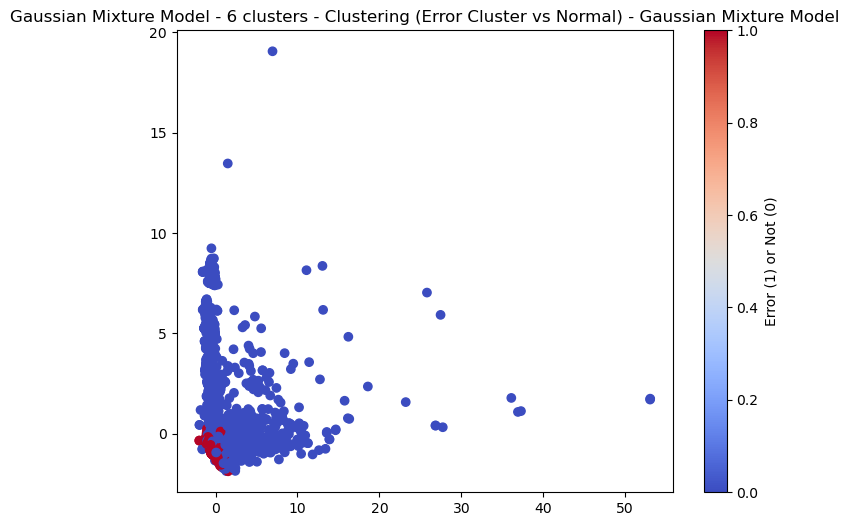


Gaussian Mixture Model - 6 clusters, Error Cluster: 1
Accuracy: 0.9373
False Positives: 320
False Negatives: 345
Percentage of Errors Correctly Identified: 42.88%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10000
           1       0.45      0.43      0.44       604

    accuracy                           0.94     10604
   macro avg       0.71      0.70      0.70     10604
weighted avg       0.94      0.94      0.94     10604



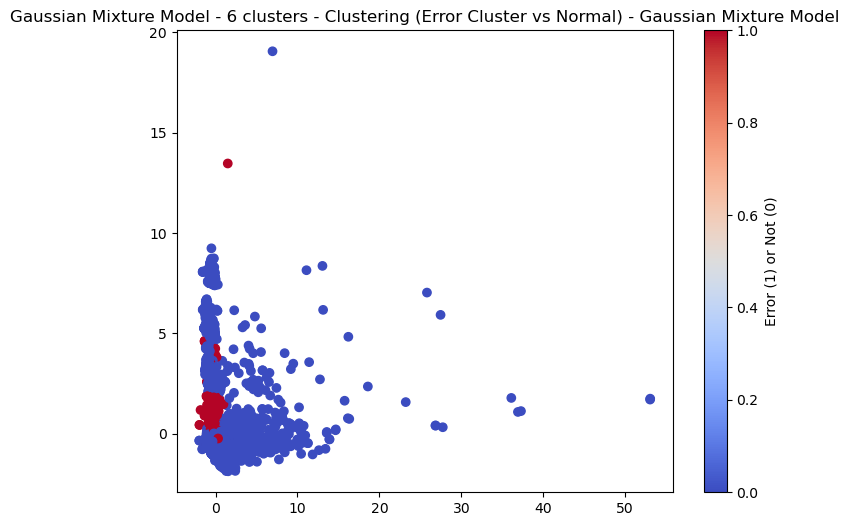


Gaussian Mixture Model - 6 clusters, Error Cluster: 2
Accuracy: 0.8461
False Positives: 1029
False Negatives: 603
Percentage of Errors Correctly Identified: 0.17%
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.85     10604
   macro avg       0.47      0.45      0.46     10604
weighted avg       0.88      0.85      0.86     10604



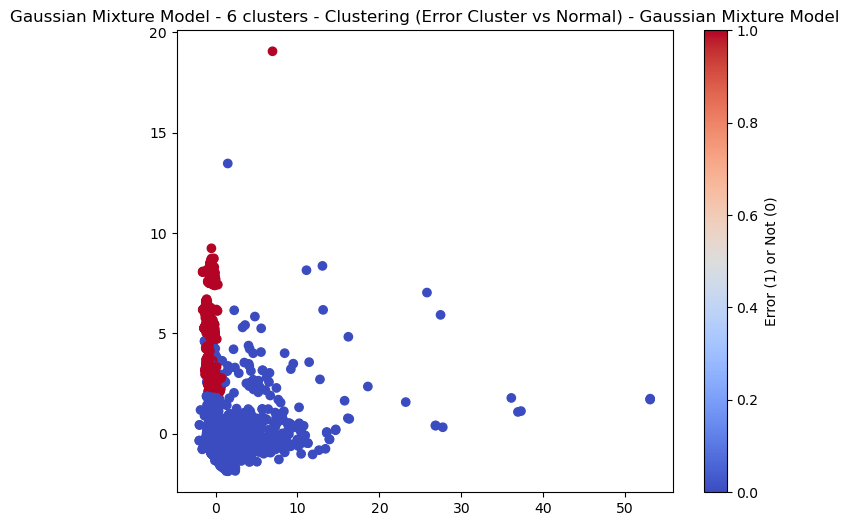


Gaussian Mixture Model - 6 clusters, Error Cluster: 3
Accuracy: 0.5490
False Positives: 4178
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.91      0.58      0.71     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.55     10604
   macro avg       0.45      0.29      0.35     10604
weighted avg       0.85      0.55      0.67     10604



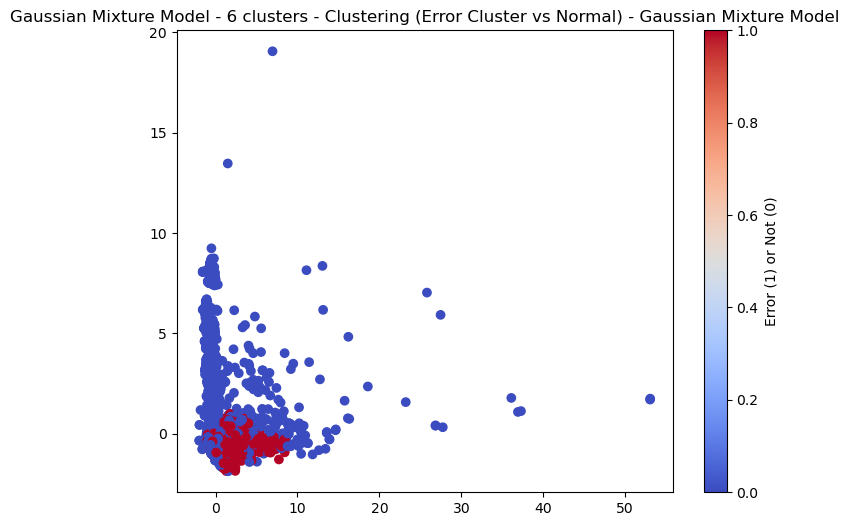


Gaussian Mixture Model - 6 clusters, Error Cluster: 4
Accuracy: 0.9428
False Positives: 3
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



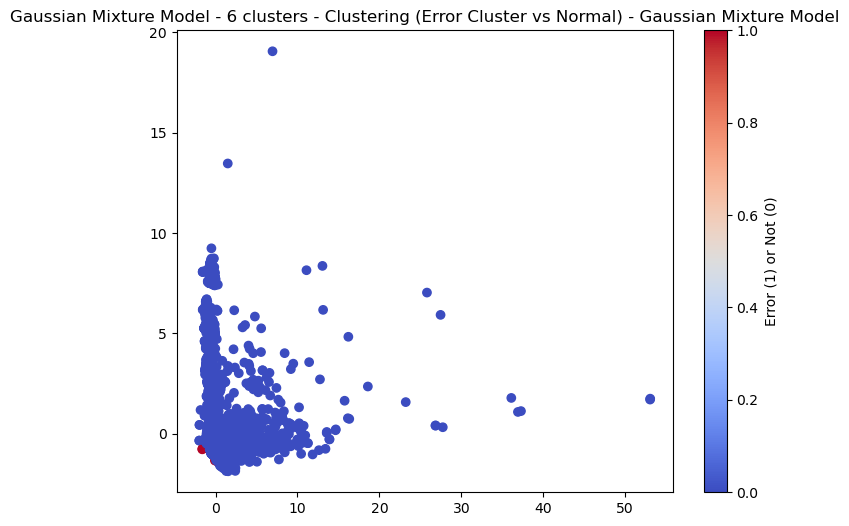


Gaussian Mixture Model - 6 clusters, Error Cluster: 5
Accuracy: 0.9124
False Positives: 325
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.91     10604
   macro avg       0.47      0.48      0.48     10604
weighted avg       0.89      0.91      0.90     10604



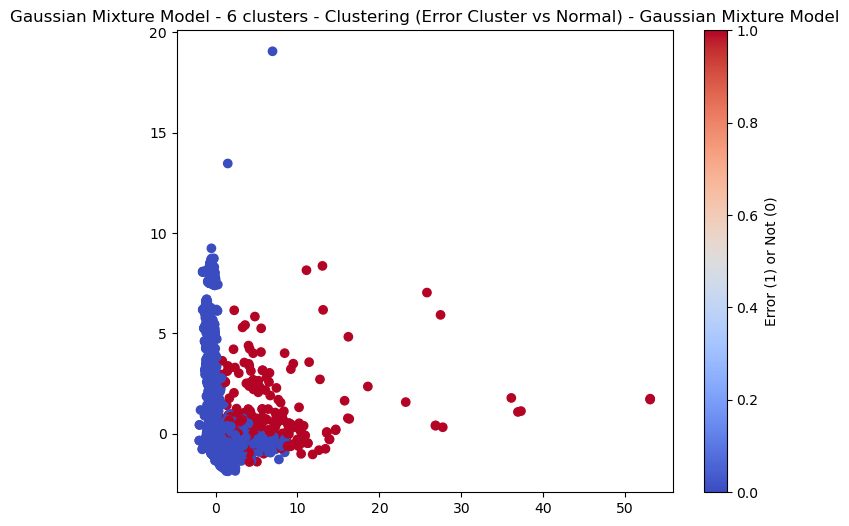


Evaluating with 7 clusters...

Gaussian Mixture Model - 7 clusters, Error Cluster: 0
Accuracy: 0.7919
False Positives: 2144
False Negatives: 63
Percentage of Errors Correctly Identified: 89.57%
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     10000
           1       0.20      0.90      0.33       604

    accuracy                           0.79     10604
   macro avg       0.60      0.84      0.60     10604
weighted avg       0.95      0.79      0.85     10604



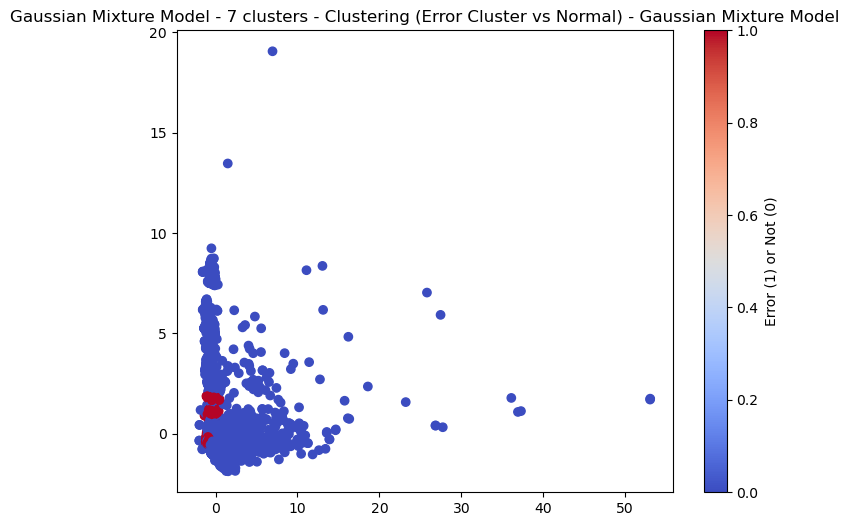


Gaussian Mixture Model - 7 clusters, Error Cluster: 1
Accuracy: 0.8368
False Positives: 1141
False Negatives: 590
Percentage of Errors Correctly Identified: 2.32%
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     10000
           1       0.01      0.02      0.02       604

    accuracy                           0.84     10604
   macro avg       0.47      0.45      0.46     10604
weighted avg       0.88      0.84      0.86     10604



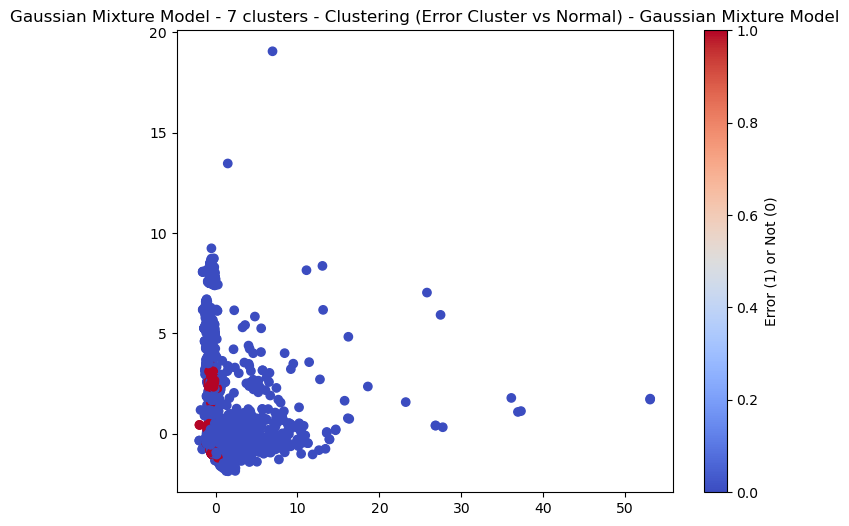


Gaussian Mixture Model - 7 clusters, Error Cluster: 2
Accuracy: 0.8758
False Positives: 760
False Negatives: 557
Percentage of Errors Correctly Identified: 7.78%
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10000
           1       0.06      0.08      0.07       604

    accuracy                           0.88     10604
   macro avg       0.50      0.50      0.50     10604
weighted avg       0.89      0.88      0.88     10604



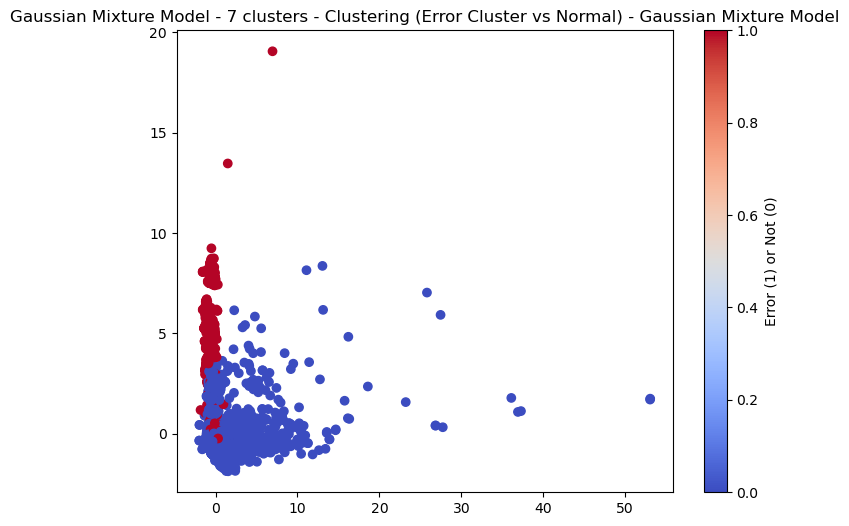


Gaussian Mixture Model - 7 clusters, Error Cluster: 3
Accuracy: 0.4321
False Positives: 5420
False Negatives: 602
Percentage of Errors Correctly Identified: 0.33%
              precision    recall  f1-score   support

           0       0.88      0.46      0.60     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.43     10604
   macro avg       0.44      0.23      0.30     10604
weighted avg       0.83      0.43      0.57     10604



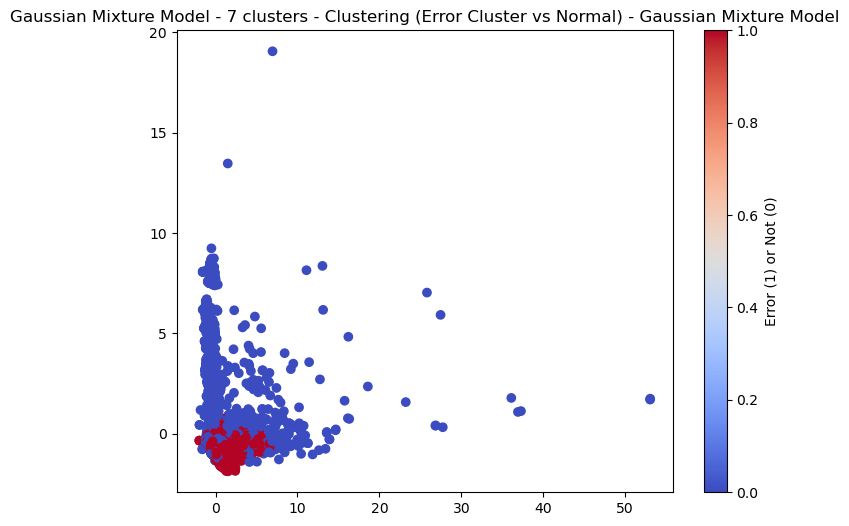


Gaussian Mixture Model - 7 clusters, Error Cluster: 4
Accuracy: 0.9428
False Positives: 3
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



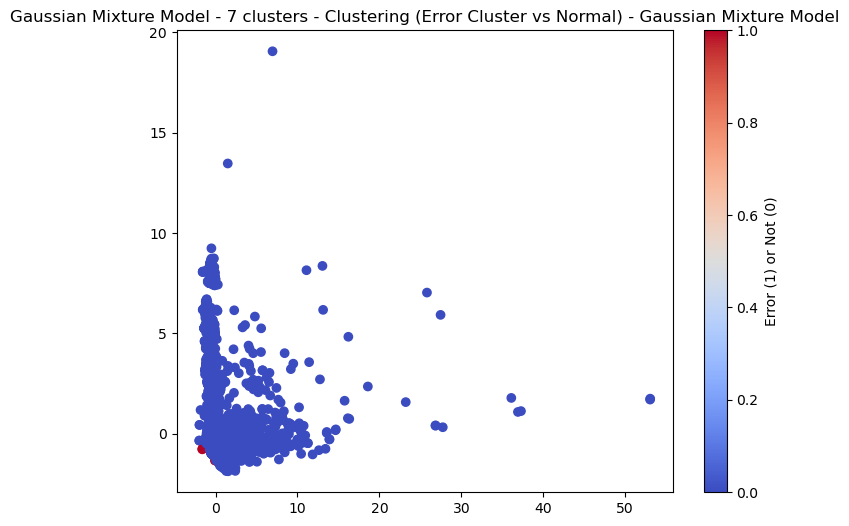


Gaussian Mixture Model - 7 clusters, Error Cluster: 5
Accuracy: 0.8939
False Positives: 521
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.89     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.89      0.89     10604



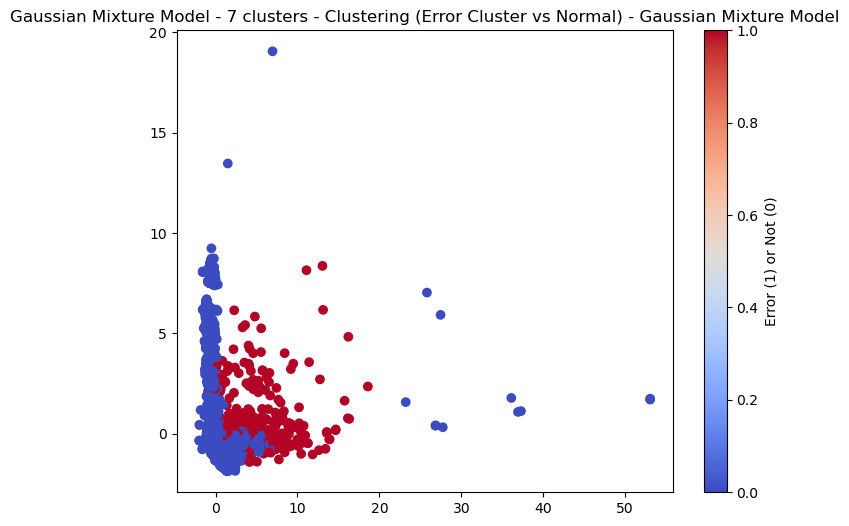


Gaussian Mixture Model - 7 clusters, Error Cluster: 6
Accuracy: 0.9420
False Positives: 11
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.91     10604



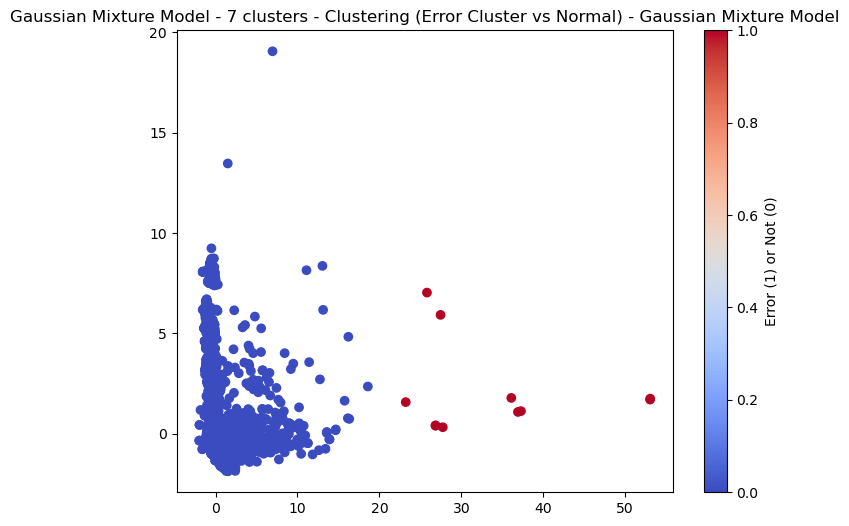


Evaluating with 2 clusters...

Mean Shift - 2 clusters, Error Cluster: 0
Accuracy: 0.2038
False Positives: 8394
False Negatives: 49
Percentage of Errors Correctly Identified: 91.89%
              precision    recall  f1-score   support

           0       0.97      0.16      0.28     10000
           1       0.06      0.92      0.12       604

    accuracy                           0.20     10604
   macro avg       0.52      0.54      0.20     10604
weighted avg       0.92      0.20      0.27     10604



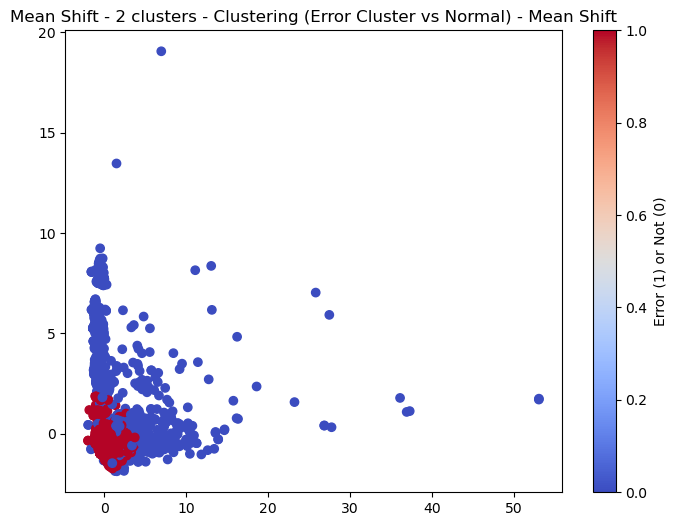


Mean Shift - 2 clusters, Error Cluster: 1
Accuracy: 0.8774
False Positives: 696
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.88     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



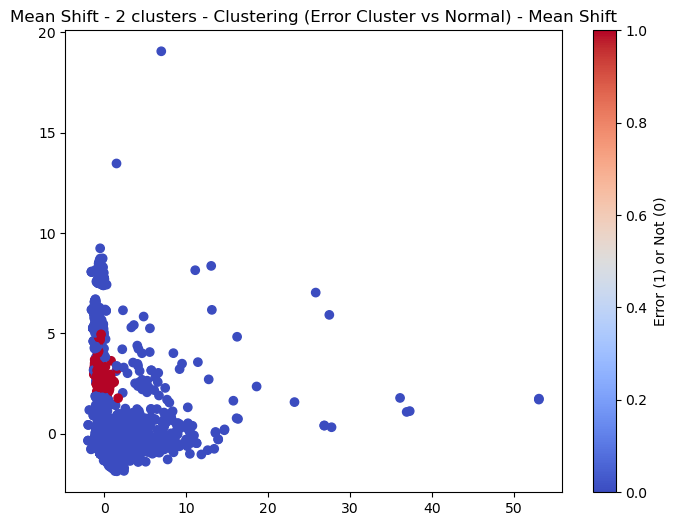


Evaluating with 3 clusters...

Mean Shift - 3 clusters, Error Cluster: 0
Accuracy: 0.2038
False Positives: 8394
False Negatives: 49
Percentage of Errors Correctly Identified: 91.89%
              precision    recall  f1-score   support

           0       0.97      0.16      0.28     10000
           1       0.06      0.92      0.12       604

    accuracy                           0.20     10604
   macro avg       0.52      0.54      0.20     10604
weighted avg       0.92      0.20      0.27     10604



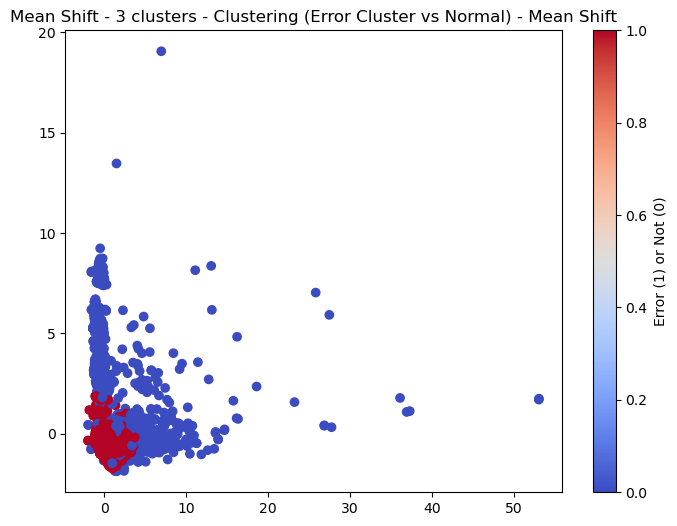


Mean Shift - 3 clusters, Error Cluster: 1
Accuracy: 0.8774
False Positives: 696
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.88     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



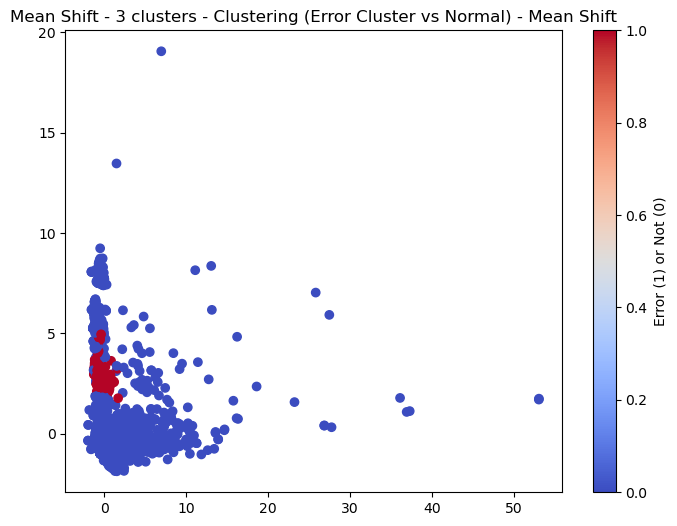


Mean Shift - 3 clusters, Error Cluster: 2
Accuracy: 0.9266
False Positives: 174
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.93      0.91     10604



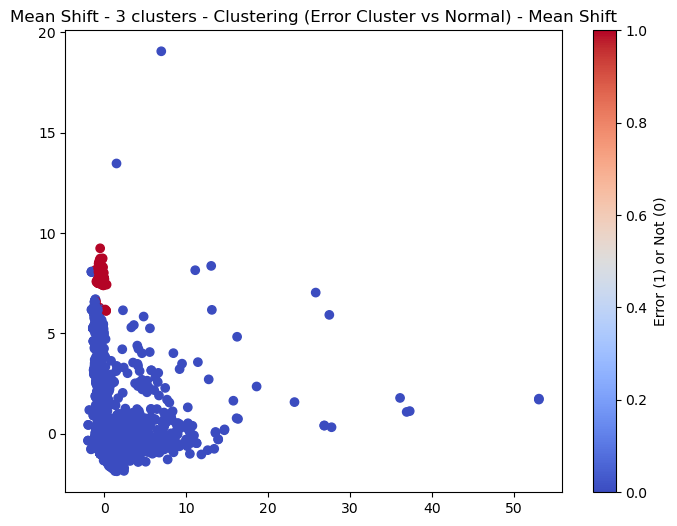


Evaluating with 4 clusters...

Mean Shift - 4 clusters, Error Cluster: 0
Accuracy: 0.2038
False Positives: 8394
False Negatives: 49
Percentage of Errors Correctly Identified: 91.89%
              precision    recall  f1-score   support

           0       0.97      0.16      0.28     10000
           1       0.06      0.92      0.12       604

    accuracy                           0.20     10604
   macro avg       0.52      0.54      0.20     10604
weighted avg       0.92      0.20      0.27     10604



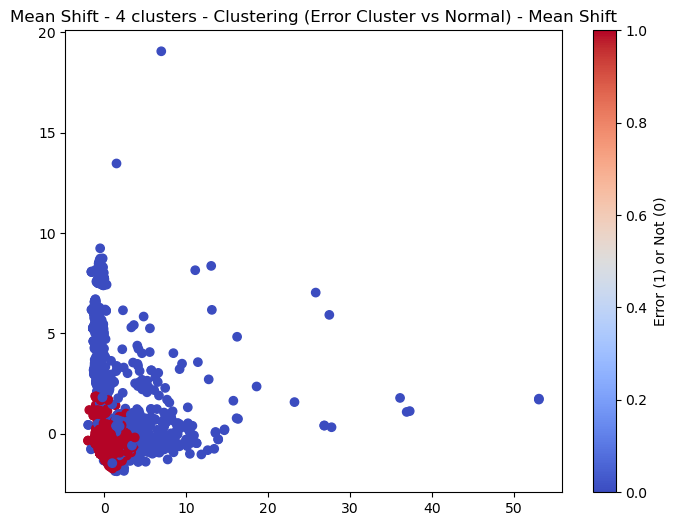


Mean Shift - 4 clusters, Error Cluster: 1
Accuracy: 0.8774
False Positives: 696
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.88     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



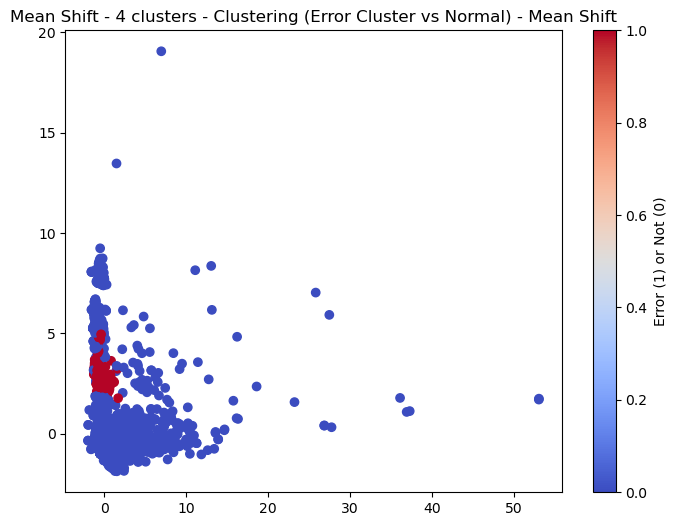


Mean Shift - 4 clusters, Error Cluster: 2
Accuracy: 0.9266
False Positives: 174
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.93      0.91     10604



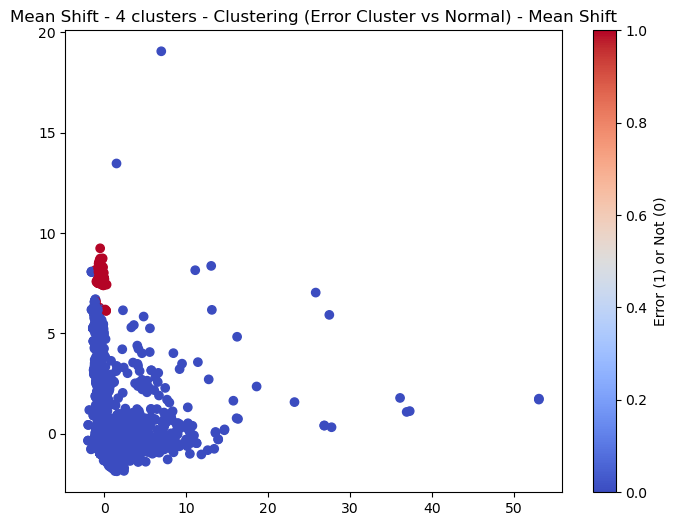


Mean Shift - 4 clusters, Error Cluster: 3
Accuracy: 0.9314
False Positives: 133
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10000
           1       0.07      0.02      0.03       604

    accuracy                           0.93     10604
   macro avg       0.51      0.50      0.50     10604
weighted avg       0.89      0.93      0.91     10604



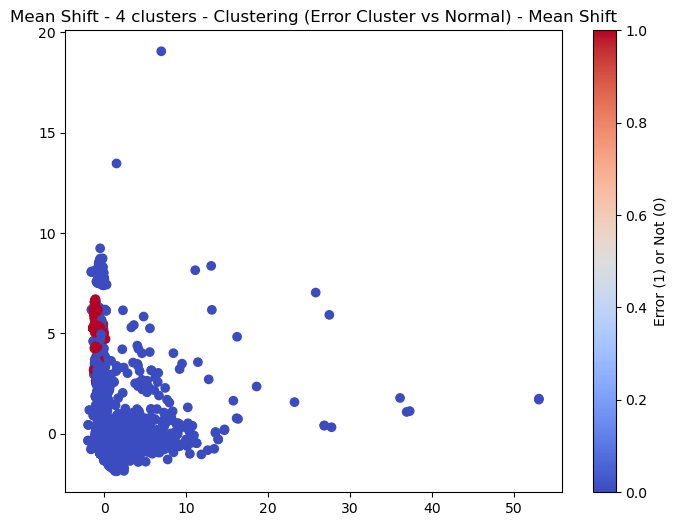


Evaluating with 5 clusters...

Mean Shift - 5 clusters, Error Cluster: 0
Accuracy: 0.2038
False Positives: 8394
False Negatives: 49
Percentage of Errors Correctly Identified: 91.89%
              precision    recall  f1-score   support

           0       0.97      0.16      0.28     10000
           1       0.06      0.92      0.12       604

    accuracy                           0.20     10604
   macro avg       0.52      0.54      0.20     10604
weighted avg       0.92      0.20      0.27     10604



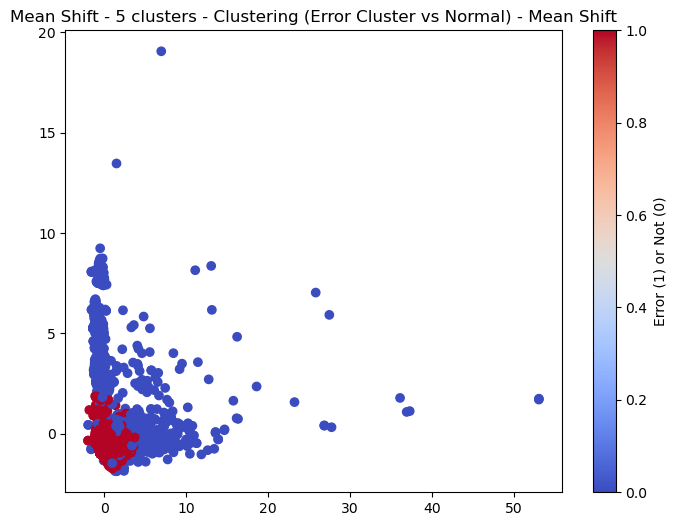


Mean Shift - 5 clusters, Error Cluster: 1
Accuracy: 0.8774
False Positives: 696
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.88     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



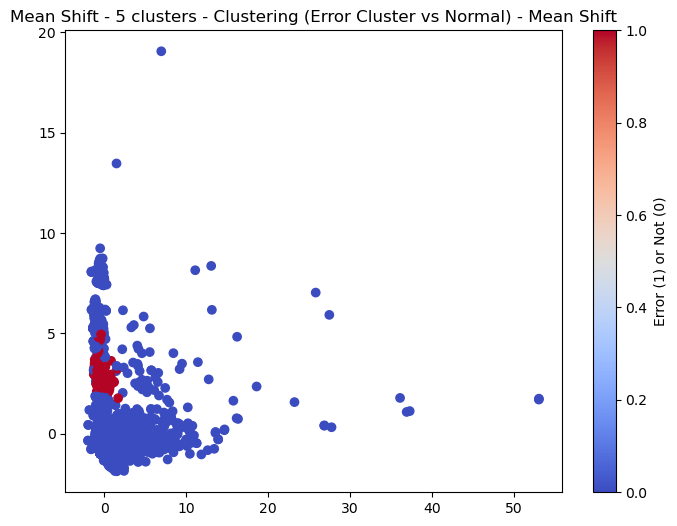


Mean Shift - 5 clusters, Error Cluster: 2
Accuracy: 0.9266
False Positives: 174
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.93      0.91     10604



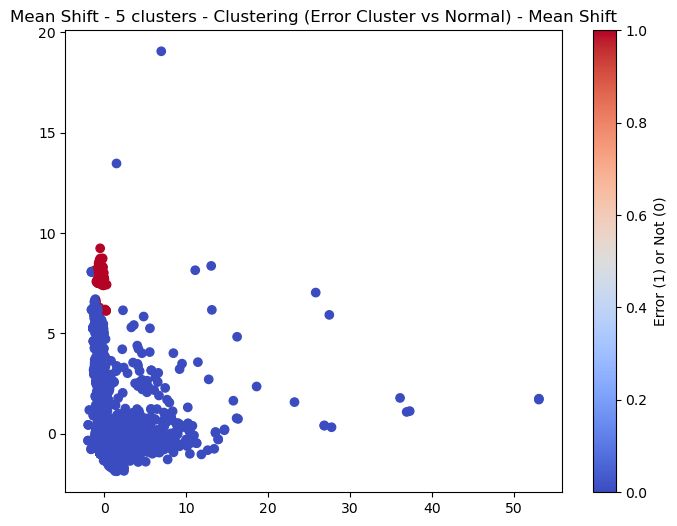


Mean Shift - 5 clusters, Error Cluster: 3
Accuracy: 0.9314
False Positives: 133
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10000
           1       0.07      0.02      0.03       604

    accuracy                           0.93     10604
   macro avg       0.51      0.50      0.50     10604
weighted avg       0.89      0.93      0.91     10604



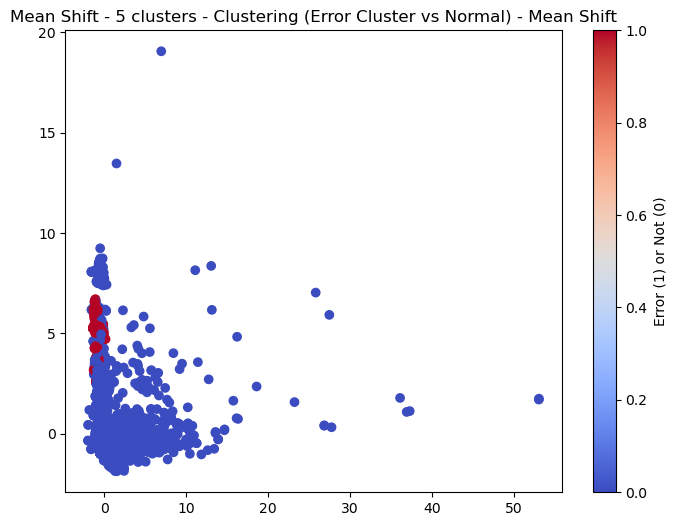


Mean Shift - 5 clusters, Error Cluster: 4
Accuracy: 0.9342
False Positives: 94
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.93      0.91     10604



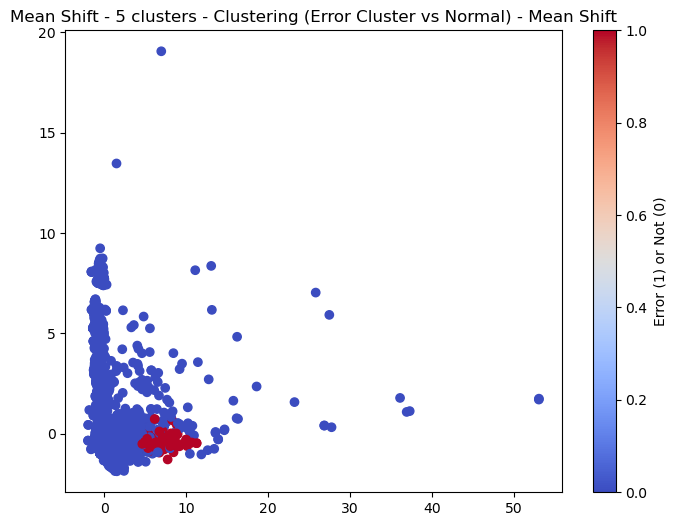


Evaluating with 6 clusters...

Mean Shift - 6 clusters, Error Cluster: 0
Accuracy: 0.2038
False Positives: 8394
False Negatives: 49
Percentage of Errors Correctly Identified: 91.89%
              precision    recall  f1-score   support

           0       0.97      0.16      0.28     10000
           1       0.06      0.92      0.12       604

    accuracy                           0.20     10604
   macro avg       0.52      0.54      0.20     10604
weighted avg       0.92      0.20      0.27     10604



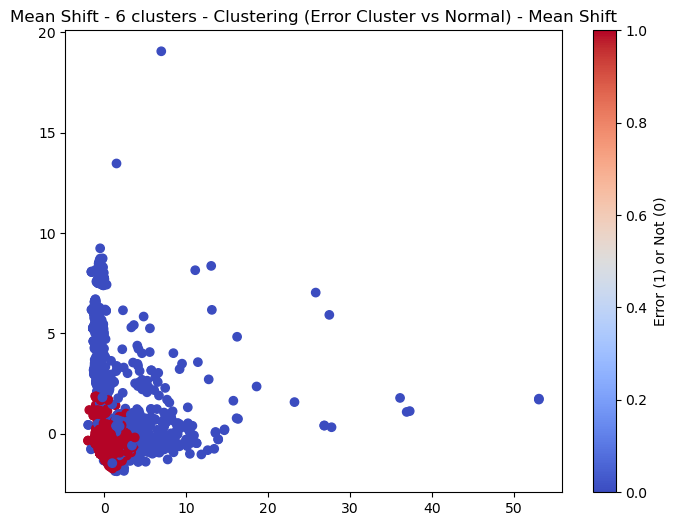


Mean Shift - 6 clusters, Error Cluster: 1
Accuracy: 0.8774
False Positives: 696
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.88     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



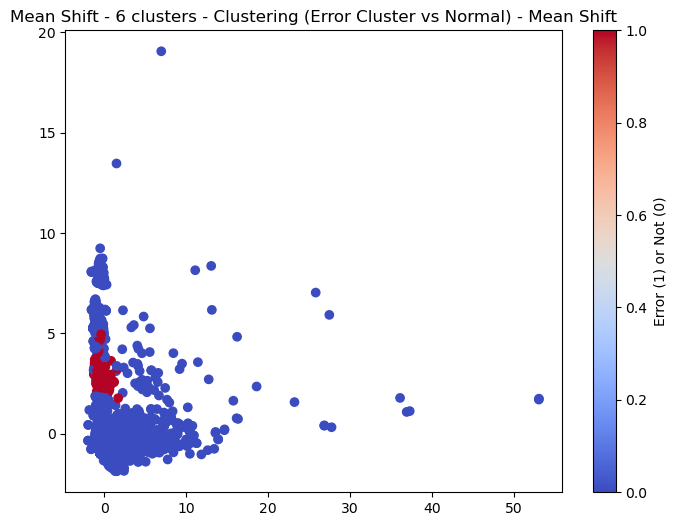


Mean Shift - 6 clusters, Error Cluster: 2
Accuracy: 0.9266
False Positives: 174
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.93      0.91     10604



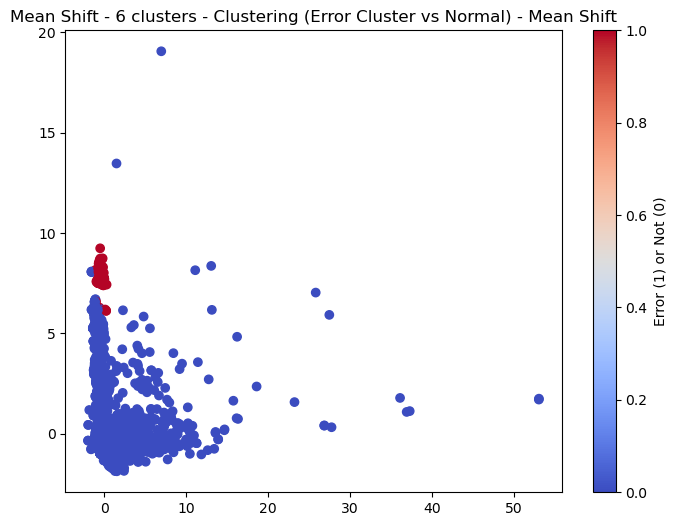


Mean Shift - 6 clusters, Error Cluster: 3
Accuracy: 0.9314
False Positives: 133
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10000
           1       0.07      0.02      0.03       604

    accuracy                           0.93     10604
   macro avg       0.51      0.50      0.50     10604
weighted avg       0.89      0.93      0.91     10604



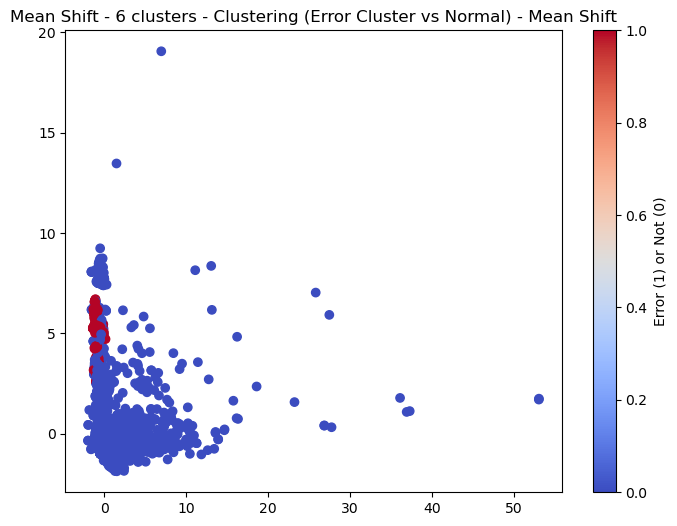


Mean Shift - 6 clusters, Error Cluster: 4
Accuracy: 0.9342
False Positives: 94
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.93      0.91     10604



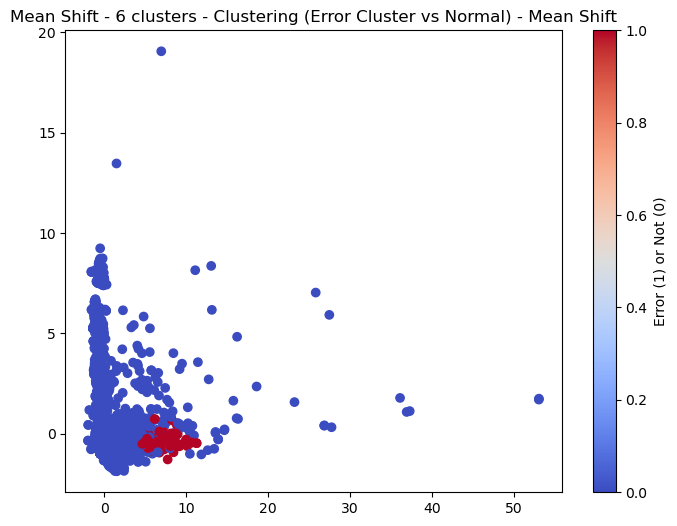


Mean Shift - 6 clusters, Error Cluster: 5
Accuracy: 0.9404
False Positives: 28
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



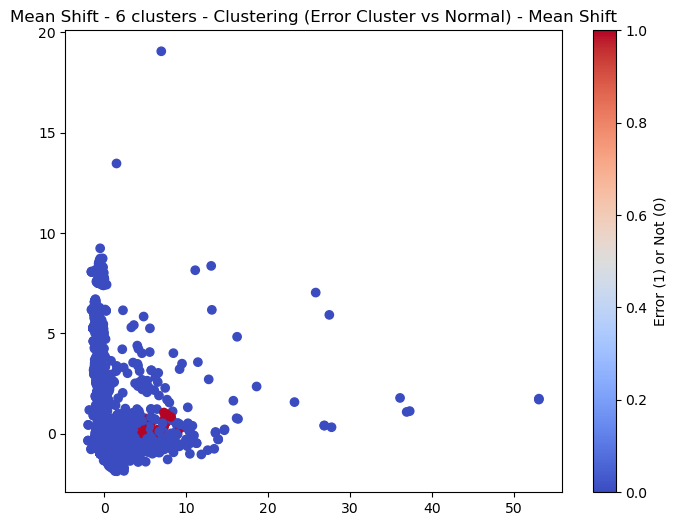


Evaluating with 7 clusters...

Mean Shift - 7 clusters, Error Cluster: 0
Accuracy: 0.2038
False Positives: 8394
False Negatives: 49
Percentage of Errors Correctly Identified: 91.89%
              precision    recall  f1-score   support

           0       0.97      0.16      0.28     10000
           1       0.06      0.92      0.12       604

    accuracy                           0.20     10604
   macro avg       0.52      0.54      0.20     10604
weighted avg       0.92      0.20      0.27     10604



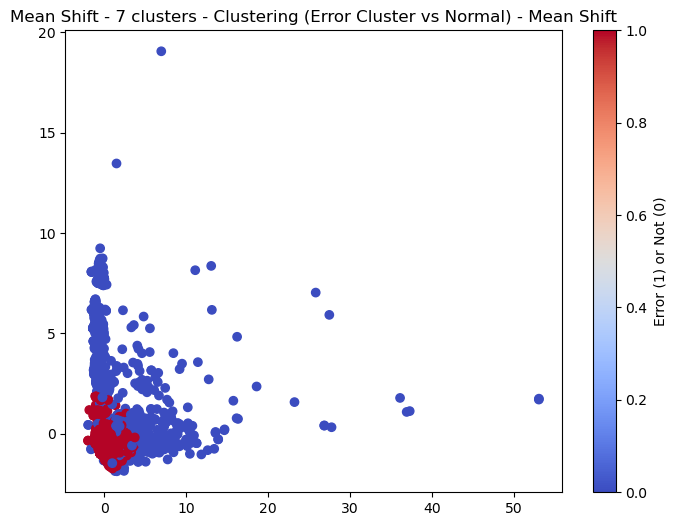


Mean Shift - 7 clusters, Error Cluster: 1
Accuracy: 0.8774
False Positives: 696
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.88     10604
   macro avg       0.47      0.47      0.47     10604
weighted avg       0.89      0.88      0.88     10604



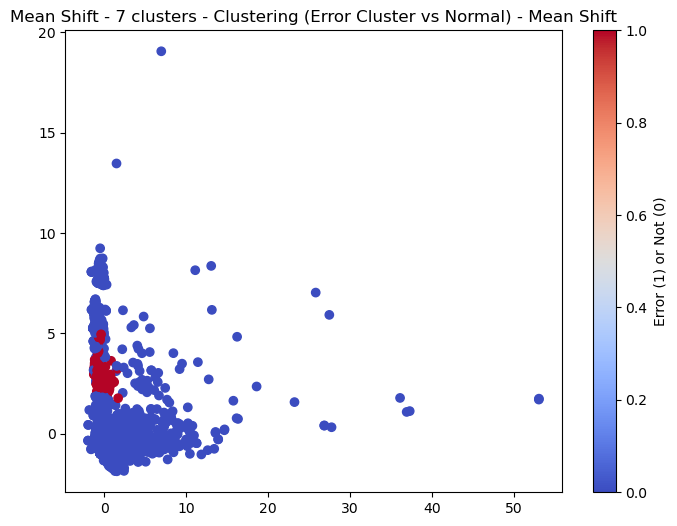


Mean Shift - 7 clusters, Error Cluster: 2
Accuracy: 0.9266
False Positives: 174
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.49      0.48     10604
weighted avg       0.89      0.93      0.91     10604



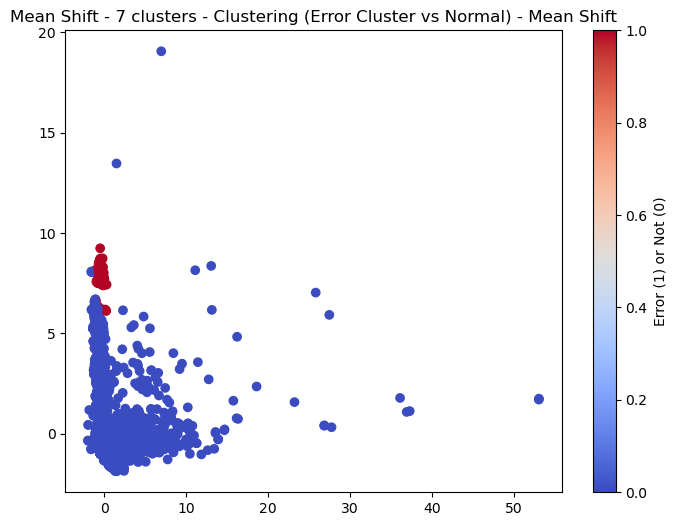


Mean Shift - 7 clusters, Error Cluster: 3
Accuracy: 0.9314
False Positives: 133
False Negatives: 594
Percentage of Errors Correctly Identified: 1.66%
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10000
           1       0.07      0.02      0.03       604

    accuracy                           0.93     10604
   macro avg       0.51      0.50      0.50     10604
weighted avg       0.89      0.93      0.91     10604



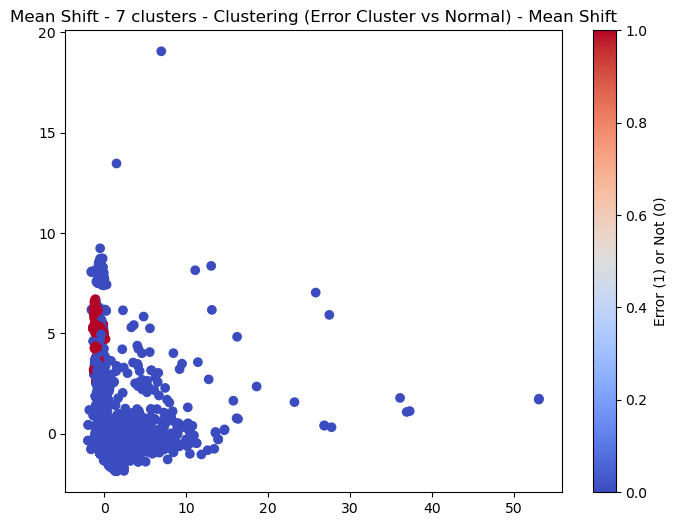


Mean Shift - 7 clusters, Error Cluster: 4
Accuracy: 0.9342
False Positives: 94
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.93     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.93      0.91     10604



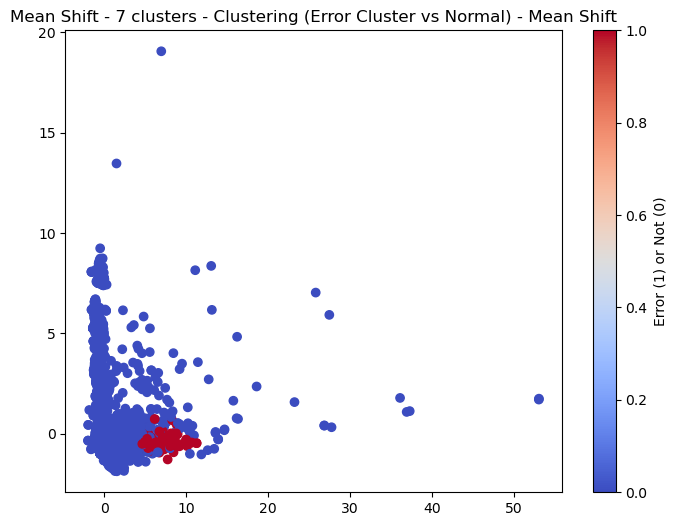


Mean Shift - 7 clusters, Error Cluster: 5
Accuracy: 0.9404
False Positives: 28
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



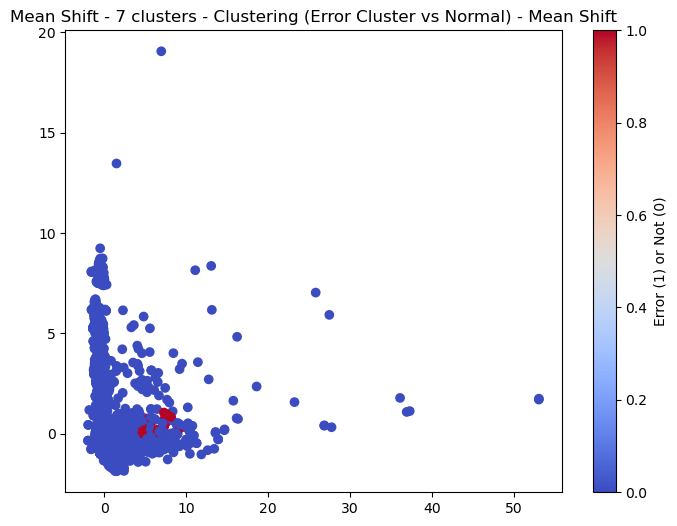


Mean Shift - 7 clusters, Error Cluster: 6
Accuracy: 0.9412
False Positives: 20
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.48     10604
weighted avg       0.89      0.94      0.91     10604



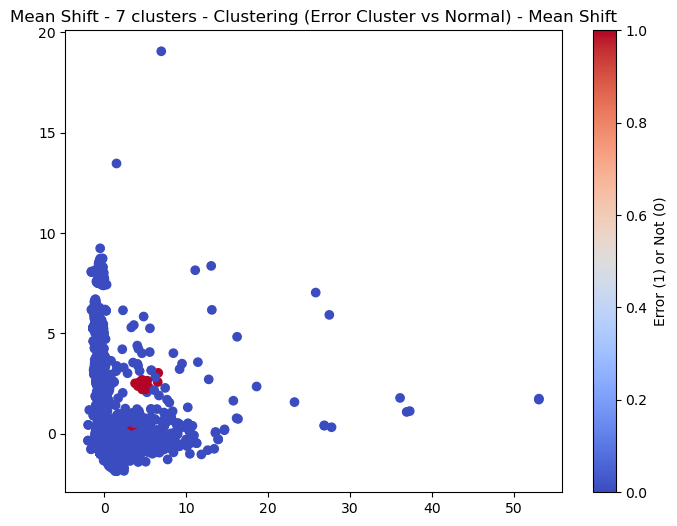

In [345]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to evaluate and visualize the clustering
def evaluate_clustering_with_different_cluster_sizes(clustering_model, name, features_scaled, true_labels, cluster_sizes):
    for n_clusters in cluster_sizes:
        print(f"\nEvaluating with {n_clusters} clusters...")

        # Update the model's number of clusters
        if hasattr(clustering_model, 'n_clusters'):
            clustering_model.n_clusters = n_clusters
        elif isinstance(clustering_model, GaussianMixture):
            clustering_model.n_components = n_clusters
        
        # Fit the model
        clustering_model.fit(features_scaled)
        
        # Get the cluster labels
        cluster_labels = clustering_model.labels_ if hasattr(clustering_model, 'labels_') else clustering_model.predict(features_scaled)
        
        # Handle DBSCAN noise (-1) and treat it as errors
        if np.any(cluster_labels == -1):
            cluster_labels = np.where(cluster_labels == -1, len(set(cluster_labels)), cluster_labels)  # Convert -1 (noise) to a new cluster
        
        # Iterate over each cluster and treat it as error (1) and the rest as normal (0)
        cluster_sizes = np.bincount(cluster_labels)
        for error_cluster in range(n_clusters):
            y_pred_binary = (cluster_labels == error_cluster).astype(int)  # Mark error cluster as 1, others as 0
            
            # Evaluation metrics
            tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
            accuracy = accuracy_score(true_labels, y_pred_binary)
            percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
            
            print(f"\n{name} - {n_clusters} clusters, Error Cluster: {error_cluster}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"False Positives: {fp}")
            print(f"False Negatives: {fn}")
            print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
            print(classification_report(true_labels, y_pred_binary))
            
            # Visualize the clusters
            visualize_clusters(features_scaled, cluster_labels, error_cluster, name, n_clusters, f"{name} - {n_clusters} clusters")

# Function for visualizing the clustering results
def visualize_clusters(features_scaled, cluster_labels, error_cluster, model_name, n_clusters, title, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot the data points, color-coded by their cluster label (normal vs. error)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels == error_cluster), cmap='coolwarm')
    plt.title(f"{title} - Clustering (Error Cluster vs Normal) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Try different clustering methods and cluster sizes
clustering_models = [
    (KMeans(random_state=42), "KMeans"),
    (DBSCAN(), "DBSCAN"),
    (AgglomerativeClustering(), "Agglomerative Clustering"),
    (GaussianMixture(random_state=42), "Gaussian Mixture Model"),
    (MeanShift(), "Mean Shift")
]

# Define the range of cluster sizes to evaluate
cluster_sizes_to_evaluate = [2, 3, 4, 5, 6, 7]

# Iterate over clustering models and evaluate them with different numbers of clusters
for model, name in clustering_models:
    evaluate_clustering_with_different_cluster_sizes(model, name, features_scaled, target, cluster_sizes_to_evaluate)


GMM Approach

Evaluating GMM with 2 components...

GMM - 2 clusters
Accuracy: 0.6042
False Positives: 3855
False Negatives: 342
Percentage of Errors Correctly Identified: 43.38%
              precision    recall  f1-score   support

           0       0.95      0.61      0.75     10000
           1       0.06      0.43      0.11       604

    accuracy                           0.60     10604
   macro avg       0.51      0.52      0.43     10604
weighted avg       0.90      0.60      0.71     10604



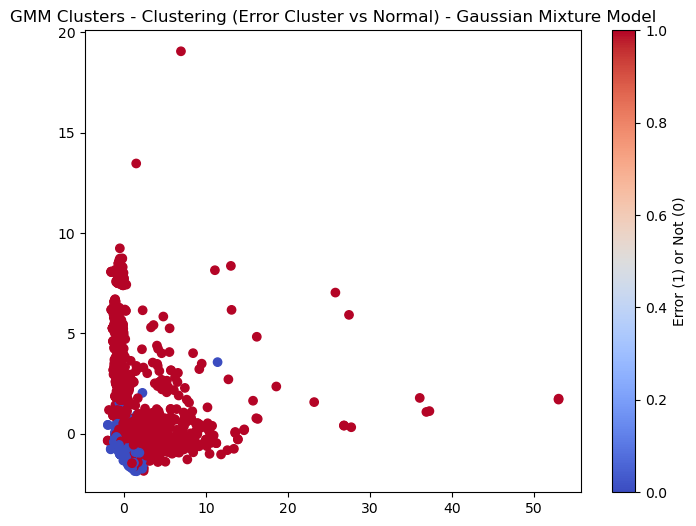

In [346]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to evaluate the Gaussian Mixture Model clustering approach
def evaluate_gmm_with_large_small_cluster(features_scaled, true_labels, n_components=2):
    print(f"Evaluating GMM with {n_components} components...")
    
    # Fit the GMM model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(features_scaled)
    
    # Get cluster labels
    cluster_labels = gmm.predict(features_scaled)
    
    # Identify the larger cluster as "normal" (0) and the smaller one(s) as "errors" (1)
    cluster_sizes = np.bincount(cluster_labels)
    large_cluster = np.argmax(cluster_sizes)  # Majority cluster is assumed to be normal
    error_clusters = [i for i in range(n_components) if i != large_cluster]  # Smaller clusters are errors

    # Mark data points in error clusters as 1 (error), others as 0 (normal)
    y_pred_binary = np.isin(cluster_labels, error_clusters).astype(int)
    
    # Evaluation metrics
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"\nGMM - {n_components} clusters")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))
    
    # Visualize the clusters
    visualize_clusters(features_scaled, cluster_labels, error_clusters, "Gaussian Mixture Model", n_components, "GMM Clusters")

# Function for visualizing the clustering results
def visualize_clusters(features_scaled, cluster_labels, error_clusters, model_name, n_clusters, title, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot the data points, color-coded by their cluster label (normal vs. error)
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=np.isin(cluster_labels, error_clusters), cmap='coolwarm')
    plt.title(f"{title} - Clustering (Error Cluster vs Normal) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Example of testing this with GMM and different number of clusters
n_components = 2  # One large and one small cluster
evaluate_gmm_with_large_small_cluster(features_scaled, target, n_components)


Best number of clusters: 10

Optimized GMM - 10 clusters
Accuracy: 0.3921
False Positives: 6433
False Negatives: 13
Percentage of Errors Correctly Identified: 97.85%
              precision    recall  f1-score   support

           0       1.00      0.36      0.53     10000
           1       0.08      0.98      0.15       604

    accuracy                           0.39     10604
   macro avg       0.54      0.67      0.34     10604
weighted avg       0.94      0.39      0.50     10604



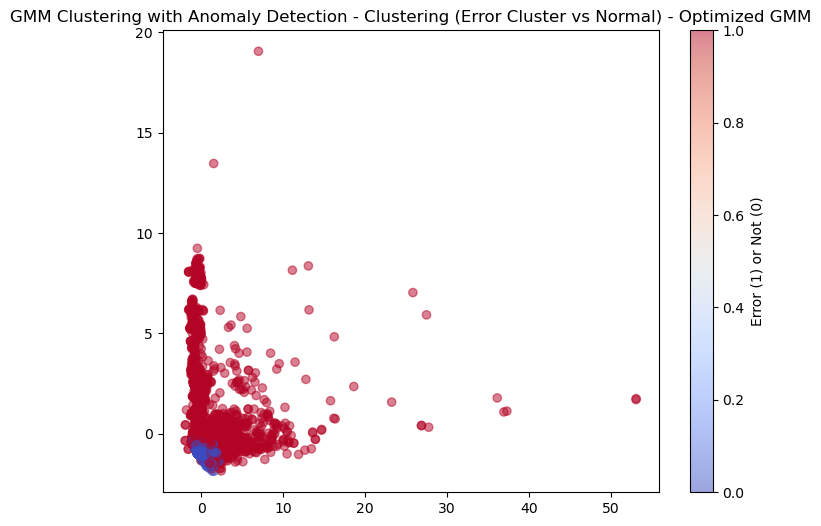

Best number of clusters: 10

Optimized GMM - 10 clusters
Accuracy: 0.3387
False Positives: 6997
False Negatives: 15
Percentage of Errors Correctly Identified: 97.52%
              precision    recall  f1-score   support

           0       1.00      0.30      0.46     10000
           1       0.08      0.98      0.14       604

    accuracy                           0.34     10604
   macro avg       0.54      0.64      0.30     10604
weighted avg       0.94      0.34      0.44     10604



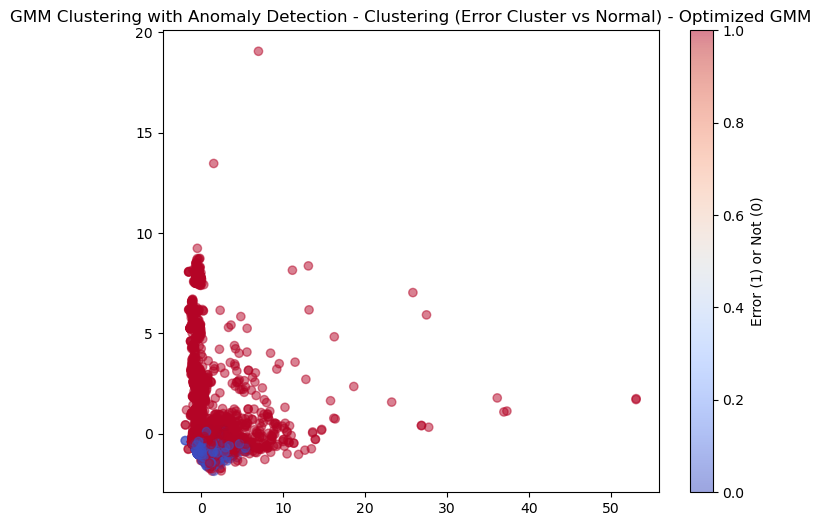

In [348]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis

def evaluate_gmm_optimized(features_scaled, true_labels, max_clusters=10, use_bayesian=False):
    best_gmm = None
    best_n_clusters = 2
    best_bic = float('inf')

    if use_bayesian:
        # Bayesian Gaussian Mixture - does not use BIC
        best_gmm = BayesianGaussianMixture(
            n_components=max_clusters, 
            covariance_type='full', 
            random_state=42, 
            weight_concentration_prior=1e-2  # Adjust this for better cluster balancing
        )
        best_gmm.fit(features_scaled)
        best_n_clusters = max_clusters  # Bayesian does not pick a "best" n_clusters
    else:
        # Standard Gaussian Mixture with BIC-based selection
        for n_clusters in range(2, max_clusters + 1):
            gmm = GaussianMixture(
                n_components=n_clusters, 
                covariance_type='full', 
                random_state=42, 
                init_params='kmeans'
            )
            gmm.fit(features_scaled)
            bic = gmm.bic(features_scaled)  # Bayesian Information Criterion

            if bic < best_bic:
                best_bic = bic
                best_gmm = gmm
                best_n_clusters = n_clusters

    print(f"Best number of clusters: {best_n_clusters}")

    # Predict cluster assignments
    cluster_labels = best_gmm.predict(features_scaled)
    
    # Assign the largest cluster as "normal"
    cluster_sizes = np.bincount(cluster_labels)
    large_cluster = np.argmax(cluster_sizes)
    error_clusters = [i for i in range(best_n_clusters) if i != large_cluster]

    # Compute Mahalanobis distance for anomaly detection
    mean_vector = best_gmm.means_[large_cluster]
    cov_matrix = best_gmm.covariances_[large_cluster]
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    distances = np.array([mahalanobis(sample, mean_vector, inv_cov_matrix) for sample in features_scaled])
    threshold = np.percentile(distances, 90)  # Consider the top 10% most distant points as errors

    # Label as error if in an error cluster or very far from the large cluster
    y_pred_binary = np.isin(cluster_labels, error_clusters).astype(int)
    y_pred_binary[distances > threshold] = 1  # Mark distant points as errors

    # Evaluation
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"\nOptimized GMM - {best_n_clusters} clusters")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))
    
    # Visualize clusters
    visualize_clusters(features_scaled, cluster_labels, error_clusters, "Optimized GMM", best_n_clusters, "GMM Clustering with Anomaly Detection")

def visualize_clusters(features_scaled, cluster_labels, error_clusters, model_name, n_clusters, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=np.isin(cluster_labels, error_clusters), cmap='coolwarm', alpha=0.5)
    plt.title(f"{title} - Clustering (Error Cluster vs Normal) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Run the optimized method
evaluate_gmm_optimized(features_scaled, target, max_clusters=10, use_bayesian=True)  # Bayesian GMM
evaluate_gmm_optimized(features_scaled, target, max_clusters=10, use_bayesian=False)  # Standard GMM


Best number of clusters: 10

Optimized GMM - 10 clusters
Accuracy: 0.1947
False Positives: 8534
False Negatives: 5
Percentage of Errors Correctly Identified: 99.17%
              precision    recall  f1-score   support

           0       1.00      0.15      0.26     10000
           1       0.07      0.99      0.12       604

    accuracy                           0.19     10604
   macro avg       0.53      0.57      0.19     10604
weighted avg       0.94      0.19      0.25     10604



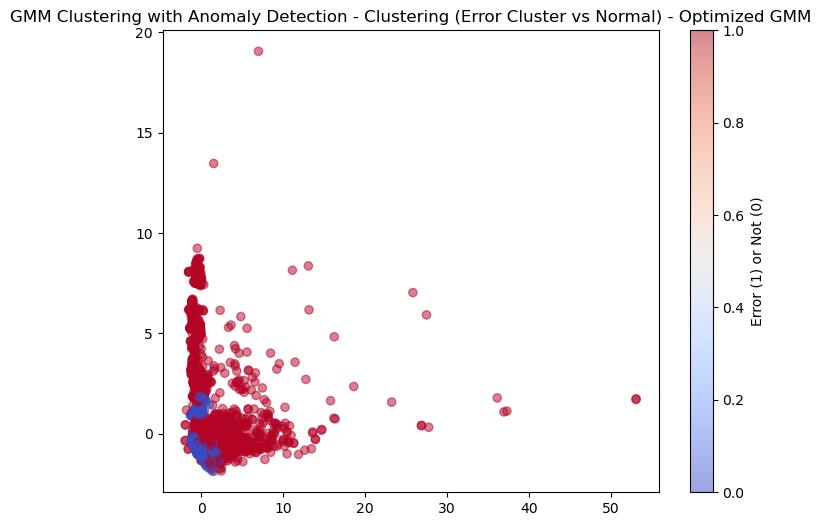

Best number of clusters: 10

Optimized GMM - 10 clusters
Accuracy: 0.4229
False Positives: 6114
False Negatives: 6
Percentage of Errors Correctly Identified: 99.01%
              precision    recall  f1-score   support

           0       1.00      0.39      0.56     10000
           1       0.09      0.99      0.16       604

    accuracy                           0.42     10604
   macro avg       0.54      0.69      0.36     10604
weighted avg       0.95      0.42      0.54     10604



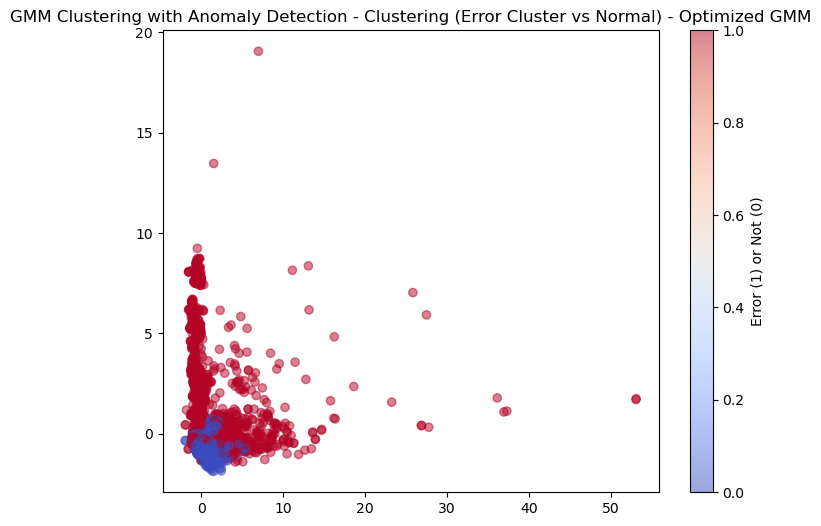

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis

def evaluate_gmm_improved(features_scaled, true_labels, max_clusters=10, use_bayesian=False):
    best_gmm = None
    best_n_clusters = 2
    best_bic = float('inf')

    if use_bayesian:
        best_gmm = BayesianGaussianMixture(
            n_components=max_clusters, 
            covariance_type='full', 
            random_state=42, 
            weight_concentration_prior=1e-3  # Smaller prior for better balance
        )
        best_gmm.fit(features_scaled)
        best_n_clusters = max_clusters
    else:
        for n_clusters in range(2, max_clusters + 1):
            gmm = GaussianMixture(
                n_components=n_clusters, 
                covariance_type='full', 
                random_state=42, 
                init_params='kmeans'
            )
            gmm.fit(features_scaled)
            bic = gmm.bic(features_scaled)

            if bic < best_bic:
                best_bic = bic
                best_gmm = gmm
                best_n_clusters = n_clusters

    print(f"Best number of clusters: {best_n_clusters}")

    # Predict cluster assignments & probabilities
    cluster_labels = best_gmm.predict(features_scaled)
    probabilities = best_gmm.predict_proba(features_scaled)

    # Find the two largest clusters and assume they are "normal"
    cluster_sizes = np.bincount(cluster_labels)
    large_clusters = np.argsort(cluster_sizes)[-2:]  # Top 2 largest clusters
    error_clusters = [i for i in range(best_n_clusters) if i not in large_clusters]

    # Compute Mahalanobis distance for anomaly detection
    mean_vector = best_gmm.means_[large_clusters[0]]
    cov_matrix = best_gmm.covariances_[large_clusters[0]]
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    distances = np.array([mahalanobis(sample, mean_vector, inv_cov_matrix) for sample in features_scaled])

    # Optimize Mahalanobis threshold using precision-recall tradeoff
    precision, recall, thresholds = precision_recall_curve(true_labels, distances)
    best_threshold = thresholds[np.argmax(precision * recall)]  # Best balance of precision & recall

    # Label as error if in an error cluster or if Mahalanobis distance is too high
    y_pred_binary = np.isin(cluster_labels, error_clusters).astype(int)
    y_pred_binary[distances > best_threshold] = 1  # Mark distant points as errors

    # Evaluation
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"\nOptimized GMM - {best_n_clusters} clusters")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))
    
    # Visualize clusters
    visualize_clusters(features_scaled, cluster_labels, error_clusters, "Optimized GMM", best_n_clusters, "GMM Clustering with Anomaly Detection")

def visualize_clusters(features_scaled, cluster_labels, error_clusters, model_name, n_clusters, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=np.isin(cluster_labels, error_clusters), cmap='coolwarm', alpha=0.5)
    plt.title(f"{title} - Clustering (Error Cluster vs Normal) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Run the improved method
evaluate_gmm_improved(features_scaled, target, max_clusters=10, use_bayesian=True)  # Bayesian GMM
evaluate_gmm_improved(features_scaled, target, max_clusters=10, use_bayesian=False)  # Standard GMM


Best number of clusters: 10

Refined GMM - 10 clusters
Accuracy: 0.3257
False Positives: 7137
False Negatives: 13
Percentage of Errors Correctly Identified: 97.85%
              precision    recall  f1-score   support

           0       1.00      0.29      0.44     10000
           1       0.08      0.98      0.14       604

    accuracy                           0.33     10604
   macro avg       0.54      0.63      0.29     10604
weighted avg       0.94      0.33      0.43     10604



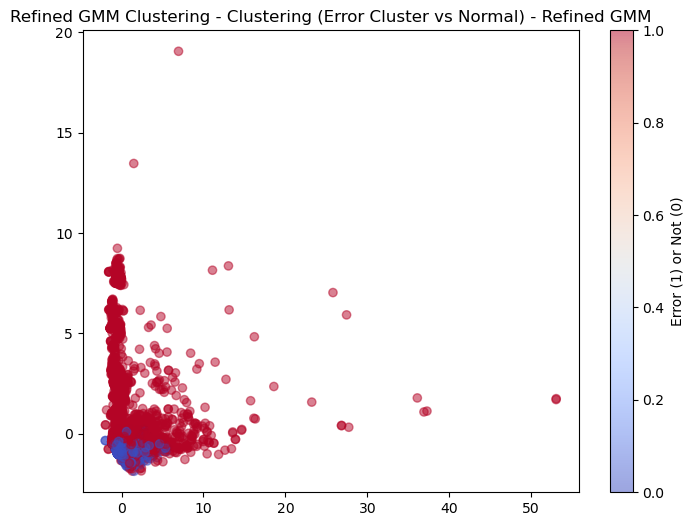

In [353]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis

def evaluate_gmm_refined(features_scaled, true_labels, max_clusters=10):
    best_gmm = None
    best_n_clusters = 2
    best_bic = float('inf')

    # Find the best GMM model using BIC
    for n_clusters in range(2, max_clusters + 1):
        gmm = GaussianMixture(
            n_components=n_clusters, 
            covariance_type='full', 
            random_state=42, 
            init_params='kmeans'
        )
        gmm.fit(features_scaled)
        bic = gmm.bic(features_scaled)

        if bic < best_bic:
            best_bic = bic
            best_gmm = gmm
            best_n_clusters = n_clusters

    print(f"Best number of clusters: {best_n_clusters}")

    # Predict cluster assignments
    cluster_labels = best_gmm.predict(features_scaled)
    cluster_sizes = np.bincount(cluster_labels)

    # Select the **largest cluster** as normal (not the most compact one)
    normal_cluster = np.argmax(cluster_sizes)  
    error_clusters = [i for i in range(best_n_clusters) if i != normal_cluster]  

    # Mahalanobis outlier detection within the normal cluster
    normal_indices = np.where(cluster_labels == normal_cluster)[0]
    mean_vector = best_gmm.means_[normal_cluster]
    cov_matrix = best_gmm.covariances_[normal_cluster]
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    normal_distances = np.array([
        mahalanobis(features_scaled[i], mean_vector, inv_cov_matrix) for i in normal_indices
    ])

    # **Use Interquartile Range (IQR) to define a better threshold**
    q25, q75 = np.percentile(normal_distances, [25, 75])
    iqr = q75 - q25
    threshold = q75 + 1.5 * iqr  # Less aggressive than a fixed 97th percentile

    # Assign labels
    y_pred_binary = np.isin(cluster_labels, error_clusters).astype(int)
    outlier_indices = normal_indices[normal_distances > threshold]
    y_pred_binary[outlier_indices] = 1  # Mark outliers in the normal cluster

    # Evaluation
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"\nRefined GMM - {best_n_clusters} clusters")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

    # Visualize clusters
    visualize_clusters(features_scaled, cluster_labels, error_clusters, "Refined GMM", best_n_clusters, "Refined GMM Clustering")

def visualize_clusters(features_scaled, cluster_labels, error_clusters, model_name, n_clusters, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=np.isin(cluster_labels, error_clusters), cmap='coolwarm', alpha=0.5)
    plt.title(f"{title} - Clustering (Error Cluster vs Normal) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Run the improved method
evaluate_gmm_refined(features_scaled, target, max_clusters=10)


More Unsupervised Models

Best number of clusters: 10


C:/Users/twool/AppData/Local/Temp/ArcGISProTemp25404/xpython_25404/3261116429.py:46: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((features_scaled - np.mean(features_scaled, axis=0)) / np.std(features_scaled, axis=0))



Robust GMM Anomaly Detection with Error Control (10% max errors)
Accuracy: 0.9430
False Positives: 0
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



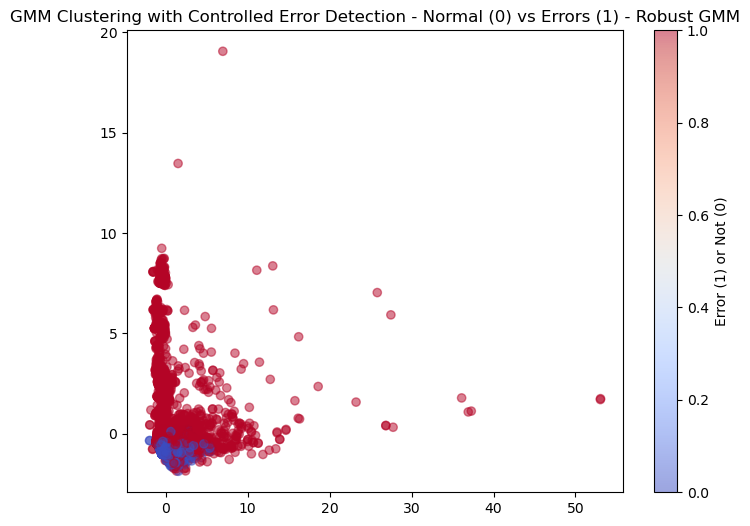

In [358]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_gmm_robust_v3(features_scaled, true_labels, max_clusters=10, error_percentage=0.1):
    # Fit GMM and choose best number of clusters based on BIC
    best_gmm = None
    best_n_clusters = 2
    best_bic = float('inf')
    
    for n_clusters in range(2, max_clusters + 1):
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params='kmeans')
        gmm.fit(features_scaled)
        bic = gmm.bic(features_scaled)
        
        if bic < best_bic:
            best_bic = bic
            best_gmm = gmm
            best_n_clusters = n_clusters

    print(f"Best number of clusters: {best_n_clusters}")
    
    # Get cluster assignments and sizes
    cluster_labels = best_gmm.predict(features_scaled)
    cluster_sizes = np.bincount(cluster_labels)
    
    # Identify the largest cluster as normal
    normal_cluster = np.argmax(cluster_sizes)
    normal_indices = np.where(cluster_labels == normal_cluster)[0]
    
    # Compute Mahalanobis distance for points in normal cluster
    mean_vector = best_gmm.means_[normal_cluster]
    cov_matrix = best_gmm.covariances_[normal_cluster]
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    mahalanobis_distances = np.array([
        mahalanobis(features_scaled[i], mean_vector, inv_cov_matrix) for i in normal_indices
    ])
    
    # Calculate Z-scores as a measure of how far points are from their mean in each feature
    z_scores = np.abs((features_scaled - np.mean(features_scaled, axis=0)) / np.std(features_scaled, axis=0))

    # Combine Mahalanobis distance and Z-scores for final anomaly score
    combined_anomaly_scores = np.zeros(len(features_scaled))
    combined_anomaly_scores[normal_indices] = mahalanobis_distances
    combined_anomaly_scores += np.sum(z_scores, axis=1)  # Add Z-score contribution

    # Add LOF-based anomaly scores
    lof = LocalOutlierFactor(n_neighbors=20, contamination=error_percentage)
    lof_anomaly_scores = lof.fit_predict(features_scaled)  # LOF outputs -1 for anomalies
    lof_anomaly_scores = np.where(lof_anomaly_scores == -1, 1, 0)

    # Add IsolationForest-based anomaly scores
    iso_forest = IsolationForest(contamination=error_percentage, random_state=42)
    iso_anomaly_scores = iso_forest.fit_predict(features_scaled)
    iso_anomaly_scores = np.where(iso_anomaly_scores == -1, 1, 0)

    # Weighted anomaly score combining all the scores
    weighted_anomaly_scores = (0.4 * combined_anomaly_scores + 0.3 * lof_anomaly_scores + 0.3 * iso_anomaly_scores)
    
    # Normalize scores for better comparison
    anomaly_threshold = np.percentile(weighted_anomaly_scores, 100 - error_percentage * 100)  # Top X% anomalies
    
    # Mark points with a higher score than the threshold as errors
    y_pred_binary = np.zeros(len(features_scaled))
    y_pred_binary[weighted_anomaly_scores >= anomaly_threshold] = 1
    
    # Evaluation
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"\nRobust GMM Anomaly Detection with Error Control ({error_percentage * 100:.0f}% max errors)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

    # Visualize the results using PCA for dimensionality reduction
    visualize_clusters(features_scaled, cluster_labels, normal_cluster, "Robust GMM", best_n_clusters, "GMM Clustering with Controlled Error Detection")

def visualize_clusters(features_scaled, cluster_labels, normal_cluster, model_name, n_clusters, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels != normal_cluster), cmap='coolwarm', alpha=0.5)
    plt.title(f"{title} - Normal (0) vs Errors (1) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Run the improved method with error control
evaluate_gmm_robust_v3(features_scaled, target, max_clusters=10, error_percentage=0.1)


Best number of clusters: 10


C:/Users/twool/AppData/Local/Temp/ArcGISProTemp25404/xpython_25404/3366016745.py:45: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((features_scaled - np.mean(features_scaled, axis=0)) / np.std(features_scaled, axis=0))



GMM-based Anomaly Detection with Error Control (10% max errors)
Accuracy: 0.9430
False Positives: 0
False Negatives: 604
Percentage of Errors Correctly Identified: 0.00%


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10000
           1       0.00      0.00      0.00       604

    accuracy                           0.94     10604
   macro avg       0.47      0.50      0.49     10604
weighted avg       0.89      0.94      0.92     10604



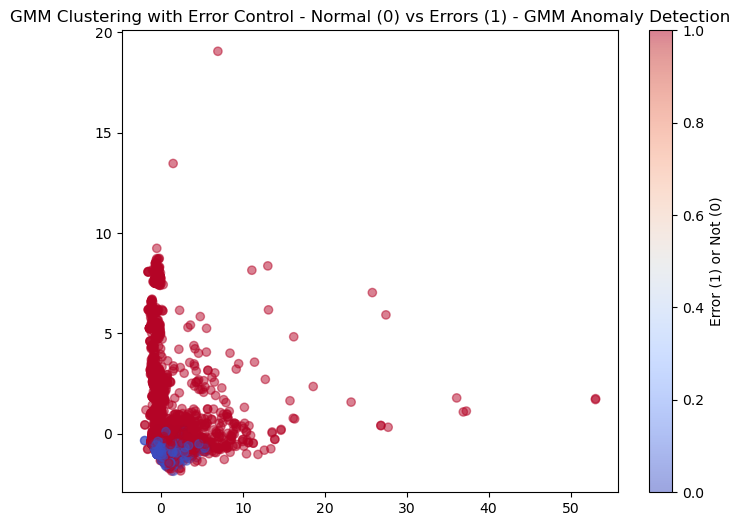

In [359]:
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_gmm_robust_v4(features_scaled, true_labels, max_clusters=10, error_percentage=0.1):
    # Fit GMM and choose the best number of clusters based on BIC
    best_gmm = None
    best_n_clusters = 2
    best_bic = float('inf')
    
    for n_clusters in range(2, max_clusters + 1):
        gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42, init_params='kmeans')
        gmm.fit(features_scaled)
        bic = gmm.bic(features_scaled)
        
        if bic < best_bic:
            best_bic = bic
            best_gmm = gmm
            best_n_clusters = n_clusters
    
    print(f"Best number of clusters: {best_n_clusters}")
    
    # Get cluster assignments and sizes
    cluster_labels = best_gmm.predict(features_scaled)
    cluster_sizes = np.bincount(cluster_labels)
    
    # Identify the largest cluster as normal
    normal_cluster = np.argmax(cluster_sizes)
    normal_indices = np.where(cluster_labels == normal_cluster)[0]
    
    # Compute Mahalanobis distance for points in normal cluster
    mean_vector = best_gmm.means_[normal_cluster]
    cov_matrix = best_gmm.covariances_[normal_cluster]
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    mahalanobis_distances = np.array([
        mahalanobis(features_scaled[i], mean_vector, inv_cov_matrix) for i in normal_indices
    ])
    
    # Combine Mahalanobis distance with Z-scores for anomaly scoring
    z_scores = np.abs((features_scaled - np.mean(features_scaled, axis=0)) / np.std(features_scaled, axis=0))
    
    combined_anomaly_scores = np.zeros(len(features_scaled))
    combined_anomaly_scores[normal_indices] = mahalanobis_distances
    combined_anomaly_scores += np.sum(z_scores, axis=1)
    
    # Apply LOF and Isolation Forest for additional anomaly scores
    lof = LocalOutlierFactor(n_neighbors=20, contamination=error_percentage)
    lof_anomaly_scores = lof.fit_predict(features_scaled)
    lof_anomaly_scores = np.where(lof_anomaly_scores == -1, 1, 0)

    iso_forest = IsolationForest(contamination=error_percentage, random_state=42)
    iso_anomaly_scores = iso_forest.fit_predict(features_scaled)
    iso_anomaly_scores = np.where(iso_anomaly_scores == -1, 1, 0)
    
    # Normalize anomaly scores
    weighted_anomaly_scores = (0.4 * combined_anomaly_scores + 0.3 * lof_anomaly_scores + 0.3 * iso_anomaly_scores)
    
    # Sort the scores and set threshold based on the desired percentage of errors
    threshold = np.percentile(weighted_anomaly_scores, 100 - error_percentage * 100)  # Choose the top X% anomalies
    
    # Label points above the threshold as errors
    y_pred_binary = np.zeros(len(features_scaled))
    y_pred_binary[weighted_anomaly_scores >= threshold] = 1
    
    # Evaluate the classification performance
    tn, fp, fn, tp = confusion_matrix(true_labels, y_pred_binary).ravel()
    accuracy = accuracy_score(true_labels, y_pred_binary)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    
    print(f"\nGMM-based Anomaly Detection with Error Control ({error_percentage * 100:.0f}% max errors)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(true_labels, y_pred_binary))

    # Visualize the results using PCA for dimensionality reduction
    visualize_clusters(features_scaled, cluster_labels, normal_cluster, "GMM Anomaly Detection", best_n_clusters, "GMM Clustering with Error Control")

def visualize_clusters(features_scaled, cluster_labels, normal_cluster, model_name, n_clusters, title):
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(features_pca[:, 0], features_pca[:, 1], c=(cluster_labels != normal_cluster), cmap='coolwarm', alpha=0.5)
    plt.title(f"{title} - Normal (0) vs Errors (1) - {model_name}")
    plt.colorbar(label='Error (1) or Not (0)')
    plt.show()

# Run the new method with error control
evaluate_gmm_robust_v4(features_scaled, target, max_clusters=10, error_percentage=0.1)


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Program Files\ArcGIS\Pro\bin\Pytho

Best number of clusters: 10


C:/Users/twool/AppData/Local/Temp/ArcGISProTemp25404/xpython_25404/3366016745.py:45: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((features_scaled - np.mean(features_scaled, axis=0)) / np.std(features_scaled, axis=0))



GMM-based Anomaly Detection with Error Control (10% max errors)
Accuracy: 0.5000
False Positives: 0
False Negatives: 302
Percentage of Errors Correctly Identified: 0.00%


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       302
         1.0       0.00      0.00      0.00       302

    accuracy                           0.50       604
   macro avg       0.25      0.50      0.33       604
weighted avg       0.25      0.50      0.33       604



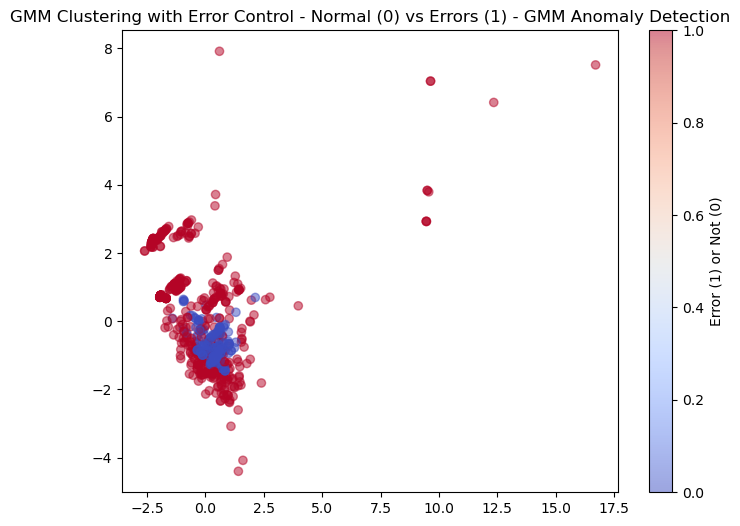

In [360]:
from sklearn.utils import resample

def balance_dataset(features, labels, target_percentage=0.5):
    # Separate the majority and minority classes
    majority_class = features[labels == 0]
    minority_class = features[labels == 1]
    
    # Downsample the majority class to match the minority class, or upsample the minority class
    n_majority = len(majority_class)
    n_minority = len(minority_class)
    
    # Determine the target number of samples for each class
    target_size = int(min(n_majority, n_minority) * target_percentage)
    
    # Downsample or upsample as needed
    majority_resampled = resample(majority_class, n_samples=target_size, random_state=42)
    minority_resampled = resample(minority_class, n_samples=target_size, random_state=42)
    
    # Combine the resampled classes
    balanced_features = np.concatenate([majority_resampled, minority_resampled])
    balanced_labels = np.concatenate([np.zeros(target_size), np.ones(target_size)])
    
    return balanced_features, balanced_labels

# Balance the dataset (with 50% error and 50% non-error)
features_balanced, labels_balanced = balance_dataset(features_scaled, target, target_percentage=0.5)

# Now apply the improved GMM-based anomaly detection on the balanced dataset
evaluate_gmm_robust_v4(features_balanced, labels_balanced, max_clusters=10, error_percentage=0.1)


Autoencoder with reconstructure error anomolies + isolation forest


332/332 [==============================] - 0s 1ms/step
Autoencoder Evaluation:
Accuracy: 0.8958
F1-score: 0.0264
False Positives: 516
False Negatives: 589
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     10000
           1       0.03      0.02      0.03       604

    accuracy                           0.90     10604
   macro avg       0.48      0.49      0.49     10604
weighted avg       0.89      0.90      0.89     10604


Isolation Forest Evaluation:
Accuracy: 0.9073
F1-score: 0.1339
False Positives: 455
False Negatives: 528
Percentage of Errors Correctly Identified: 12.58%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.14      0.13      0.13       604

    accuracy                           0.91     10604
   macro avg       0.55      0.54      0.54     10604
weighted avg       0.90      0.91      0

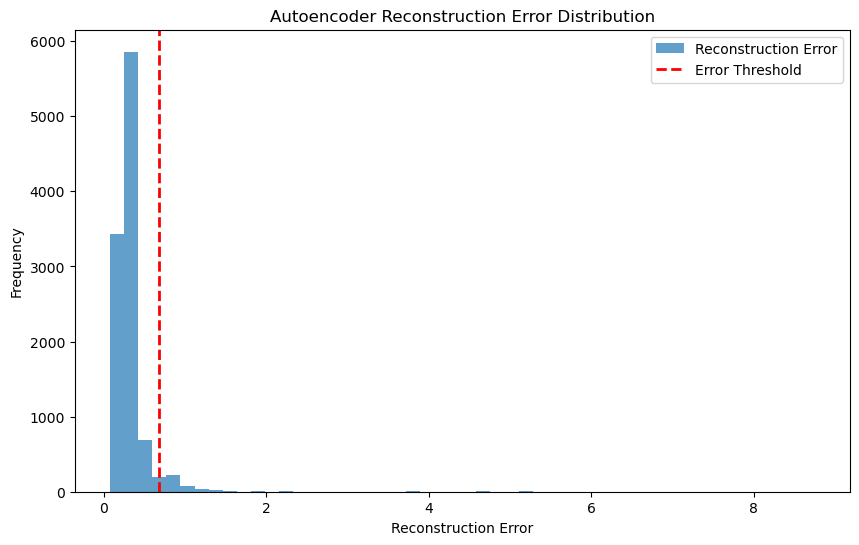

In [361]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Preprocess the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 1. **Autoencoder Model**
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Train Autoencoder on normal data (non-error data)
autoencoder = build_autoencoder(features_scaled.shape[1])
autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Calculate reconstruction error
reconstructed = autoencoder.predict(features_scaled)
reconstruction_error = np.mean(np.abs(reconstructed - features_scaled), axis=1)

# Define a threshold for reconstruction error (error if reconstruction error is high)
threshold_autoencoder = np.percentile(reconstruction_error, 95)  # Choose threshold based on error distribution
y_pred_autoencoder = (reconstruction_error > threshold_autoencoder).astype(int)

# 2. **Isolation Forest**
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
y_pred_isolation_forest = isolation_forest.fit_predict(features_scaled)
y_pred_isolation_forest = (y_pred_isolation_forest == -1).astype(int)  # -1 indicates anomaly

# Evaluate both methods
def evaluate_model(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * tp / (2 * tp + fp + fn)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    return accuracy, f1, tn, fp, fn, tp, percent_errors_identified

# Evaluate Autoencoder results
accuracy_autoencoder, f1_autoencoder, tn_autoencoder, fp_autoencoder, fn_autoencoder, tp_autoencoder, percent_errors_autoencoder = evaluate_model(target, y_pred_autoencoder)

# Evaluate Isolation Forest results
accuracy_isolation_forest, f1_isolation_forest, tn_if, fp_if, fn_if, tp_if, percent_errors_if = evaluate_model(target, y_pred_isolation_forest)

# Print results
print("Autoencoder Evaluation:")
print(f"Accuracy: {accuracy_autoencoder:.4f}")
print(f"F1-score: {f1_autoencoder:.4f}")
print(f"False Positives: {fp_autoencoder}")
print(f"False Negatives: {fn_autoencoder}")
print(f"Percentage of Errors Correctly Identified: {percent_errors_autoencoder:.2f}%")
print(classification_report(target, y_pred_autoencoder))

print("\nIsolation Forest Evaluation:")
print(f"Accuracy: {accuracy_isolation_forest:.4f}")
print(f"F1-score: {f1_isolation_forest:.4f}")
print(f"False Positives: {fp_if}")
print(f"False Negatives: {fn_if}")
print(f"Percentage of Errors Correctly Identified: {percent_errors_if:.2f}%")
print(classification_report(target, y_pred_isolation_forest))

# Visualize Autoencoder reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, label="Reconstruction Error")
plt.axvline(threshold_autoencoder, color='r', linestyle='dashed', linewidth=2, label="Error Threshold")
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()



332/332 [==============================] - 0s 999us/step
Autoencoder Evaluation:
Accuracy: 0.9156
F1-score: 0.0303
False Positives: 305
False Negatives: 590
Percentage of Errors Correctly Identified: 2.48%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10000
           1       0.04      0.02      0.03       604

    accuracy                           0.92     10604
   macro avg       0.49      0.50      0.49     10604
weighted avg       0.89      0.92      0.90     10604


Isolation Forest Evaluation:
Accuracy: 0.9073
F1-score: 0.1339
False Positives: 455
False Negatives: 528
Percentage of Errors Correctly Identified: 12.58%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.14      0.13      0.13       604

    accuracy                           0.91     10604
   macro avg       0.55      0.54      0.54     10604
weighted avg       0.90      0.91     

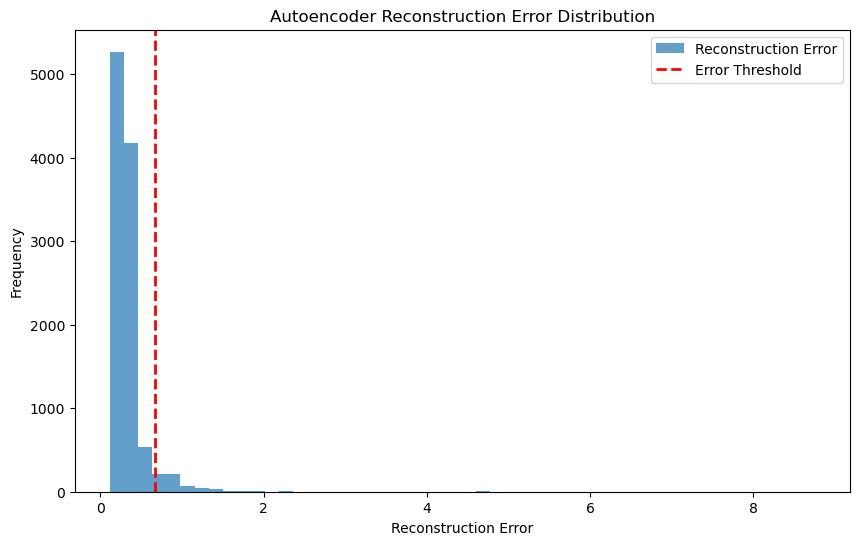

In [365]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

# Assuming the data is loaded into `df` from previous steps, let's proceed with preprocessing

# Convert the 'TRUE'/'FALSE' columns into numeric values (1 and 0)
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Identify feature and target columns
ignore_cols = ["id", "index"]
target_col = "Error"
features = df.drop(columns=ignore_cols + [target_col])
target = df[target_col]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- Isolation Forest ---
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred_iforest = iso_forest.fit_predict(features_scaled)

# Convert predictions: -1 (anomaly) -> 1, 1 (normal) -> 0
y_pred_iforest = np.where(y_pred_iforest == -1, 1, 0)

# --- Evaluate Isolation Forest ---
tn_iforest, fp_iforest, fn_iforest, tp_iforest = confusion_matrix(target, y_pred_iforest).ravel()
accuracy_iforest = (tp_iforest + tn_iforest) / (tp_iforest + tn_iforest + fp_iforest + fn_iforest)
f1_iforest = f1_score(target, y_pred_iforest)
percent_errors_identified_iforest = (tp_iforest / (tp_iforest + fn_iforest)) * 100 if (tp_iforest + fn_iforest) > 0 else 0

# --- Autoencoder ---
# Define the Autoencoder architecture
input_dim = features_scaled.shape[1]  # Number of features
encoding_dim = 14  # Latent dimension (number of features in the encoded space)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(features_scaled, features_scaled, epochs=100, batch_size=256, shuffle=True, validation_data=(features_scaled, features_scaled), verbose=0)

# Get the reconstruction error
reconstructed = autoencoder.predict(features_scaled)
reconstruction_error = np.mean(np.abs(reconstructed - features_scaled), axis=1)

# Define an error threshold for anomaly detection (let's use the 95th percentile of reconstruction error)
threshold = np.percentile(reconstruction_error, 97)

# Predict errors: 1 for error if reconstruction error is above the threshold
y_pred_autoencoder = (reconstruction_error > threshold).astype(int)

# --- Evaluate Autoencoder ---
tn_autoencoder, fp_autoencoder, fn_autoencoder, tp_autoencoder = confusion_matrix(target, y_pred_autoencoder).ravel()
accuracy_autoencoder = (tp_autoencoder + tn_autoencoder) / (tp_autoencoder + tn_autoencoder + fp_autoencoder + fn_autoencoder)
f1_autoencoder = f1_score(target, y_pred_autoencoder)
percent_errors_identified_autoencoder = (tp_autoencoder / (tp_autoencoder + fn_autoencoder)) * 100 if (tp_autoencoder + fn_autoencoder) > 0 else 0

# Results for both methods
results = {
    'Isolation Forest': {
        'accuracy': accuracy_iforest,
        'f1_score': f1_iforest,
        'false_positives': fp_iforest,
        'false_negatives': fn_iforest,
        'percent_errors_identified': percent_errors_identified_iforest,
        'classification_report': classification_report(target, y_pred_iforest)
    },
    'Autoencoder': {
        'accuracy': accuracy_autoencoder,
        'f1_score': f1_autoencoder,
        'false_positives': fp_autoencoder,
        'false_negatives': fn_autoencoder,
        'percent_errors_identified': percent_errors_identified_autoencoder,
        'classification_report': classification_report(target, y_pred_autoencoder)
    }
}

# Print the results
# Print results
print("Autoencoder Evaluation:")
print(f"Accuracy: {accuracy_autoencoder:.4f}")
print(f"F1-score: {f1_autoencoder:.4f}")
print(f"False Positives: {fp_autoencoder}")
print(f"False Negatives: {fn_autoencoder}")
print(f"Percentage of Errors Correctly Identified: {percent_errors_autoencoder:.2f}%")
print(classification_report(target, y_pred_autoencoder))

print("\nIsolation Forest Evaluation:")
print(f"Accuracy: {accuracy_isolation_forest:.4f}")
print(f"F1-score: {f1_isolation_forest:.4f}")
print(f"False Positives: {fp_if}")
print(f"False Negatives: {fn_if}")
print(f"Percentage of Errors Correctly Identified: {percent_errors_if:.2f}%")
print(classification_report(target, y_pred_isolation_forest))

# Visualize Autoencoder reconstruction error
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, label="Reconstruction Error")
plt.axvline(threshold_autoencoder, color='r', linestyle='dashed', linewidth=2, label="Error Threshold")
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [374]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv(r"C:/Users/twool/Downloads/Feature_Extraction/6414_Test/GTAA_Errors_with_metrics.csv")  # Replace with your actual file path

# Convert is_point columns from TRUE/FALSE to 1/0
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Define target column and feature columns
ignore_cols = ["id", "index"]
target_col = "Error"
features = df.drop(columns=ignore_cols + [target_col])
target = df[target_col]

# Preprocess and scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA for dimensionality reduction (optional)
pca = PCA(n_components=0.95)  # Retain 95% variance
features_scaled = pca.fit_transform(features_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# ---- Autoencoder ----

# Define Autoencoder model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    return autoencoder

# Build and train the autoencoder
autoencoder = build_autoencoder(X_train.shape[1])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

# Calculate reconstruction error on test set
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

# Use a threshold for error classification (can be adjusted based on data)
threshold = np.percentile(reconstruction_error, 95)  # Take 95th percentile as threshold
y_pred_autoencoder = (reconstruction_error > threshold).astype(int)

# ---- Isolation Forest ----

# Train Isolation Forest on the training data
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
y_pred_if_train = isolation_forest.fit_predict(X_train)

# Adjust predictions: IsolationForest returns 1 for normal, -1 for outliers (errors)
y_pred_if_train = np.where(y_pred_if_train == -1, 1, 0)

# Apply to test data for predictions
y_pred_if_test = isolation_forest.predict(X_test)

# Adjust predictions: 1 for normal, -1 for outliers (errors)
y_pred_if_test = np.where(y_pred_if_test == -1, 1, 0)

# ---- Evaluate ----

def evaluate_model(y_true, y_pred, model_name):
    # Make sure lengths match
    assert len(y_true) == len(y_pred), f"Mismatch: {len(y_true)} vs {len(y_pred)}"
    
    accuracy = np.mean(y_true == y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn)
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(y_true, y_pred))

# Evaluate Autoencoder on the test data
evaluate_model(y_test, y_pred_autoencoder, 'Autoencoder')

# Evaluate Isolation Forest on the test data
evaluate_model(y_test, y_pred_if_test, 'Isolation Forest')


Epoch 1/50

34/34 [==============================] - 2s 9ms/step - loss: 1.5836 - val_loss: 1.1240
Epoch 2/50

34/34 [==============================] - 0s 4ms/step - loss: 1.3198 - val_loss: 0.9249
Epoch 3/50

34/34 [==============================] - 0s 4ms/step - loss: 1.2118 - val_loss: 0.8658
Epoch 4/50

34/34 [==============================] - 0s 5ms/step - loss: 1.1717 - val_loss: 0.8449
Epoch 5/50

34/34 [==============================] - 0s 5ms/step - loss: 1.1583 - val_loss: 0.8372
Epoch 6/50

34/34 [==============================] - 0s 4ms/step - loss: 1.1507 - val_loss: 0.8303
Epoch 7/50

34/34 [==============================] - 0s 4ms/step - loss: 1.1449 - val_loss: 0.8262
Epoch 8/50

34/34 [==============================] - 0s 4ms/step - loss: 1.1418 - val_loss: 0.8228
Epoch 9/50

34/34 [==============================] - 0s 4ms/step - loss: 1.1386 - val_loss: 0.8198
Epoch 10/50

34/34 [==============================] - 0s 6ms/step - loss: 1.1364 - val_loss: 0.8182
Epoch 11/

In [382]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(r"C:/Users/twool/Downloads/Feature_Extraction/6414_Test/GTAA_Errors_with_metrics.csv")  # Replace with your actual dataset path

# Preprocess dataset
df.replace({"TRUE": 1, "FALSE": 0, True: 1, False: 0}, inplace=True)

# Identify feature and target columns
ignore_cols = ["id", "index"]
target_col = "Error"
features = df.drop(columns=ignore_cols + [target_col])
target = df[target_col]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# **Autoencoder for Unsupervised Learning**
# Define and train autoencoder model
autoencoder = Sequential([
    Dense(32, activation='relu', input_dim=features_scaled.shape[1]),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(features_scaled.shape[1], activation='sigmoid')
])

autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the autoencoder model
autoencoder.fit(features_scaled, features_scaled, epochs=100, batch_size=500, validation_split=0.2)

# Predict anomalies using reconstruction error
reconstruction = autoencoder.predict(features_scaled)
reconstruction_error = np.mean(np.abs(reconstruction - features_scaled), axis=1)

# Define an anomaly threshold (this can be tuned)
threshold_autoencoder = np.percentile(reconstruction_error, 91)
y_pred_autoencoder = (reconstruction_error > threshold_autoencoder).astype(int)

# **Isolation Forest**
iforest = IsolationForest(contamination=0.05, random_state=42)
y_pred_if = iforest.fit_predict(features_scaled)
y_pred_if = (y_pred_if == -1).astype(int)  # Convert from -1 (anomaly) to 1 (error)

# **KMeans Clustering (for unsupervised error detection)**
kmeans = KMeans(n_clusters=2, random_state=42)
y_pred_kmeans = kmeans.fit_predict(features_scaled)
# Assuming the first cluster (or the largest cluster) is 'normal' and the other is 'error'
normal_cluster = np.argmax(np.bincount(y_pred_kmeans))
y_pred_kmeans = (y_pred_kmeans != normal_cluster).astype(int)

# **Gaussian Mixture Model (GMM) for unsupervised error detection**
gmm = GaussianMixture(n_components=2, random_state=42)
y_pred_gmm = gmm.fit_predict(features_scaled)
# Assuming the first cluster (or the largest cluster) is 'normal' and the other is 'error'
normal_cluster_gmm = np.argmax(np.bincount(y_pred_gmm))
y_pred_gmm = (y_pred_gmm != normal_cluster_gmm).astype(int)

# **Evaluation Function**
def evaluate_unsupervised(y_true, y_pred, model_name):
    accuracy = np.mean(y_true == y_pred)  # Compare true labels with predicted labels
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(y_true, y_pred))

# Evaluate Autoencoder on the entire dataset
evaluate_unsupervised(target, y_pred_autoencoder, 'Autoencoder')

# Evaluate Isolation Forest on the entire dataset
evaluate_unsupervised(target, y_pred_if, 'Isolation Forest')

# Evaluate KMeans on the entire dataset
evaluate_unsupervised(target, y_pred_kmeans, 'KMeans')

# Evaluate Gaussian Mixture Model (GMM) on the entire dataset
evaluate_unsupervised(target, y_pred_gmm, 'Gaussian Mixture Model (GMM)')



Epoch 1/100

17/17 [==============================] - 1s 13ms/step - loss: 1.1643 - val_loss: 1.1264
Epoch 2/100

17/17 [==============================] - 0s 5ms/step - loss: 1.1149 - val_loss: 1.0738
Epoch 3/100

17/17 [==============================] - 0s 5ms/step - loss: 1.0559 - val_loss: 1.0023
Epoch 4/100

17/17 [==============================] - 0s 5ms/step - loss: 0.9740 - val_loss: 0.9086
Epoch 5/100

17/17 [==============================] - 0s 5ms/step - loss: 0.8811 - val_loss: 0.8204
Epoch 6/100

17/17 [==============================] - 0s 6ms/step - loss: 0.8097 - val_loss: 0.7682
Epoch 7/100

17/17 [==============================] - 0s 5ms/step - loss: 0.7697 - val_loss: 0.7383
Epoch 8/100

17/17 [==============================] - 0s 5ms/step - loss: 0.7461 - val_loss: 0.7192
Epoch 9/100

17/17 [==============================] - 0s 5ms/step - loss: 0.7299 - val_loss: 0.7061
Epoch 10/100

17/17 [==============================] - 0s 5ms/step - loss: 0.7174 - val_loss: 0.694

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Autoencoder Evaluation:
Accuracy: 0.8624
F1-score: 0.0641
False Positives: 905
False Negatives: 554
Percentage of Errors Correctly Identified: 8.28%
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     10000
           1       0.05      0.08      0.06       604

    accuracy                           0.86     10604
   macro avg       0.50      0.50      0.49     10604
weighted avg       0.89      0.86      0.88     10604


Isolation Forest Evaluation:
Accuracy: 0.9073
F1-score: 0.1339
False Positives: 455
False Negatives: 528
Percentage of Errors Correctly Identified: 12.58%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.14      0.13      0.13       604

    accuracy                           0.91     10604
   macro avg       0.55      0.54      0.54     10604
weighted avg       0.90      0.91      0.90     10604


KMeans Evaluation:
Accuracy: 0.9061
F1-

More Models

In [383]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# **One-Class SVM for Anomaly Detection**
ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
y_pred_ocsvm = ocsvm.fit_predict(features_scaled)
y_pred_ocsvm = (y_pred_ocsvm == -1).astype(int)  # Convert from -1 (outlier) to 1 (error)

# **Local Outlier Factor (LOF) for Anomaly Detection**
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred_lof = lof.fit_predict(features_scaled)
y_pred_lof = (y_pred_lof == -1).astype(int)  # Convert from -1 (outlier) to 1 (error)

# **DBSCAN for Anomaly Detection**
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_pred_dbscan = dbscan.fit_predict(features_scaled)
y_pred_dbscan = (y_pred_dbscan == -1).astype(int)  # Treat noise points as errors

# **k-NN for Anomaly Detection**
knn = NearestNeighbors(n_neighbors=20)
knn.fit(features_scaled)
distances, indices = knn.kneighbors(features_scaled)
distance_threshold = np.percentile(distances[:, -1], 95)  # Threshold for anomaly detection
y_pred_knn = (distances[:, -1] > distance_threshold).astype(int)

# **Evaluation Function** (same as before)
def evaluate_unsupervised(y_true, y_pred, model_name):
    accuracy = np.mean(y_true == y_pred)  # Compare true labels with predicted labels
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")
    print(classification_report(y_true, y_pred))

# Evaluate One-Class SVM
evaluate_unsupervised(target, y_pred_ocsvm, 'One-Class SVM')

# Evaluate Local Outlier Factor
evaluate_unsupervised(target, y_pred_lof, 'Local Outlier Factor')

# Evaluate DBSCAN
evaluate_unsupervised(target, y_pred_dbscan, 'DBSCAN')

# Evaluate k-NN
evaluate_unsupervised(target, y_pred_knn, 'k-NN')



One-Class SVM Evaluation:
Accuracy: 0.9032
F1-score: 0.0984
False Positives: 478
False Negatives: 548
Percentage of Errors Correctly Identified: 9.27%
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.10      0.09      0.10       604

    accuracy                           0.90     10604
   macro avg       0.53      0.52      0.52     10604
weighted avg       0.90      0.90      0.90     10604


Local Outlier Factor Evaluation:
Accuracy: 0.9007
F1-score: 0.0722
False Positives: 490
False Negatives: 563
Percentage of Errors Correctly Identified: 6.79%
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.08      0.07      0.07       604

    accuracy                           0.90     10604
   macro avg       0.51      0.51      0.51     10604
weighted avg       0.89      0.90      0.90     10604


DBSCAN Evaluation:
Accuracy: 0.694

Autoencoder + k-means

Epoch 1/50

34/34 [==============================] - 1s 7ms/step - loss: 1.1611 - val_loss: 1.0923
Epoch 2/50

34/34 [==============================] - 0s 3ms/step - loss: 1.0653 - val_loss: 0.9993
Epoch 3/50

34/34 [==============================] - 0s 3ms/step - loss: 0.9721 - val_loss: 0.9086
Epoch 4/50

34/34 [==============================] - 0s 3ms/step - loss: 0.8867 - val_loss: 0.8298
Epoch 5/50

34/34 [==============================] - 0s 3ms/step - loss: 0.8188 - val_loss: 0.7738
Epoch 6/50

34/34 [==============================] - 0s 3ms/step - loss: 0.7731 - val_loss: 0.7373
Epoch 7/50

34/34 [==============================] - 0s 3ms/step - loss: 0.7439 - val_loss: 0.7134
Epoch 8/50

34/34 [==============================] - 0s 5ms/step - loss: 0.7243 - val_loss: 0.6941
Epoch 9/50

34/34 [==============================] - 0s 4ms/step - loss: 0.7110 - val_loss: 0.6823
Epoch 10/50

34/34 [==============================] - 0s 3ms/step - loss: 0.7018 - val_loss: 0.6742
Epoch 11/

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     10000
           1       0.03      0.07      0.04       604

    accuracy                           0.82     10604
   macro avg       0.48      0.47      0.47     10604
weighted avg       0.89      0.82      0.85     10604

F1-score: 0.0408
False Positives: 1366
False Negatives: 563
Percentage of Errors Correctly Identified: 6.79%


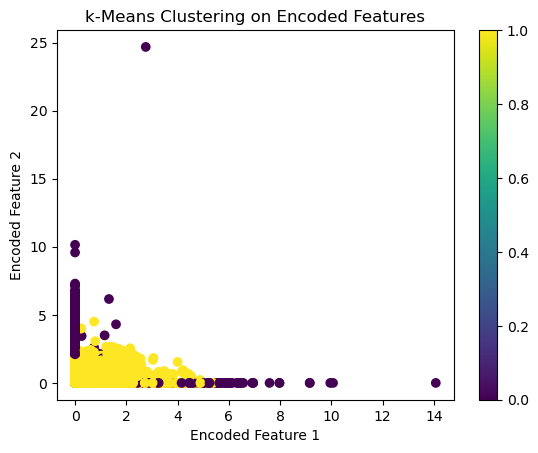

In [385]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to train Autoencoder
def train_autoencoder(features, encoding_dim=32):
    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Define Autoencoder model architecture
    input_layer = Input(shape=(features_scaled.shape[1],))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(features_scaled.shape[1], activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train Autoencoder
    autoencoder.fit(features_scaled, features_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)
    
    # Encoder part to get the encoded representation
    encoder = Model(input_layer, encoded)
    encoded_features = encoder.predict(features_scaled)
    
    return encoded_features, scaler

# Function to apply k-Means clustering to the encoded features
def kmeans_clustering(encoded_features, num_clusters=2):
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(encoded_features)
    return cluster_labels, kmeans

# Function to classify anomalies based on k-Means clusters
def classify_anomalies(cluster_labels, num_clusters=2, max_anomalies_percentage=0.1):
    # Identify clusters and their sizes
    unique, counts = np.unique(cluster_labels, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))

    # Sort the clusters by size (smallest first, assuming minority error cluster is small)
    sorted_clusters = sorted(cluster_sizes, key=lambda x: cluster_sizes[x])

    # Calculate the maximum number of anomalies based on the percentage
    total_points = len(cluster_labels)
    max_anomalies = int(total_points * max_anomalies_percentage)

    # Start by treating the smallest clusters as anomalies, up to the max allowed
    anomalies = np.zeros(len(cluster_labels))
    anomaly_cluster = sorted_clusters[0]  # smallest cluster

    # Label the smallest cluster as anomalies
    anomalies[cluster_labels == anomaly_cluster] = 1

    # If needed, you can consider other small clusters as anomalies
    remaining_anomalies = max_anomalies - np.sum(anomalies)
    for cluster in sorted_clusters[1:]:
        if remaining_anomalies <= 0:
            break
        additional_anomalies = np.minimum(np.sum(cluster_labels == cluster), remaining_anomalies)
        anomalies[cluster_labels == cluster] = 1
        remaining_anomalies -= additional_anomalies

    return anomalies

# Function to evaluate the anomaly detection model
def evaluate_model(true_labels, predicted_labels):
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Train Autoencoder and apply k-Means clustering
encoded_features, scaler = train_autoencoder(features)

# Apply k-Means clustering to the encoded features
cluster_labels, kmeans = kmeans_clustering(encoded_features)

# Classify anomalies based on the clustering
anomalies = classify_anomalies(cluster_labels, max_anomalies_percentage=0.1)

# Evaluate the model performance
evaluate_model(target, anomalies)

# Optionally, visualize the clustering result
plt.scatter(encoded_features[:, 0], encoded_features[:, 1], c=cluster_labels, cmap='viridis')
plt.title('k-Means Clustering on Encoded Features')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.colorbar()
plt.show()


In [386]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_isolation_forest(features, target, contamination=0.05):
    # Train Isolation Forest
    model = IsolationForest(contamination=contamination)
    model.fit(features)

    # Predict anomalies (errors)
    y_pred = model.predict(features)
    # Isolation Forest returns -1 for anomalies and 1 for normal points
    y_pred_binary = np.where(y_pred == -1, 1, 0)

    # Evaluation
    print("\nClassification Report (Isolation Forest):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Apply Isolation Forest
evaluate_isolation_forest(features_scaled, target, contamination=0.05)  # Set contamination to 5% for a small minority




Classification Report (Isolation Forest):
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     10000
           1       0.03      0.03      0.03       604

    accuracy                           0.90     10604
   macro avg       0.49      0.49      0.49     10604
weighted avg       0.89      0.90      0.89     10604

F1-score: 0.0317
False Positives: 513
False Negatives: 586
Percentage of Errors Correctly Identified: 2.98%


In [387]:
from sklearn.neighbors import LocalOutlierFactor

def evaluate_lof(features, target, n_neighbors=20):
    # Train LOF model
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    y_pred = lof.fit_predict(features)
    # LOF returns -1 for anomalies and 1 for normal points
    y_pred_binary = np.where(y_pred == -1, 1, 0)

    # Evaluation
    print("\nClassification Report (LOF):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Apply LOF anomaly detection
evaluate_lof(features_scaled, target)



Classification Report (LOF):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     10000
           1       0.05      0.08      0.06       604

    accuracy                           0.85     10604
   macro avg       0.49      0.49      0.49     10604
weighted avg       0.89      0.85      0.87     10604

F1-score: 0.0576
False Positives: 981
False Negatives: 557
Percentage of Errors Correctly Identified: 7.78%


PCA with reconstruction error anomolies

In [388]:
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_pca_anomaly(features, target, n_components=2, threshold_percentile=95):
    # Fit PCA model
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)

    # Reconstruct the original data
    features_reconstructed = pca.inverse_transform(features_pca)

    # Compute the reconstruction error (Euclidean distance)
    reconstruction_error = np.linalg.norm(features - features_reconstructed, axis=1)

    # Determine anomaly threshold (e.g., top 5% highest reconstruction errors)
    threshold = np.percentile(reconstruction_error, threshold_percentile)
    
    # Classify as anomaly (1) if reconstruction error exceeds the threshold
    y_pred_binary = (reconstruction_error > threshold).astype(int)

    # Evaluation
    print("\nClassification Report (PCA Anomaly Detection):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Apply PCA anomaly detection
evaluate_pca_anomaly(features_scaled, target)



Classification Report (PCA Anomaly Detection):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10000
           1       0.10      0.08      0.09       604

    accuracy                           0.90     10604
   macro avg       0.52      0.52      0.52     10604
weighted avg       0.90      0.90      0.90     10604

F1-score: 0.0899
False Positives: 480
False Negatives: 553
Percentage of Errors Correctly Identified: 8.44%


In [389]:
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance

def evaluate_pca_with_mahalanobis(features, target, variance_threshold=0.95, threshold_percentile=95):
    # Fit PCA and select components based on explained variance
    pca = PCA()
    pca.fit(features)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features)

    # Reconstruct the data
    features_reconstructed = pca.inverse_transform(features_pca)

    # Compute reconstruction error
    reconstruction_error = np.linalg.norm(features - features_reconstructed, axis=1)

    # Mahalanobis distance calculation
    covariance_estimator = EmpiricalCovariance().fit(features)
    mahalanobis_distances = []
    for i in range(features.shape[0]):
        dist = mahalanobis(features[i], np.mean(features, axis=0), covariance_estimator.precision_)
        mahalanobis_distances.append(dist)
    
    mahalanobis_distances = np.array(mahalanobis_distances)

    # Combine reconstruction error and Mahalanobis distance for anomaly detection
    threshold_reconstruction = np.percentile(reconstruction_error, threshold_percentile)
    threshold_mahalanobis = np.percentile(mahalanobis_distances, threshold_percentile)

    # Combine both thresholds for anomaly detection
    y_pred_binary = (reconstruction_error > threshold_reconstruction) | (mahalanobis_distances > threshold_mahalanobis)
    
    # Evaluation metrics
    print("\nClassification Report (PCA + Mahalanobis Anomaly Detection):")
    print(classification_report(target, y_pred_binary))

    tn, fp, fn, tp = confusion_matrix(target, y_pred_binary).ravel()
    f1 = 2 * tp / (2 * tp + fp + fn) if tp + fn + fp > 0 else 0
    percent_errors_identified = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0

    print(f"F1-score: {f1:.4f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Percentage of Errors Correctly Identified: {percent_errors_identified:.2f}%")

# Run PCA with Mahalanobis Distance Anomaly Detection
evaluate_pca_with_mahalanobis(features_scaled, target)



Classification Report (PCA + Mahalanobis Anomaly Detection):
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10000
           1       0.06      0.07      0.06       604

    accuracy                           0.88     10604
   macro avg       0.50      0.50      0.50     10604
weighted avg       0.89      0.88      0.88     10604

F1-score: 0.0645
False Positives: 746
False Negatives: 559
Percentage of Errors Correctly Identified: 7.45%


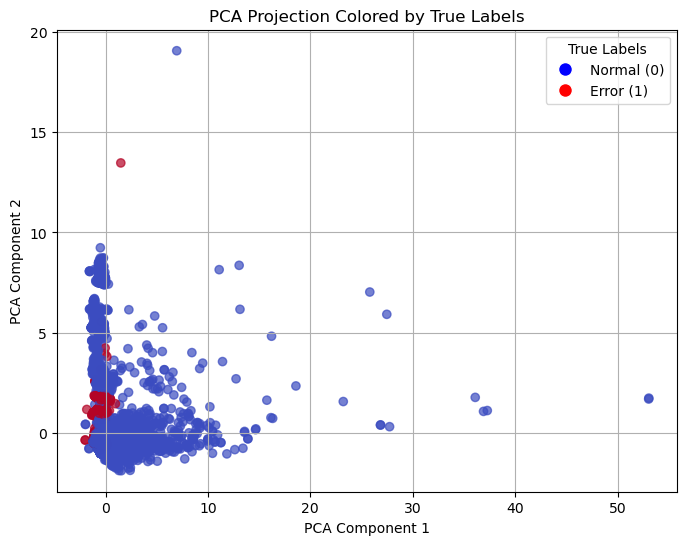

In [25]:

def visualize_true_labels(features_scaled, true_labels, pca_components=2):
    pca = PCA(n_components=pca_components)
    features_pca = pca.fit_transform(features_scaled)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=true_labels, cmap='coolwarm', alpha=0.7)
    legend_labels = {0: 'Normal (0)', 1: 'Error (1)'}
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[label],
                          markerfacecolor=clr, markersize=10)
               for label, clr in zip([0, 1], ['blue', 'red'])]
    plt.legend(handles=handles, title='True Labels')
    plt.title("PCA Projection Colored by True Labels")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()
visualize_true_labels(features_scaled, target)
